# Problem definition 

Predicting whether the client will pay off the loan or not, classification problem.

2 classes:
* Fully Paid - 1
* Charged off - 0

**Goal**: 80% roc auc score

**Evaluation metric**: roc auc score


### Info:

Lending Club to firma pożyczkowa typu peer-to-peer, która łączy pożyczkobiorców z inwestorami za pośrednictwem platformy internetowej. Obsługuje osoby, które potrzebują pożyczek osobistych w wysokości od 1000 do 40 000 USD. Pożyczkobiorcy otrzymują pełną kwotę udzielonej pożyczki pomniejszoną o opłatę początkową, która jest uiszczana firmie. Inwestorzy kupują weksle zabezpieczone osobistymi pożyczkami i płacą Lending Club opłatę za usługę. Firma Lending Club udostępnia dane o wszystkich pożyczkach udzielonych za pośrednictwem swojej platformy w określonych okresach.
Na potrzeby tego projektu zostały użyte dane dotyczące pożyczek udzielonych za pośrednictwem Lending Club na przestrzeni lat 2007 -2011. Każda pożyczka jest opatrzona informacją o tym, czy ostatecznie została spłacona (Fully Paid lub Charged off w kolumnie loan_status). 



### Version info:
* python: 3.8.8
* pandas 1.2.4
* numpy 1.20.1
* sklearn 0.24.1
* seaborn 0.11.1
* matplotlib 3.3.4

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.preprocessing import OneHotEncoder, Normalizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek

import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.decomposition import PCA
import pickle

import warnings
warnings.filterwarnings("ignore")

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
start_time = time.time()

In [3]:
# import sys
# sys.version
# pd.__version__

### Data dictionary

In [4]:
data_dict = pd.read_csv('LCDataDictionary.csv', usecols = ['LoanStatNew', 'Description'])

### Function for quick feature description

In [5]:
def feature_desc(feature_to_describe):
    
    '''
    displays full feature description
    input -> (str) name of feature in data dictionary
    '''
    
    pd.set_option('max_colwidth', 800)
    return data_dict[data_dict['LoanStatNew'] == feature_to_describe]

In [6]:
feature_desc('loan_status')

LoanStatNew                 Description
42  loan_status  Current status of the loan

# Data Processing
1.	Obróbka danych (Data Processing) (70pkt) – jako doświadczony Data Scientist zapewne znasz poszczególne kroki, które należy wykonać na tym etapie, więc nie będziemy ich tutaj wyszczególniać.

### Load only data that meets the credit policy.

In [7]:
df = pd.read_csv('Loan_data.csv', nrows = 39786)

### Basic Data Exploration

In [8]:
df

id  member_id  loan_amnt  funded_amnt  funded_amnt_inv  \
0      1077501        NaN       5000         5000           4975.0   
1      1077430        NaN       2500         2500           2500.0   
2      1077175        NaN       2400         2400           2400.0   
3      1076863        NaN      10000        10000          10000.0   
4      1075358        NaN       3000         3000           3000.0   
...        ...        ...        ...          ...              ...   
39781    92187        NaN       2500         2500           1075.0   
39782    90665        NaN       8500         8500            875.0   
39783    90395        NaN       5000         5000           1325.0   
39784    90376        NaN       5000         5000            650.0   
39785    87023        NaN       7500         7500            800.0   

             term int_rate  installment grade sub_grade  ...  \
0       36 months   10.65%       162.87     B        B2  ...   
1       60 months   15.27%        59.83     C        C4  ...   
2       36 months   15.96%        84.33     C        C5  ...   
3       36 months   13.49%       339.31     C        C1  ...   
4       60 months   12.69%        67.79     B        B5  ...   
...           ...      ...          ...   ...       ...  ...   
39781   36 months    8.07%        78.42     A        A4  ...   
39782   36 months   10.28%       275.38     C        C1  ...   
39783   36 months    8.07%       156.84     A        A4  ...   
39784   36 months    7.43%       155.38     A        A2  ...   
39785   36 months   13.75%       255.43     E        E2  ...   

      hardship_payoff_balance_amount hardship_last_payment_amount  \
0                                NaN                          NaN   
1                                NaN                          NaN   
2                                NaN                          NaN   
3                                NaN                          NaN   
4                                NaN                          NaN   
...                              ...                          ...   
39781                            NaN                          NaN   
39782                            NaN                          NaN   
39783                            NaN                          NaN   
39784                            NaN                          NaN   
39785                            NaN                          NaN   

      disbursement_method  debt_settlement_flag debt_settlement_flag_date  \
0                    Cash                     N                       NaN   
1                    Cash                     N                       NaN   
2                    Cash                     N                       NaN   
3                    Cash                     N                       NaN   
4                    Cash                     N                       NaN   
...                   ...                   ...                       ...   
39781                Cash                     N                       NaN   
39782                Cash                     N                       NaN   
39783                Cash                     N                       NaN   
39784                Cash                     N                       NaN   
39785                Cash                     N                       NaN   

      settlement_status settlement_date settlement_amount  \
0                   NaN             NaN               NaN   
1                   NaN             NaN               NaN   
2                   NaN             NaN               NaN   
3                   NaN             NaN               NaN   
4                   NaN             NaN               NaN   
...                 ...             ...               ...   
39781               NaN             NaN               NaN   
39782               NaN             NaN               NaN   
39783               NaN             NaN               NaN   
39784               NaN             Na

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39786 entries, 0 to 39785
Columns: 151 entries, id to settlement_term
dtypes: float64(106), int64(16), object(29)
memory usage: 45.8+ MB


In [10]:
df.describe()

id  member_id     loan_amnt   funded_amnt  funded_amnt_inv  \
count  3.978600e+04        0.0  39786.000000  39786.000000     39786.000000   
mean   6.833939e+05        NaN  11231.360277  10958.722289     10409.134336   
std    2.106770e+05        NaN   7464.542832   7194.076908      7135.661270   
min    5.473400e+04        NaN    500.000000    500.000000         0.000000   
25%    5.163518e+05        NaN   5500.000000   5400.000000      5000.000000   
50%    6.662295e+05        NaN  10000.000000   9650.000000      8975.000000   
75%    8.378710e+05        NaN  15000.000000  15000.000000     14400.000000   
max    1.077501e+06        NaN  35000.000000  35000.000000     35000.000000   

        installment    annual_inc           dti   delinq_2yrs  fico_range_low  \
count  39786.000000  3.978600e+04  39786.000000  39786.000000    39786.000000   
mean     324.733637  6.897907e+04     13.317794      0.146534      714.997989   
std      208.923212  6.376263e+04      6.678300      0.491826       35.840682   
min       15.690000  4.000000e+03      0.000000      0.000000      625.000000   
25%      167.080000  4.050000e+04      8.180000      0.000000      685.000000   
50%      280.610000  5.900000e+04     13.410000      0.000000      710.000000   
75%      430.780000  8.234250e+04     18.600000      0.000000      740.000000   
max     1305.190000  6.000000e+06     29.990000     11.000000      825.000000   

       ...  payment_plan_start_date  hardship_length  hardship_dpd  \
count  ...                      0.0              0.0           0.0   
mean   ...                      NaN              NaN           NaN   
std    ...                      NaN              NaN           NaN   
min    ...                      NaN              NaN           NaN   
25%    ...                      NaN              NaN           NaN   
50%    ...                      NaN              NaN           NaN   
75%    ...                      NaN              NaN           NaN   
max    ...                      NaN              NaN           NaN   

       hardship_loan_status  orig_projected_additional_accrued_interest  \
count                   0.0                                         0.0   
mean                    NaN                                         NaN   
std                     NaN                                         NaN   
min                     NaN                                         NaN   
25%                     NaN                                         NaN   
50%                     NaN                                         NaN   
75%                     NaN                                         NaN   
max                     NaN                                         NaN   

       hardship_payoff_balance_amount  hardship_last_payment_amount  \
count                             0.0                           0.0   
mean                              NaN                           NaN   
std                               NaN                           NaN   
min                               NaN                           NaN   
25%                               NaN                           NaN   
50%                               NaN                           NaN   
75%                               NaN                           NaN   
max                               NaN                           NaN   

       settlement_amount  settlement_percentage  settlement_term  
count         150.000000             150.000000       150.000000  
mean         4321.311333              49.859133         1.133333  
std          3161.729302              15.689034         3.980939  
min           193.290000              10.690000         0.000000  
25%          1860.250000              40.000000         0.000000  
50%          3499.350000              49.970000         0.000000  
75%          5733.700000              60.000000         0.000000  
max         14798.200000              92.740000        24.000000  

[8 rows x 122 columns]

### Data that does not meet the credit policy -> additional samples for 'Charged Off' class

In [11]:
df_policy_issue = pd.read_csv('Loan_data.csv', skiprows = 39790, names =df.columns)
df_policy_issue.head()

id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  642818        NaN       2950         2950      2950.000000   60 months   
1  641659        NaN      20000        20000     16466.109187   60 months   
2  641638        NaN       3500         3500      3500.000000   60 months   
3  641193        NaN       5000         5000      5000.000000   36 months   
4  641066        NaN       2500         2500      2500.000000   60 months   

  int_rate  installment grade sub_grade  ... hardship_payoff_balance_amount  \
0   15.95%        71.66     E        E1  ...                            NaN   
1   19.66%       526.11     G        G1  ...                            NaN   
2   15.57%        84.32     D        D5  ...                            NaN   
3   15.20%       173.82     D        D4  ...                            NaN   
4   14.83%        59.26     D        D3  ...                            NaN   

  hardship_last_payment_amount disbursement_method  debt_settlement_flag  \
0                          NaN                Cash                     N   
1                          NaN                Cash                     N   
2                          NaN                Cash                     N   
3                          NaN                Cash                     N   
4                          NaN                Cash                     N   

  debt_settlement_flag_date settlement_status settlement_date  \
0                       NaN               NaN             NaN   
1                       NaN               NaN             NaN   
2                       NaN               NaN             NaN   
3                       NaN               NaN             NaN   
4                       NaN               NaN             NaN   

  settlement_amount settlement_percentage settlement_term  
0               NaN                   NaN             NaN  
1               NaN                   NaN             NaN  
2               NaN                   NaN             NaN  
3               NaN                   NaN             NaN  
4               NaN                   NaN             NaN  

[5 rows x 151 columns]

In [12]:
df_policy_issue['loan_status'].value_counts()

Does not meet the credit policy. Status:Fully Paid     1988
Does not meet the credit policy. Status:Charged Off     761
Name: loan_status, dtype: int64

In [13]:
df_charged_off_additional = df_policy_issue[df_policy_issue["loan_status"] == "Does not meet the credit policy. Status:Charged Off"]

In [14]:
df_charged_off_additional["loan_status"].value_counts()

Does not meet the credit policy. Status:Charged Off    761
Name: loan_status, dtype: int64

In [15]:
df_charged_off_additional["loan_status"] = "Charged Off"

In [16]:
df_charged_off_additional["loan_status"].value_counts()

Charged Off    761
Name: loan_status, dtype: int64

Joining both datasets

In [17]:
df = pd.concat([df, df_charged_off_additional])
df

id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0     1077501        NaN       5000         5000           4975.0   36 months   
1     1077430        NaN       2500         2500           2500.0   60 months   
2     1077175        NaN       2400         2400           2400.0   36 months   
3     1076863        NaN      10000        10000          10000.0   36 months   
4     1075358        NaN       3000         3000           3000.0   60 months   
...       ...        ...        ...          ...              ...         ...   
2718    95198        NaN      20000        20000            700.0   36 months   
2719    94406        NaN       6725         6725            825.0   36 months   
2735    83489        NaN       2600         2600            575.0   36 months   
2738    76629        NaN       1275         1275              0.0   36 months   
2743    74323        NaN       6500         6500              0.0   36 months   

     int_rate  installment grade sub_grade  ...  \
0      10.65%       162.87     B        B2  ...   
1      15.27%        59.83     C        C4  ...   
2      15.96%        84.33     C        C5  ...   
3      13.49%       339.31     C        C1  ...   
4      12.69%        67.79     B        B5  ...   
...       ...          ...   ...       ...  ...   
2718   15.01%       693.45     F        F1  ...   
2719   13.12%       226.98     D        D5  ...   
2735    8.38%        81.94     A        A5  ...   
2738   12.49%        42.65     D        D3  ...   
2743    9.64%       208.66     B        B4  ...   

     hardship_payoff_balance_amount hardship_last_payment_amount  \
0                               NaN                          NaN   
1                               NaN                          NaN   
2                               NaN                          NaN   
3                               NaN                          NaN   
4                               NaN                          NaN   
...                             ...                          ...   
2718                            NaN                          NaN   
2719                            NaN                          NaN   
2735                            NaN                          NaN   
2738                            NaN                          NaN   
2743                            NaN                          NaN   

     disbursement_method  debt_settlement_flag debt_settlement_flag_date  \
0                   Cash                     N                       NaN   
1                   Cash                     N                       NaN   
2                   Cash                     N                       NaN   
3                   Cash                     N                       NaN   
4                   Cash                     N                       NaN   
...                  ...                   ...                       ...   
2718                Cash                     N                       NaN   
2719                Cash                     N                       NaN   
2735                Cash                     N                       NaN   
2738                Cash                     N                       NaN   
2743                Cash                     N                       NaN   

     settlement_status settlement_date settlement_amount  \
0                  NaN             NaN               NaN   
1                  NaN             NaN               NaN   
2                  NaN             NaN               NaN   
3                  NaN             NaN               NaN   
4                  NaN             NaN               NaN   
...                ...             ...               ...   
2718               NaN             NaN               NaN   
2719               NaN             NaN               NaN   
2735               NaN             NaN               NaN   
2738               NaN             NaN               NaN   
2743               NaN             

In [18]:
len(df)

40547

In [19]:
df.iloc[40000][:]['loan_status']

'Charged Off'

In [20]:
df.reset_index(inplace= True)
df.iloc[39785:39785+10][:][['id','loan_status']]

id  loan_status
39785   87023   Fully Paid
39786  641659  Charged Off
39787  640893  Charged Off
39788  639485  Charged Off
39789  636399  Charged Off
39790  636386  Charged Off
39791  635527  Charged Off
39792  634280  Charged Off
39793  634109  Charged Off
39794  632031  Charged Off

In [21]:
df.drop("id", axis=1, inplace=True)

In [22]:
df.drop("index", axis=1, inplace=True)

In [23]:
df.head()

member_id  loan_amnt  funded_amnt  funded_amnt_inv        term int_rate  \
0        NaN       5000         5000           4975.0   36 months   10.65%   
1        NaN       2500         2500           2500.0   60 months   15.27%   
2        NaN       2400         2400           2400.0   36 months   15.96%   
3        NaN      10000        10000          10000.0   36 months   13.49%   
4        NaN       3000         3000           3000.0   60 months   12.69%   

   installment grade sub_grade                 emp_title  ...  \
0       162.87     B        B2                       NaN  ...   
1        59.83     C        C4                     Ryder  ...   
2        84.33     C        C5                       NaN  ...   
3       339.31     C        C1       AIR RESOURCES BOARD  ...   
4        67.79     B        B5  University Medical Group  ...   

  hardship_payoff_balance_amount hardship_last_payment_amount  \
0                            NaN                          NaN   
1                            NaN                          NaN   
2                            NaN                          NaN   
3                            NaN                          NaN   
4                            NaN                          NaN   

   disbursement_method debt_settlement_flag debt_settlement_flag_date  \
0                 Cash                    N                       NaN   
1                 Cash                    N                       NaN   
2                 Cash                    N                       NaN   
3                 Cash                    N                       NaN   
4                 Cash                    N                       NaN   

  settlement_status settlement_date settlement_amount settlement_percentage  \
0               NaN             NaN               NaN                   NaN   
1               NaN             NaN               NaN                   NaN   
2               NaN             NaN               NaN                   NaN   
3               NaN             NaN               NaN                   NaN   
4               NaN             NaN               NaN                   NaN   

  settlement_term  
0             NaN  
1             NaN  
2             NaN  
3             NaN  
4             NaN  

[5 rows x 150 columns]

# Data Preprocessing

## Handling missing values

Wyświetlenie % brakujących danych

In [24]:
round(df.isna().sum()/len(df), 3) # % of missing data

member_id                1.000
loan_amnt                0.000
funded_amnt              0.000
funded_amnt_inv          0.000
term                     0.000
                         ...  
settlement_status        0.996
settlement_date          0.996
settlement_amount        0.996
settlement_percentage    0.996
settlement_term          0.996
Length: 150, dtype: float64

Jeśli brakuje 50% wartości w kolumnie -> drop

In [25]:
df.dropna(thresh = len(df)*0.5, axis = 1, inplace= True) # drop column if 50% of values is missing

Ponowne sprawdzenie brakujących wartości po zmianach

In [26]:
round(df.isna().sum()/len(df), 3)

loan_amnt                     0.000
funded_amnt                   0.000
funded_amnt_inv               0.000
term                          0.000
int_rate                      0.000
installment                   0.000
grade                         0.000
sub_grade                     0.000
emp_title                     0.062
emp_length                    0.027
home_ownership                0.000
annual_inc                    0.000
verification_status           0.000
issue_d                       0.000
loan_status                   0.000
pymnt_plan                    0.000
url                           0.000
desc                          0.322
purpose                       0.000
title                         0.000
zip_code                      0.000
addr_state                    0.000
dti                           0.000
delinq_2yrs                   0.000
earliest_cr_line              0.000
fico_range_low                0.000
fico_range_high               0.000
inq_last_6mths              

In [27]:
(df.isna().sum() != 0).sum() # number of cols with missing values

19

### Filling missing numeric values

Wyświetlenie listy kolumn z brakującymi wartościami numerycznymi, do oceny czy kolumna zawiera wartości numeryczne wykorzystano api z pandas:

In [28]:
# columns with missing numerical values

for label, content in df.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isna(content).sum():
            print(label)

delinq_2yrs
inq_last_6mths
open_acc
pub_rec
total_acc
collections_12_mths_ex_med
acc_now_delinq
chargeoff_within_12_mths
delinq_amnt
pub_rec_bankruptcies
tax_liens


Wypełnienie brakujących numerycznych kolumn medianą

In [29]:
for label, content in df.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isna(content).sum():
            df[label] = content.fillna(content.median()) # fill missing values with median

Po wypełnieniu sprawdzenie czy są kolumny zawierające same zera + drop

In [30]:
df["collections_12_mths_ex_med"].value_counts() # drop

0.0    40547
Name: collections_12_mths_ex_med, dtype: int64

In [31]:
df["chargeoff_within_12_mths"].value_counts() # drop

0.0    40547
Name: chargeoff_within_12_mths, dtype: int64

In [32]:
df["pub_rec_bankruptcies"].value_counts()

0.0    38796
1.0     1744
2.0        7
Name: pub_rec_bankruptcies, dtype: int64

In [33]:
df["tax_liens"].value_counts() # drop

0.0    40547
Name: tax_liens, dtype: int64

Values in numerical columns = 0 --> drop these columns

In [34]:
cols_to_drop = ["collections_12_mths_ex_med", "chargeoff_within_12_mths","tax_liens"]

In [35]:
df.drop(cols_to_drop, axis=1, inplace=True)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40547 entries, 0 to 40546
Data columns (total 56 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   loan_amnt                40547 non-null  int64  
 1   funded_amnt              40547 non-null  int64  
 2   funded_amnt_inv          40547 non-null  float64
 3   term                     40547 non-null  object 
 4   int_rate                 40547 non-null  object 
 5   installment              40547 non-null  float64
 6   grade                    40547 non-null  object 
 7   sub_grade                40547 non-null  object 
 8   emp_title                38030 non-null  object 
 9   emp_length               39454 non-null  object 
 10  home_ownership           40547 non-null  object 
 11  annual_inc               40547 non-null  float64
 12  verification_status      40547 non-null  object 
 13  issue_d                  40547 non-null  object 
 14  loan_status           

### Filling missing non-numeric values

Wyświetlenie listy wartości innych niż numeryczne

In [37]:
# non-numeric columns with missing values
for label, content in df.items():
    if not pd.api.types.is_numeric_dtype(content):
        if pd.isna(content).sum():
            print(label)

emp_title
emp_length
desc
title
earliest_cr_line
revol_util
last_pymnt_d
last_credit_pull_d


**Wyświetlanie opisu kolejnych zmiennych i uzupełnianie brakujących wartości po krótkiej analizie**

In [38]:
feature_desc('emp_title')

LoanStatNew  \
20   emp_title   

                                                            Description  
20  The job title supplied by the Borrower when applying for the loan.*

In [39]:
len(df.columns)

56

In [40]:
len(df)

40547

In [41]:
df["emp_title"].value_counts()/len(df) # no unique values

US Army                            0.003379
Bank of America                    0.002738
IBM                                0.001652
AT&T                               0.001480
Kaiser Permanente                  0.001430
                                     ...   
Divine Dining                      0.000025
Towson University                  0.000025
ROBINS AIR FORCE BASE              0.000025
Hurley Companies                   0.000025
Occidental Chemical Corporation    0.000025
Name: emp_title, Length: 29407, dtype: float64

In [42]:
df.drop("emp_title", axis=1, inplace=True)

In [43]:
len(df.columns)

55

In [44]:
feature_desc('emp_length')

LoanStatNew  \
19  emp_length   

                                                                                                                           Description  
19  Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.

In [45]:
emp_length_val_count = pd.DataFrame((df["emp_length"].value_counts()/len(df))*100)
emp_length_val_count

emp_length
10+ years   22.332108
< 1 year    11.591486
2 years     11.041507
3 years     10.284361
4 years      8.631958
1 year       8.232422
5 years      8.227489
6 years      5.608306
7 years      4.456557
8 years      3.741337
9 years      3.156830

In [46]:
df["emp_length"].isna().sum()

1093

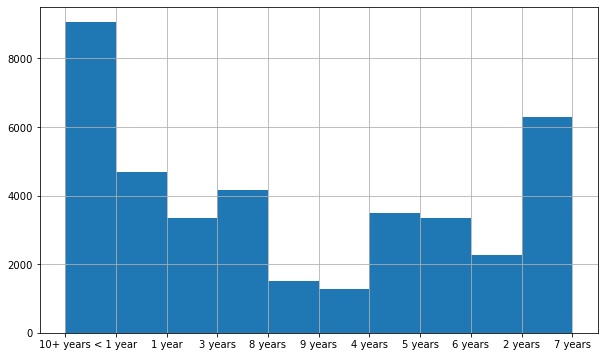

In [47]:
df["emp_length"].hist(figsize=(10,6));

Usunięcie niepotrzebnych suffixów/prefixów z kolumny

In [48]:
idx_to_replace = df[df["emp_length"].isna() == False]["emp_length"].str.strip(" year| years").index
df["emp_length"].iloc[idx_to_replace] = df[df["emp_length"].isna() == False]["emp_length"].str.strip("year|years")

In [49]:
(df["emp_length"].value_counts()/len(df))*100

10+     22.332108
< 1     11.591486
2       11.041507
3       10.284361
4        8.631958
1        8.232422
5        8.227489
6        5.608306
7        4.456557
8        3.741337
9        3.156830
Name: emp_length, dtype: float64

Zamiana symbolu <1, który reprezentuje krótki staż pracy mniejszy niż rok na 0

In [50]:
df["emp_length"].replace("< 1 ", 0, inplace=True)
(df["emp_length"].value_counts()/len(df))*100

10+     22.332108
0       11.591486
2       11.041507
3       10.284361
4        8.631958
1        8.232422
5        8.227489
6        5.608306
7        4.456557
8        3.741337
9        3.156830
Name: emp_length, dtype: float64

Zamiana symbolu 10+, który reprezentuje staż pracy dłuższy niż 10 lat na 10

In [51]:
df["emp_length"].replace("10+ ", 10, inplace=True)

In [52]:
(df["emp_length"].value_counts()/len(df))*100

10    22.332108
0     11.591486
2     11.041507
3     10.284361
4      8.631958
1      8.232422
5      8.227489
6      5.608306
7      4.456557
8      3.741337
9      3.156830
Name: emp_length, dtype: float64

Wypełnienie brakujących wartości jako staż pracy 0

In [53]:
# Filling missing values with 0
df["emp_length"].fillna(0, inplace = True)

In [54]:
df["emp_length"].isna().sum()

0

In [55]:
(df["emp_length"].value_counts()/len(df))*100

10    22.332108
0     14.287124
2     11.041507
3     10.284361
4      8.631958
1      8.232422
5      8.227489
6      5.608306
7      4.456557
8      3.741337
9      3.156830
Name: emp_length, dtype: float64

In [56]:
df["emp_length"].dtype

dtype('O')

In [57]:
df["emp_length"] = df["emp_length"].astype("int64")

In [58]:
df["emp_length"].dtype

dtype('int64')

In [59]:
feature_desc('desc')

LoanStatNew                                Description
15        desc  Loan description provided by the borrower

In [60]:
pd.DataFrame(df["desc"].value_counts())

desc
                                                                                                                                                                                                                                                                                                                                                                        212
Debt Consolidation                                                                                                                                                                                                                                                                                                                                                       10
Camping Membership                                                                                                                                                                                                                                                                                                                                                        6
refinancing                                                                                                                                                                                                                                                                                                                                                               4
Personal Loan                                                                                                                                                                                                                                                                                                                                                             3
...                                                                                                                                                                                                                                                                                                                                                                     ...
  Borrower added on 11/21/11 > To repay credit card debts to save interest<br>                                                                                                                                                                                                                                                                                            1
This will help me straighten out my financial situation following an illness and death in the family that caused great hardship.                                                                                                                                                                                                                                          1
Need loan to landscape my property. I have credit with my bank but want to see what kind of rate you can offer.                                                                                                                                                                                                                                                           1
  Borrower added on 11/06/11 > I'm using my fund to payoff some credit cards. I have a stable job that pays well, and Ive never missed a payment, always scheduled a week early.<br/>the apr/interest rate on this loan is also alot better then my credit cards , so it'll actually be saving me money with a definate pay-off date!<br/><br/>Thanks in advance<br/>     1
Upon receipt of funding, I will consolidate several loans into one payment.  I have never had a late payment in 26 years of credit history and have a good FICA score.                                                                                                                                                                                             

Podział opisu podanego przez kredytobiorcę na 3 kategorie:

* long
* short
* missing

In [61]:
# Modifying data in 'desc' column: long description, short description
for item in df["desc"]:
    if pd.isna(item):
        continue
    elif len(item) > 100:
        df["desc"].replace(item, 'long', inplace=True)
    else:
        df["desc"].replace(item, 'short', inplace=True)

In [62]:
df["desc"].value_counts()/len(df)

short    0.618098
long     0.059955
Name: desc, dtype: float64

In [63]:
df["desc"].isna().sum()

13054

In [64]:
# Filling missing values with 'missing'
df["desc"].fillna('missing', inplace=True)

In [65]:
df["desc"].isna().sum()

0

In [66]:
df["desc"].value_counts()/len(df)

short      0.618098
missing    0.321947
long       0.059955
Name: desc, dtype: float64

In [67]:
feature_desc('title')

LoanStatNew                              Description
95       title  The loan title provided by the borrower

In [68]:
df["title"].value_counts()

Debt Consolidation                         2209
Debt Consolidation Loan                    1738
Personal Loan                               672
Consolidation                               526
debt consolidation                          515
                                           ... 
26 Years at My Job_Good Credit Borrower       1
Volvo S40 Refinance                           1
Post-grad school consolidation loan           1
Bill Consolidation Loan requested             1
HELP ME PAY OFF MY AMEX BLUE                  1
Name: title, Length: 20103, dtype: int64

In [69]:
df["purpose"].value_counts()

debt_consolidation    18968
credit_card            5206
other                  4122
home_improvement       3056
major_purchase         2211
small_business         1903
car                    1564
wedding                 961
medical                 717
moving                  598
house                   393
vacation                387
educational             357
renewable_energy        104
Name: purpose, dtype: int64

"title" similar to "purpose" --> drop title

In [70]:
df.drop("title", axis=1, inplace=True)

In [71]:
feature_desc('revol_util')

LoanStatNew  \
91  revol_util   

                                                                                                                   Description  
91  Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.

In [72]:
df["revol_util"].value_counts() # get rid of %

0%        1011
0.2%        63
63%         62
40.7%       62
0.1%        60
          ... 
77.63%       1
24.65%       1
0.05%        1
8.01%        1
4.85%        1
Name: revol_util, Length: 1099, dtype: int64

Usunięcie %

In [73]:
df["revol_util"] = df["revol_util"].str.rstrip('%')

In [74]:
df["revol_util"].value_counts()

0        1011
0.2        63
40.7       62
63         62
0.1        60
         ... 
34.89       1
57.56       1
25.74       1
37.63       1
11.63       1
Name: revol_util, Length: 1099, dtype: int64

In [75]:
df["revol_util"].fillna(df["revol_util"].median(), inplace=True)

In [76]:
df["revol_util"].isna().sum()

0

In [77]:
feature_desc('last_pymnt_d')

LoanStatNew                      Description
40  last_pymnt_d  Last month payment was received

In [78]:
df["last_pymnt_d"].isna().sum()

83

In [79]:
df["last_pymnt_d"].value_counts() # Future info --> drop

Mar-2013    1028
Dec-2014     946
May-2013     913
Feb-2013     870
Apr-2013     855
            ... 
Jan-2008       7
Feb-2017       6
Feb-2008       6
Apr-2017       1
Dec-2007       1
Name: last_pymnt_d, Length: 112, dtype: int64

In [80]:
df.drop("last_pymnt_d", axis=1, inplace=True)

In [81]:
feature_desc('last_credit_pull_d')

LoanStatNew                                           Description
36  last_credit_pull_d  The most recent month LC pulled credit for this loan

In [82]:
df["last_credit_pull_d"].value_counts() # Future info --> drop

Aug-2018    8920
Oct-2016    4031
Jul-2018    1174
Feb-2017     687
May-2018     675
            ... 
Jun-2008       1
Jul-2008       1
Jul-2007       1
May-2007       1
Dec-2007       1
Name: last_credit_pull_d, Length: 132, dtype: int64

In [83]:
df.drop("last_credit_pull_d", axis=1, inplace=True)

In [84]:
df["earliest_cr_line"].fillna(method='ffill', inplace=True)

In [85]:
# Checking if all missing values are filled
df.isna().sum().sum()

0

### Dropping columns with the same value throughout all rows

In [86]:
df.head()

loan_amnt  funded_amnt  funded_amnt_inv        term int_rate  installment  \
0       5000         5000           4975.0   36 months   10.65%       162.87   
1       2500         2500           2500.0   60 months   15.27%        59.83   
2       2400         2400           2400.0   36 months   15.96%        84.33   
3      10000        10000          10000.0   36 months   13.49%       339.31   
4       3000         3000           3000.0   60 months   12.69%        67.79   

  grade sub_grade  emp_length home_ownership  ...  last_fico_range_high  \
0     B        B2          10           RENT  ...                   739   
1     C        C4           0           RENT  ...                   499   
2     C        C5          10           RENT  ...                   739   
3     C        C1          10           RENT  ...                   604   
4     B        B5           1           RENT  ...                   684   

  last_fico_range_low policy_code application_type acc_now_delinq delinq_amnt  \
0                 735           1       Individual            0.0         0.0   
1                   0           1       Individual            0.0         0.0   
2                 735           1       Individual            0.0         0.0   
3                 600           1       Individual            0.0         0.0   
4                 680           1       Individual            0.0         0.0   

  pub_rec_bankruptcies hardship_flag disbursement_method debt_settlement_flag  
0                  0.0             N                Cash                    N  
1                  0.0             N                Cash                    N  
2                  0.0             N                Cash                    N  
3                  0.0             N                Cash                    N  
4                  0.0             N                Cash                    N  

[5 rows x 52 columns]

In [87]:
len(df)

40547

In [88]:
duplicated_col_to_drop = []
for label, content in df.items():
     if (len(df) - len(df[df[label].duplicated() == True][label])) == 1:
        duplicated_col_to_drop.append(label)

Lista kolumn, które zawierają takie same wartości we wszystkich wierszach:

In [89]:
duplicated_col_to_drop

['pymnt_plan',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'policy_code',
 'application_type',
 'acc_now_delinq',
 'delinq_amnt',
 'hardship_flag',
 'disbursement_method']

Wyświetlenie tych wartości:

In [90]:
pd.DataFrame(df[duplicated_col_to_drop].value_counts()).T

pymnt_plan                   n
initial_list_status          f
out_prncp                  0.0
out_prncp_inv              0.0
policy_code                  1
application_type    Individual
acc_now_delinq             0.0
delinq_amnt                0.0
hardship_flag                N
disbursement_method       Cash
0                        40547

In [91]:
df.drop(duplicated_col_to_drop, axis=1, inplace=True)

In [92]:
df.head()

loan_amnt  funded_amnt  funded_amnt_inv        term int_rate  installment  \
0       5000         5000           4975.0   36 months   10.65%       162.87   
1       2500         2500           2500.0   60 months   15.27%        59.83   
2       2400         2400           2400.0   36 months   15.96%        84.33   
3      10000        10000          10000.0   36 months   13.49%       339.31   
4       3000         3000           3000.0   60 months   12.69%        67.79   

  grade sub_grade  emp_length home_ownership  ...  total_rec_prncp  \
0     B        B2          10           RENT  ...          5000.00   
1     C        C4           0           RENT  ...           456.46   
2     C        C5          10           RENT  ...          2400.00   
3     C        C1          10           RENT  ...         10000.00   
4     B        B5           1           RENT  ...          3000.00   

  total_rec_int total_rec_late_fee recoveries collection_recovery_fee  \
0        863.16               0.00        0.0                    0.00   
1        435.17               0.00      122.9                    1.11   
2        605.67               0.00        0.0                    0.00   
3       2214.92              16.97        0.0                    0.00   
4       1066.91               0.00        0.0                    0.00   

  last_pymnt_amnt last_fico_range_high last_fico_range_low  \
0          171.62                  739                 735   
1          119.66                  499                   0   
2          649.91                  739                 735   
3          357.48                  604                 600   
4           67.30                  684                 680   

  pub_rec_bankruptcies  debt_settlement_flag  
0                  0.0                     N  
1                  0.0                     N  
2                  0.0                     N  
3                  0.0                     N  
4                  0.0                     N  

[5 rows x 42 columns]

### Dropping bad data columns & data format check

Przegląd całego zbioru danych poprzez wyświetlanie fragmentów:

In [93]:
df.iloc[:10, :10]

loan_amnt  funded_amnt  funded_amnt_inv        term int_rate  installment  \
0       5000         5000           4975.0   36 months   10.65%       162.87   
1       2500         2500           2500.0   60 months   15.27%        59.83   
2       2400         2400           2400.0   36 months   15.96%        84.33   
3      10000        10000          10000.0   36 months   13.49%       339.31   
4       3000         3000           3000.0   60 months   12.69%        67.79   
5       5000         5000           5000.0   36 months    7.90%       156.46   
6       7000         7000           7000.0   60 months   15.96%       170.08   
7       3000         3000           3000.0   36 months   18.64%       109.43   
8       5600         5600           5600.0   60 months   21.28%       152.39   
9       5375         5375           5350.0   60 months   12.69%       121.45   

  grade sub_grade  emp_length home_ownership  
0     B        B2          10           RENT  
1     C        C4           0           RENT  
2     C        C5          10           RENT  
3     C        C1          10           RENT  
4     B        B5           1           RENT  
5     A        A4           3           RENT  
6     C        C5           8           RENT  
7     E        E1           9           RENT  
8     F        F2           4            OWN  
9     B        B5           0           RENT

In [94]:
df.iloc[:10, 10:20]

annual_inc verification_status   issue_d  loan_status  \
0     24000.0            Verified  Dec-2011   Fully Paid   
1     30000.0     Source Verified  Dec-2011  Charged Off   
2     12252.0        Not Verified  Dec-2011   Fully Paid   
3     49200.0     Source Verified  Dec-2011   Fully Paid   
4     80000.0     Source Verified  Dec-2011   Fully Paid   
5     36000.0     Source Verified  Dec-2011   Fully Paid   
6     47004.0        Not Verified  Dec-2011   Fully Paid   
7     48000.0     Source Verified  Dec-2011   Fully Paid   
8     40000.0     Source Verified  Dec-2011  Charged Off   
9     15000.0            Verified  Dec-2011  Charged Off   

                                                                url     desc  \
0  https://lendingclub.com/browse/loanDetail.action?loan_id=1077501    short   
1  https://lendingclub.com/browse/loanDetail.action?loan_id=1077430    short   
2  https://lendingclub.com/browse/loanDetail.action?loan_id=1077175  missing   
3  https://lendingclub.com/browse/loanDetail.action?loan_id=1076863    short   
4  https://lendingclub.com/browse/loanDetail.action?loan_id=1075358    short   
5  https://lendingclub.com/browse/loanDetail.action?loan_id=1075269  missing   
6  https://lendingclub.com/browse/loanDetail.action?loan_id=1069639    short   
7  https://lendingclub.com/browse/loanDetail.action?loan_id=1072053    short   
8  https://lendingclub.com/browse/loanDetail.action?loan_id=1071795    short   
9  https://lendingclub.com/browse/loanDetail.action?loan_id=1071570    short   

              purpose zip_code addr_state    dti  
0         credit_card    860xx         AZ  27.65  
1                 car    309xx         GA   1.00  
2      small_business    606xx         IL   8.72  
3               other    917xx         CA  20.00  
4               other    972xx         OR  17.94  
5             wedding    852xx         AZ  11.20  
6  debt_consolidation    280xx         NC  23.51  
7                 car    900xx         CA   5.35  
8      small_business    958xx         CA   5.55  
9               other    774xx         TX  18.08

In [95]:
df.drop("url", axis=1, inplace=True)

In [96]:
df.iloc[:10, 19:30]

delinq_2yrs earliest_cr_line  fico_range_low  fico_range_high  \
0          0.0         Jan-1985             735              739   
1          0.0         Apr-1999             740              744   
2          0.0         Nov-2001             735              739   
3          0.0         Feb-1996             690              694   
4          0.0         Jan-1996             695              699   
5          0.0         Nov-2004             730              734   
6          0.0         Jul-2005             690              694   
7          0.0         Jan-2007             660              664   
8          0.0         Apr-2004             675              679   
9          0.0         Sep-2004             725              729   

   inq_last_6mths  open_acc  pub_rec  revol_bal revol_util  total_acc  \
0             1.0       3.0      0.0      13648       83.7        9.0   
1             5.0       3.0      0.0       1687        9.4        4.0   
2             2.0       2.0      0.0       2956       98.5       10.0   
3             1.0      10.0      0.0       5598         21       37.0   
4             0.0      15.0      0.0      27783       53.9       38.0   
5             3.0       9.0      0.0       7963       28.3       12.0   
6             1.0       7.0      0.0      17726       85.6       11.0   
7             2.0       4.0      0.0       8221       87.5        4.0   
8             2.0      11.0      0.0       5210       32.6       13.0   
9             0.0       2.0      0.0       9279       36.5        3.0   

    total_pymnt  
0   5863.155187  
1   1014.530000  
2   3005.666844  
3  12231.890000  
4   4066.908161  
5   5632.210000  
6  10137.840008  
7   3939.135294  
8    647.500000  
9   1484.590000

In [97]:
df.iloc[:10, 30:]

total_pymnt_inv  total_rec_prncp  total_rec_int  total_rec_late_fee  \
0          5833.84          5000.00         863.16                0.00   
1          1014.53           456.46         435.17                0.00   
2          3005.67          2400.00         605.67                0.00   
3         12231.89         10000.00        2214.92               16.97   
4          4066.91          3000.00        1066.91                0.00   
5          5632.21          5000.00         632.21                0.00   
6         10137.84          7000.00        3137.84                0.00   
7          3939.14          3000.00         939.14                0.00   
8           647.50           162.02         294.94                0.00   
9          1477.70           673.48         533.42                0.00   

   recoveries  collection_recovery_fee  last_pymnt_amnt  last_fico_range_high  \
0        0.00                     0.00           171.62                   739   
1      122.90                     1.11           119.66                   499   
2        0.00                     0.00           649.91                   739   
3        0.00                     0.00           357.48                   604   
4        0.00                     0.00            67.30                   684   
5        0.00                     0.00           161.03                   564   
6        0.00                     0.00          1313.76                   654   
7        0.00                     0.00           111.34                   689   
8      190.54                     2.09           152.39                   499   
9      277.69                     2.52           121.45                   504   

   last_fico_range_low  pub_rec_bankruptcies debt_settlement_flag  
0                  735                   0.0                    N  
1                    0                   0.0                    N  
2                  735                   0.0                    N  
3                  600                   0.0                    N  
4                  680                   0.0                    N  
5                  560                   0.0                    N  
6                  650                   0.0                    N  
7                  685                   0.0                    N  
8                    0                   0.0                    N  
9                  500                   0.0                    N

In [98]:
non_num_cols = []
for label, content in df.items():
    if not pd.api.types.is_numeric_dtype(content):
        non_num_cols.append(label)

In [99]:
non_num_cols

['term',
 'int_rate',
 'grade',
 'sub_grade',
 'home_ownership',
 'verification_status',
 'issue_d',
 'loan_status',
 'desc',
 'purpose',
 'zip_code',
 'addr_state',
 'earliest_cr_line',
 'revol_util',
 'debt_settlement_flag']

Usunięcie prefixów/suffixów zauważonych podczas powyższego przeglądu danych

In [100]:
df["term"] = df["term"].str.strip(' months')

In [101]:
df["term"].value_counts()

36    29745
60    10802
Name: term, dtype: int64

In [102]:
df["int_rate"] = df["int_rate"].str.strip('%')

In [103]:
df["int_rate"].value_counts()

 10.99    959
 13.49    832
 11.49    828
  7.51    787
  7.88    726
         ... 
 16.20      1
 22.64      1
 24.40      1
 17.72      1
 14.57      1
Name: int_rate, Length: 389, dtype: int64

In [104]:
list(df["grade"].value_counts().index)

['B', 'A', 'C', 'D', 'E', 'F', 'G']

In [105]:
for item in list(df["grade"].value_counts().index):
    df["sub_grade"] = df["sub_grade"].str.strip(item)

In [106]:
df["sub_grade"].value_counts()

4    8472
3    8380
5    8230
2    8079
1    7386
Name: sub_grade, dtype: int64

Rozdzielenie zmiennych zawierających datę na oddzielne kolumny reprezentujące miesiąc i rok

In [107]:
df["issue_d_month"] = df["issue_d"].str.split('-').str[0]
df["issue_d_year"] = df["issue_d"].str.split('-').str[1]

In [108]:
df["issue_d_month"].value_counts()

Dec    4505
Nov    4258
Oct    4010
Sep    3708
Aug    3577
Jul    3534
Jun    3350
May    3057
Apr    2899
Mar    2774
Jan    2461
Feb    2414
Name: issue_d_month, dtype: int64

In [109]:
df["issue_d_year"].value_counts()

2011    21721
2010    11806
2009     4845
2008     1811
2007      364
Name: issue_d_year, dtype: int64

In [110]:
df.drop("issue_d", axis=1, inplace=True)

In [111]:
df["zip_code"].value_counts()

100xx    608
945xx    549
112xx    521
606xx    509
070xx    476
        ... 
414xx      1
669xx      1
470xx      1
169xx      1
162xx      1
Name: zip_code, Length: 830, dtype: int64

In [112]:
df["zip_code"]= df["zip_code"].str.strip('xx')

In [113]:
df["zip_code"].value_counts()

100    608
945    549
112    521
606    509
070    476
      ... 
408      1
823      1
332      1
677      1
169      1
Name: zip_code, Length: 830, dtype: int64

In [114]:
df["earliest_cr_line"].value_counts()

Nov-1998    376
Oct-1999    370
Dec-1998    354
Oct-2000    351
Dec-1997    332
           ... 
Dec-1950      1
Dec-1965      1
Aug-1967      1
Jun-1968      1
Apr-1966      1
Name: earliest_cr_line, Length: 527, dtype: int64

In [115]:
df["earliest_cr_line_month"] = df["earliest_cr_line"].str.split('-').str[0]
df["earliest_cr_line_year"] = df["earliest_cr_line"].str.split('-').str[1]

In [116]:
df["earliest_cr_line_month"].value_counts()

Oct    4157
Dec    4141
Nov    4000
Sep    3660
Jan    3497
Aug    3372
Jul    3124
Jun    2992
May    2966
Feb    2944
Mar    2861
Apr    2833
Name: earliest_cr_line_month, dtype: int64

In [117]:
df.drop("earliest_cr_line", axis=1, inplace=True)

In [118]:
df["revol_util"].value_counts()

0        1011
0.2        63
40.7       62
63         62
0.1        60
         ... 
34.89       1
57.56       1
25.74       1
37.63       1
11.63       1
Name: revol_util, Length: 1100, dtype: int64

In [119]:
df["revol_util"].dtype

dtype('O')

In [120]:
df["revol_util"] = df["revol_util"].astype('float')

In [121]:
df["revol_util"].dtype

dtype('float64')

In [122]:
non_num_cols = []
for label, content in df.items():
    if not pd.api.types.is_numeric_dtype(content):
        non_num_cols.append(label)

In [123]:
non_num_cols

['term',
 'int_rate',
 'grade',
 'sub_grade',
 'home_ownership',
 'verification_status',
 'loan_status',
 'desc',
 'purpose',
 'zip_code',
 'addr_state',
 'debt_settlement_flag',
 'issue_d_month',
 'issue_d_year',
 'earliest_cr_line_month',
 'earliest_cr_line_year']

#### Check dtypes of columns and change if neccessary

In [124]:
def check_col_dtype(col):
    '''
    returns value_counts and dtype of given column
    '''
    return df[col].value_counts(), df[col].dtype

In [125]:
check_col_dtype(non_num_cols[1])

( 10.99    959
  13.49    832
  11.49    828
   7.51    787
   7.88    726
          ... 
  16.20      1
  22.64      1
  24.40      1
  17.72      1
  14.57      1
 Name: int_rate, Length: 389, dtype: int64,
 dtype('O'))

In [126]:
feature_desc(non_num_cols[1])

LoanStatNew                Description
34    int_rate  Interest Rate on the loan

In [127]:
df["int_rate"] = df["int_rate"].astype('float')

In [128]:
df["int_rate"].dtype

dtype('float64')

In [129]:
check_col_dtype(non_num_cols[10])

(CA    7206
 NY    3874
 FL    2944
 TX    2789
 NJ    1881
 PA    1562
 IL    1561
 GA    1434
 VA    1424
 MA    1368
 OH    1244
 MD    1078
 AZ     900
 WA     858
 CO     805
 NC     801
 CT     766
 MI     741
 MO     712
 MN     627
 NV     514
 SC     476
 WI     474
 AL     460
 OR     457
 LA     441
 KY     337
 OK     303
 KS     277
 UT     264
 AR     252
 DC     216
 RI     201
 NM     193
 WV     179
 HI     176
 NH     174
 DE     118
 MT      91
 WY      83
 AK      82
 SD      65
 VT      55
 MS      23
 TN      21
 IN      16
 NE       8
 IA       7
 ID       6
 ME       3
 Name: addr_state, dtype: int64,
 dtype('O'))

In [130]:
feature_desc(non_num_cols[10])

LoanStatNew                                                 Description
2  addr_state  The state provided by the borrower in the loan application

In [131]:
df["zip_code"] = df["zip_code"].astype('int64')

In [132]:
df["zip_code"].dtype

dtype('int64')

convert strings in df to upper case

In [133]:
for label, content in df.items():
    if pd.api.types.is_string_dtype(content):
        df[label] = df[label].str.upper()

In [134]:
df.head()

loan_amnt  funded_amnt  funded_amnt_inv term  int_rate  installment grade  \
0       5000         5000           4975.0   36     10.65       162.87     B   
1       2500         2500           2500.0   60     15.27        59.83     C   
2       2400         2400           2400.0   36     15.96        84.33     C   
3      10000        10000          10000.0   36     13.49       339.31     C   
4       3000         3000           3000.0   60     12.69        67.79     B   

  sub_grade  emp_length home_ownership  ...  collection_recovery_fee  \
0         2          10           RENT  ...                     0.00   
1         4           0           RENT  ...                     1.11   
2         5          10           RENT  ...                     0.00   
3         1          10           RENT  ...                     0.00   
4         5           1           RENT  ...                     0.00   

  last_pymnt_amnt last_fico_range_high last_fico_range_low  \
0          171.62                  739                 735   
1          119.66                  499                   0   
2          649.91                  739                 735   
3          357.48                  604                 600   
4           67.30                  684                 680   

  pub_rec_bankruptcies  debt_settlement_flag issue_d_month  issue_d_year  \
0                  0.0                     N           DEC          2011   
1                  0.0                     N           DEC          2011   
2                  0.0                     N           DEC          2011   
3                  0.0                     N           DEC          2011   
4                  0.0                     N           DEC          2011   

   earliest_cr_line_month  earliest_cr_line_year  
0                     JAN                   1985  
1                     APR                   1999  
2                     NOV                   2001  
3                     FEB                   1996  
4                     JAN                   1996  

[5 rows x 43 columns]

### Outliers

Wyznaczenie outlierów za pomocą Z score

In [135]:
def get_Z_score(df):
    
    """
    returns:
    * outliers_Z_num : num of outliers for each column of the df
    * is_outlier : boolean values signifying whether the value of the df is an outlier
    * upper_limit, lower_minit : Z-score limits for each column of the df
    """
    numeric_cols = []
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            numeric_cols.append(label)
    

    upper_limit = {}
    lower_limit = {}
    outliers_Z_num = {}
    is_outlier = pd.DataFrame()
    for label in numeric_cols:
            upper_limit[label] = round((df[label].mean() + 3*df[label].std()), 3)
            lower_limit[label] = round((df[label].mean() - 3*df[label].std()), 3)
            is_outlier[label] = (df[label] < lower_limit[label]) | (df[label] > upper_limit[label])
            outliers_Z_num[label] = (df.loc[(df[label] >= upper_limit[label]) | (df[label] <= lower_limit[label]), label].count())
            
    return outliers_Z_num, is_outlier, upper_limit, lower_limit


In [136]:
outliers_Z_num, is_outlier, upper_limit, lower_limit = get_Z_score(df)

In [137]:
outliers_Z_num = pd.DataFrame(outliers_Z_num.values(), index=outliers_Z_num.keys(), columns=["num_of_outliers"])

% Outlierów dla poszczególnych zmiennych

In [138]:
round(outliers_Z_num/len(df)*100, 3)

num_of_outliers
loan_amnt                          1.788
funded_amnt                        1.509
funded_amnt_inv                    1.467
int_rate                           0.072
installment                        0.809
emp_length                         0.000
annual_inc                         0.747
zip_code                           0.000
dti                                0.000
delinq_2yrs                        2.572
fico_range_low                     0.007
fico_range_high                    0.007
inq_last_6mths                     1.556
open_acc                           0.969
pub_rec                            5.458
revol_bal                          1.803
revol_util                         0.000
total_acc                          0.925
total_pymnt                        1.534
total_pymnt_inv                    1.596
total_rec_prncp                    1.285
total_rec_int                      2.279
total_rec_late_fee                 2.158
recoveries                         0.991
collection_recovery_fee            0.767
last_pymnt_amnt                    2.558
last_fico_range_high               0.052
last_fico_range_low                1.860
pub_rec_bankruptcies               4.318

Podgląd limitów z Z score

In [139]:
upper_limit = pd.DataFrame(upper_limit.values(), index=upper_limit.keys(), columns = ["upper_limit"])
upper_limit.head()

upper_limit
loan_amnt          33548.060
funded_amnt        32468.324
funded_amnt_inv    31728.279
int_rate              23.256
installment          951.414

In [140]:
lower_limit = pd.DataFrame(lower_limit.values(), index=lower_limit.keys(), columns = ["lower_limit"])
lower_limit.head()

lower_limit
loan_amnt         -11149.306
funded_amnt       -10615.090
funded_amnt_inv   -11082.759
int_rate               0.896
installment         -302.681

In [141]:
len(outliers_Z_num) 

29

In [142]:
outliers_Z_num.index

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate',
       'installment', 'emp_length', 'annual_inc', 'zip_code', 'dti',
       'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'last_fico_range_high', 'last_fico_range_low',
       'pub_rec_bankruptcies'],
      dtype='object')

Podgląd rozkładów zmiennych z outlierami:

In [143]:
def plot_features_with_outliers(df):
    outliers_Z_num_idx = list(outliers_Z_num.index)

    fig, axs = plt.subplots(round(len(outliers_Z_num)/2), 2, figsize = (15, 15*3))
    step=0
    for i in range(round(len(outliers_Z_num)/2)):

        if i<round(len(outliers_Z_num)/2):
            df[outliers_Z_num_idx[i+step]].hist(ax=axs[i,0])
            axs[i,0].set_title(outliers_Z_num_idx[i+step])
            df[outliers_Z_num_idx[i+step+1]].hist(ax=axs[i,1])
            axs[i,1].set_title(outliers_Z_num_idx[i+step+1])
            step +=1
        else:
            df[outliers_Z_num_idx[i]].hist(ax=axs[i,0])
            axs[i,0].set_title(outliers_Z_num_idx[i])
            df[outliers_Z_num_idx[i+1]].hist(ax=axs[i,1])
            axs[i,1].set_title(outliers_Z_num_idx[i+1])
    plt.tight_layout
    plt.show()

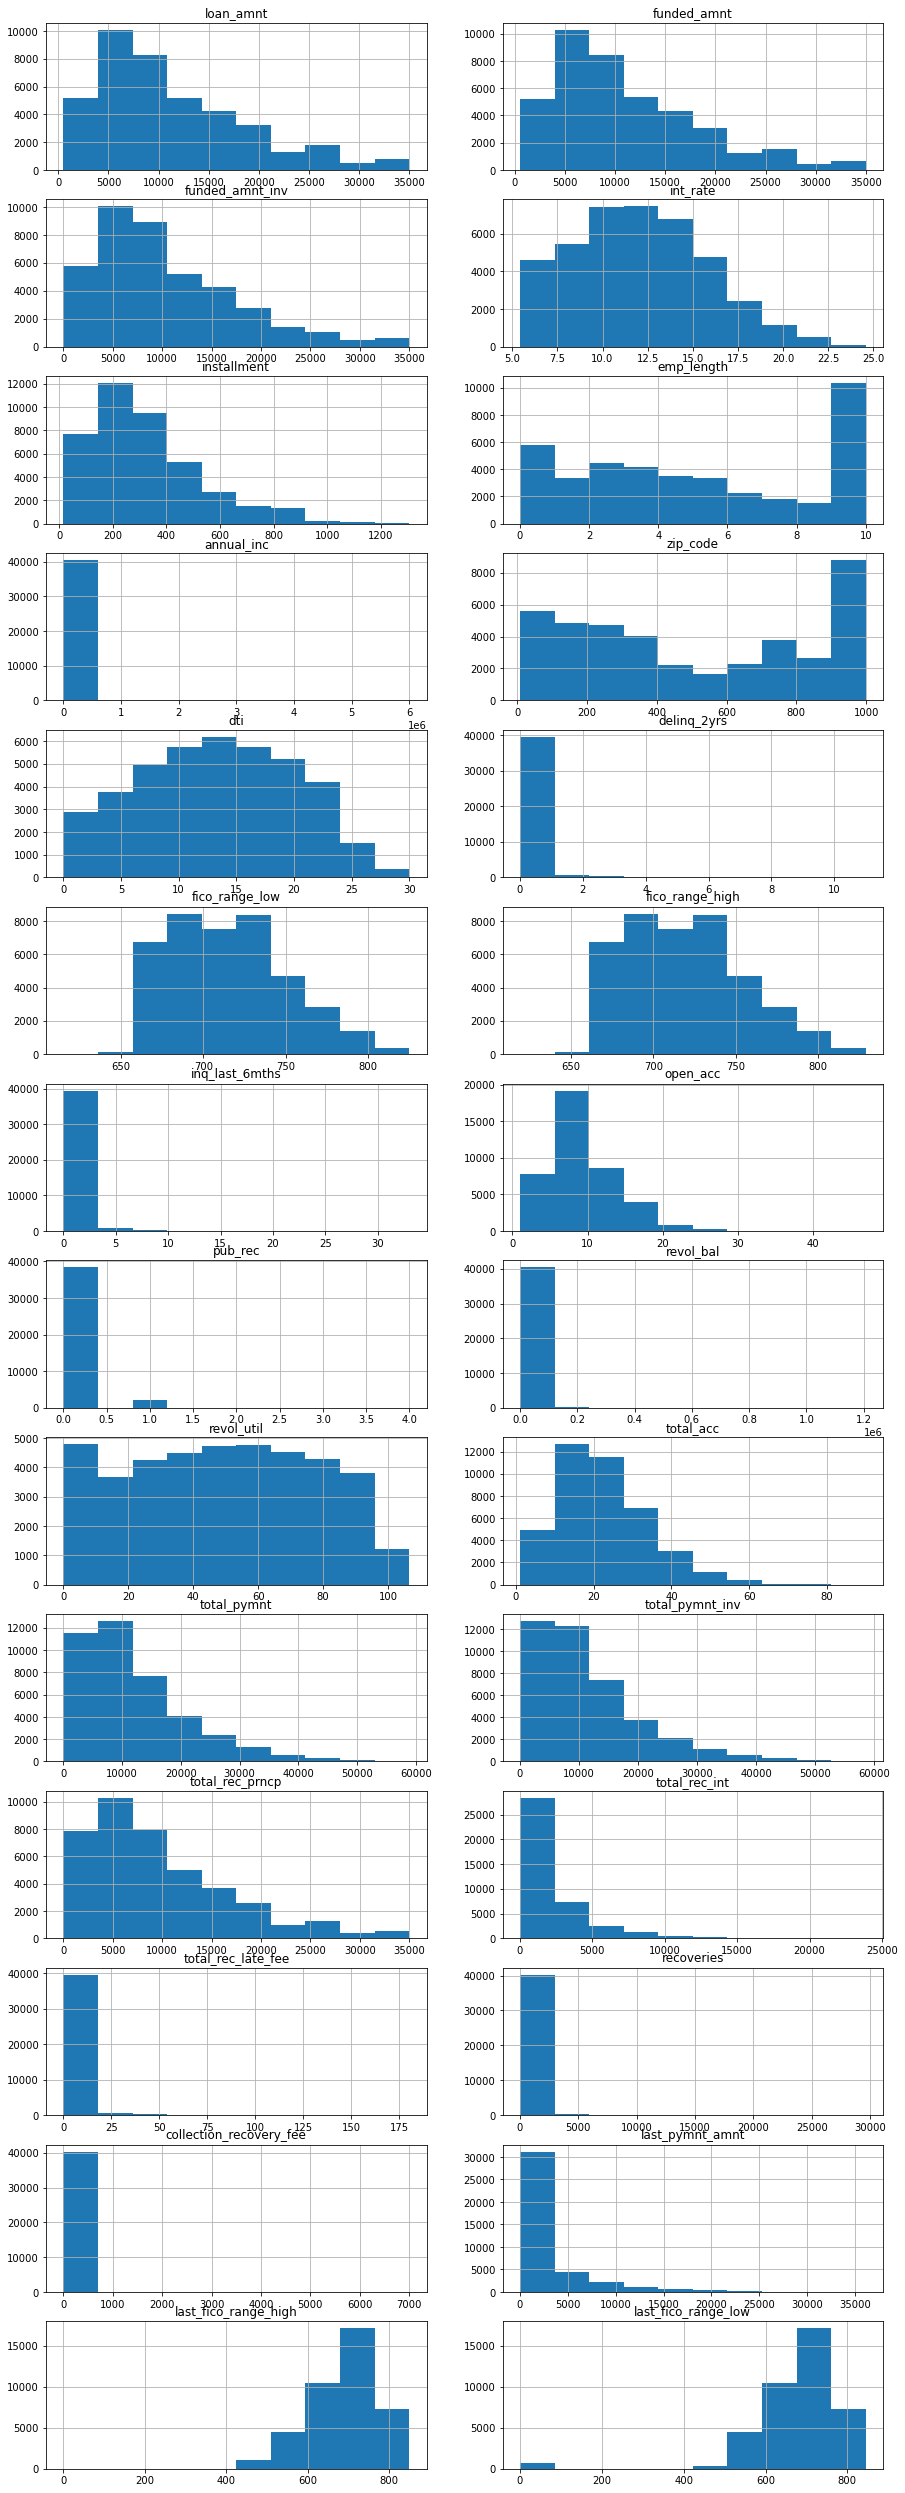

In [144]:
# Before handling outliers
plot_features_with_outliers(df)

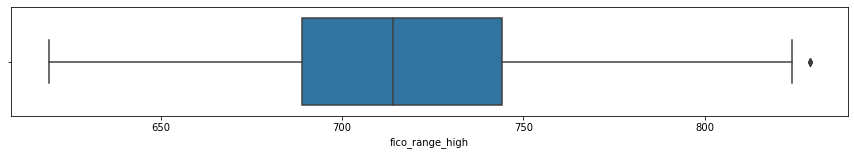

In [145]:
plt.figure(figsize=(15,2))
sns.boxplot(df["fico_range_high"]);

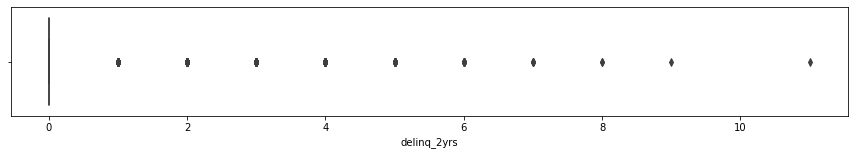

In [146]:
plt.figure(figsize=(15,2))
sns.boxplot(df["delinq_2yrs"]);

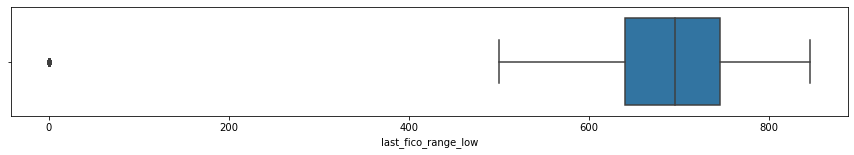

In [147]:
plt.figure(figsize=(15,2))
sns.boxplot(df["last_fico_range_low"]);

Przykładowe boxploty, czarne punkty oznaczają outliery, w przypadku 'delinq_2yrs' wdoczna bardzo duża ilość, która może wprowadzać zakłócenia podczas modelowania

#### Filling outliers

In [148]:
df_tmp = df.copy()

In [149]:
outliers_to_fill = list(outliers_Z_num.index)

#### Filling outliers with median

In [150]:
for label in outliers_to_fill:
    outliers = df_tmp[is_outlier[label]][label]
    for i in outliers.index:
        df_tmp[label].iloc[i] = df_tmp[label].median()

In [151]:
outliers_Z_num_2, is_outlier, upper_limit, lower_limit = get_Z_score(df_tmp)
outliers_Z_num_2 = pd.DataFrame(outliers_Z_num_2.values(), index=outliers_Z_num_2.keys())
outliers_Z_num_2 = round(outliers_Z_num_2, 3)

outliers_Z_before_after = outliers_Z_num.merge(outliers_Z_num_2, left_index=True, right_index=True)
outliers_Z_before_after.columns = ["Z_score", "Z_score_after_filling"]
round(outliers_Z_before_after/len(df_tmp)*100, 2) # %

Z_score  Z_score_after_filling
loan_amnt                   1.79                   0.23
funded_amnt                 1.51                   0.19
funded_amnt_inv             1.47                   0.87
int_rate                    0.07                   0.02
installment                 0.81                   0.43
emp_length                  0.00                   0.00
annual_inc                  0.75                   1.78
zip_code                    0.00                   0.00
dti                         0.00                   0.00
delinq_2yrs                 2.57                   8.37
fico_range_low              0.01                   0.00
fico_range_high             0.01                   0.00
inq_last_6mths              1.56                   1.24
open_acc                    0.97                   0.37
pub_rec                     5.46                 100.00
revol_bal                   1.80                   2.18
revol_util                  0.00                   0.00
total_acc                   0.92                   0.26
total_pymnt                 1.53                   0.93
total_pymnt_inv             1.60                   1.01
total_rec_prncp             1.28                   0.82
total_rec_int               2.28                   2.35
total_rec_late_fee          2.16                   3.28
recoveries                  0.99                   2.46
collection_recovery_fee     0.77                   1.38
last_pymnt_amnt             2.56                   2.73
last_fico_range_high        0.05                   0.00
last_fico_range_low         1.86                   0.00
pub_rec_bankruptcies        4.32                 100.00

Lista zmiennych, dla których po wypełnieniu zwiększyła się ilość outlierów

In [152]:
round(outliers_Z_before_after[outliers_Z_before_after["Z_score_after_filling"]>outliers_Z_before_after["Z_score"]]/len(df)*100, 2)

Z_score  Z_score_after_filling
annual_inc                  0.75                   1.78
delinq_2yrs                 2.57                   8.37
pub_rec                     5.46                 100.00
revol_bal                   1.80                   2.18
total_rec_int               2.28                   2.35
total_rec_late_fee          2.16                   3.28
recoveries                  0.99                   2.46
collection_recovery_fee     0.77                   1.38
last_pymnt_amnt             2.56                   2.73
pub_rec_bankruptcies        4.32                 100.00

#### Check values if outliers increased

In [153]:
cols_to_check = outliers_Z_before_after[outliers_Z_before_after["Z_score_after_filling"]>outliers_Z_before_after["Z_score"]].index

Przywrócenie poprzednich wartości dla kolumn, w których wypełnienie outlierów pogorszyło dane

In [154]:
df_tmp[cols_to_check] = df[cols_to_check]

In [155]:
outliers_Z_num_2, is_outlier, upper_limit, lower_limit = get_Z_score(df_tmp)
outliers_Z_num_2 = pd.DataFrame(outliers_Z_num_2.values(), index=outliers_Z_num_2.keys())
outliers_Z_num_2 = round(outliers_Z_num_2, 3)

outliers_Z_before_after = outliers_Z_num.merge(outliers_Z_num_2, left_index=True, right_index=True)
outliers_Z_before_after.columns = ["Z_score", "Z_score_after_filling"]
round(outliers_Z_before_after/len(df_tmp)*100, 2) # %

Z_score  Z_score_after_filling
loan_amnt                   1.79                   0.23
funded_amnt                 1.51                   0.19
funded_amnt_inv             1.47                   0.87
int_rate                    0.07                   0.02
installment                 0.81                   0.43
emp_length                  0.00                   0.00
annual_inc                  0.75                   0.75
zip_code                    0.00                   0.00
dti                         0.00                   0.00
delinq_2yrs                 2.57                   2.57
fico_range_low              0.01                   0.00
fico_range_high             0.01                   0.00
inq_last_6mths              1.56                   1.24
open_acc                    0.97                   0.37
pub_rec                     5.46                   5.46
revol_bal                   1.80                   1.80
revol_util                  0.00                   0.00
total_acc                   0.92                   0.26
total_pymnt                 1.53                   0.93
total_pymnt_inv             1.60                   1.01
total_rec_prncp             1.28                   0.82
total_rec_int               2.28                   2.28
total_rec_late_fee          2.16                   2.16
recoveries                  0.99                   0.99
collection_recovery_fee     0.77                   0.77
last_pymnt_amnt             2.56                   2.56
last_fico_range_high        0.05                   0.00
last_fico_range_low         1.86                   0.00
pub_rec_bankruptcies        4.32                   4.32

In [156]:
df_tmp[cols_to_check[1]].value_counts()

0.0     36111
1.0      3393
2.0       711
3.0       226
4.0        65
5.0        22
6.0        11
7.0         4
8.0         2
9.0         1
11.0        1
Name: delinq_2yrs, dtype: int64

**Sprawdzenie problematycznych do wypełnienia zmiennych + ich opis**

In [157]:
feature_desc(cols_to_check[1])

LoanStatNew  \
13  delinq_2yrs   

                                                                                                     Description  
13  The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years

In [158]:
df_tmp[cols_to_check[2]].value_counts()

0.0    38334
1.0     2150
2.0       53
3.0        8
4.0        2
Name: pub_rec, dtype: int64

In [159]:
feature_desc("inq_last_6mths")

LoanStatNew  \
32  inq_last_6mths   

                                                                         Description  
32  The number of inquiries in past 6 months (excluding auto and mortgage inquiries)

In [160]:
df_tmp[cols_to_check[3]].value_counts()

0        1032
255        14
298        14
1          12
682        11
         ... 
32573       1
53067       1
15072       1
1874        1
27976       1
Name: revol_bal, Length: 22000, dtype: int64

In [161]:
feature_desc("pub_rec")

LoanStatNew                          Description
85     pub_rec  Number of derogatory public records

In [162]:
df_tmp[cols_to_check[4]].value_counts() # pidzał >1000 & <=1000

0.00       83
1196.57    26
514.52     19
1784.23    17
956.78     17
           ..
3323.55     1
4260.65     1
7584.27     1
3924.59     1
1189.30     1
Name: total_rec_int, Length: 35726, dtype: int64

In [163]:
feature_desc("total_rec_int")

LoanStatNew                Description
107  total_rec_int  Interest received to date

In [164]:
upper_limit["total_rec_int"], lower_limit["total_rec_int"]

(10111.668, -5594.179)

In [165]:
df_tmp[cols_to_check[5]].value_counts() # podział 0 i >0

0.000000     38327
15.000000       69
30.000000        8
45.000000        3
15.000000        2
             ...  
42.780000        1
14.976318        1
15.000000        1
24.060000        1
14.989205        1
Name: total_rec_late_fee, Length: 2130, dtype: int64

In [166]:
feature_desc("total_rec_late_fee")

LoanStatNew                 Description
108  total_rec_late_fee  Late fees received to date

In [167]:
df_tmp[cols_to_check[6]].value_counts() # podział 0 i >0

0.00       34188
0.30          14
1.80          11
1.20          10
0.96          10
           ...  
381.07         1
610.80         1
1672.92        1
274.13         1
1975.02        1
Name: recoveries, Length: 5058, dtype: int64

In [168]:
feature_desc("recoveries")

LoanStatNew                     Description
89  recoveries  post charge off gross recovery

In [169]:
df_tmp[cols_to_check[7]].value_counts() # podział 0 i >0

0.0000       36219
2.0000          15
1.2000          11
1.6000          10
2.0200           9
             ...  
9.0600           1
379.1700         1
5.5600           1
3.1939           1
5216.7400        1
Name: collection_recovery_fee, Length: 2897, dtype: int64

In [170]:
df_tmp[cols_to_check[8]].value_counts() # podział 0 i >0

0.00       87
200.00     19
100.00     17
50.00      17
150.00     13
           ..
6050.93     1
217.99      1
253.58      1
175.38      1
1360.20     1
Name: last_pymnt_amnt, Length: 35702, dtype: int64

In [171]:
df_tmp[cols_to_check[9]].value_counts() # podział 0 i >0

0.0    38796
1.0     1744
2.0        7
Name: pub_rec_bankruptcies, dtype: int64

Zamiana wybranych problematycznych do wypełnienia zmiennych na kategoryczne 0-1

In [172]:
# turn total_rec_int into 2 categories: >1000 & <=1000
df_tmp["total_rec_int"].iloc[df_tmp[df_tmp["total_rec_int"] <= 1000]["total_rec_int"].index] = 0
df_tmp["total_rec_int"].iloc[df_tmp[df_tmp["total_rec_int"] > 1000]["total_rec_int"].index] = 1

In [173]:
df_tmp["total_rec_int"].value_counts()

1.0    24709
0.0    15838
Name: total_rec_int, dtype: int64

In [174]:
df_tmp["total_rec_int"] = df_tmp["total_rec_int"].astype('int64')
df_tmp["total_rec_int"] = df_tmp["total_rec_int"].astype('category')

In [175]:
# change into categories 0,1
cols_to_check = [item for item in cols_to_check if item not in ["total_rec_int", "annual_inc"]]

for label in cols_to_check:
    df_tmp[label].iloc[df_tmp[df_tmp[label] != 0][label].index] = 1

In [176]:
df_tmp[cols_to_check[0]].value_counts()

0.0    36111
1.0     4436
Name: delinq_2yrs, dtype: int64

In [177]:
df_tmp[cols_to_check] = df_tmp[cols_to_check].astype('int64')
df_tmp[cols_to_check] = df_tmp[cols_to_check].astype('category')

In [178]:
df_tmp[cols_to_check[0]]

0        0
1        0
2        0
3        0
4        0
        ..
40542    1
40543    0
40544    0
40545    0
40546    0
Name: delinq_2yrs, Length: 40547, dtype: category
Categories (2, int64): [0, 1]

Ponowne sprawdzenie % outlierów

In [179]:
outliers_Z_num_2, is_outlier, upper_limit, lower_limit = get_Z_score(df_tmp)
outliers_Z_num_2 = pd.DataFrame(outliers_Z_num_2.values(), index=outliers_Z_num_2.keys())
outliers_Z_num_2 = round(outliers_Z_num_2, 3)

outliers_Z_before_after = outliers_Z_num.merge(outliers_Z_num_2, left_index=True, right_index=True)
outliers_Z_before_after.columns = ["Z_score", "Z_score_after_filling"]
outliers_Z_before_after = round(outliers_Z_before_after/len(df_tmp)*100, 2) # %
outliers_Z_before_after

Z_score  Z_score_after_filling
loan_amnt                1.79                   0.23
funded_amnt              1.51                   0.19
funded_amnt_inv          1.47                   0.87
int_rate                 0.07                   0.02
installment              0.81                   0.43
emp_length               0.00                   0.00
annual_inc               0.75                   0.75
zip_code                 0.00                   0.00
dti                      0.00                   0.00
fico_range_low           0.01                   0.00
fico_range_high          0.01                   0.00
inq_last_6mths           1.56                   1.24
open_acc                 0.97                   0.37
revol_util               0.00                   0.00
total_acc                0.92                   0.26
total_pymnt              1.53                   0.93
total_pymnt_inv          1.60                   1.01
total_rec_prncp          1.28                   0.82
last_fico_range_high     0.05                   0.00
last_fico_range_low      1.86                   0.00

Usunięcie rekordów jeśli zawierają >75% outlierów

In [180]:
outliers_to_delete_cols = outliers_Z_before_after[outliers_Z_before_after["Z_score_after_filling"]>=0.75].index

In [181]:
len(df_tmp)

40547

In [182]:
for label in outliers_to_delete_cols:
    outliers_to_delete = df_tmp[is_outlier[label]][label]
    df_tmp.drop(outliers_to_delete.index, axis=0, inplace=True)

In [183]:
len(df_tmp)

38993

Usunięto 3.83% rekordów w celu zmniejszenia ilości outlierów:

In [184]:
(len(df)-len(df_tmp))/len(df)*100 # percent of deleted rows

3.832589340765038

Ponowne sprawdzenie % outlierów w df

In [185]:
outliers_Z_num_2, is_outlier, upper_limit, lower_limit = get_Z_score(df_tmp)
outliers_Z_num_2 = pd.DataFrame(outliers_Z_num_2.values(), index=outliers_Z_num_2.keys())
outliers_Z_num_2 = round(outliers_Z_num_2, 3)

outliers_Z_before_after = outliers_Z_num.merge(outliers_Z_num_2, left_index=True, right_index=True)
outliers_Z_before_after.columns = ["Z_score", "Z_score_after_filling"]
outliers_Z_before_after = round(outliers_Z_before_after/len(df_tmp)*100, 2) # %
outliers_Z_before_after

Z_score  Z_score_after_filling
loan_amnt                1.86                   0.27
funded_amnt              1.57                   0.13
funded_amnt_inv          1.53                   0.25
int_rate                 0.07                   0.04
installment              0.84                   0.66
emp_length               0.00                   0.00
annual_inc               0.78                   1.88
zip_code                 0.00                   0.00
dti                      0.00                   0.00
fico_range_low           0.01                   0.00
fico_range_high          0.01                   0.00
inq_last_6mths           1.62                   0.00
open_acc                 1.01                   0.36
revol_util               0.00                   0.00
total_acc                0.96                   0.38
total_pymnt              1.60                   0.33
total_pymnt_inv          1.66                   0.43
total_rec_prncp          1.34                   0.25
last_fico_range_high     0.05                   0.00
last_fico_range_low      1.93                   0.00

Porównanie jak zmieniły się rozkłady po wypełnieniu outlierów

In [186]:
def plot_histograms_before_after_outliers(df1, df2):
    """
    df1 --> dataframe before handling outliers
    df2 --> dataframe after handling outliers
    """
    numeric_cols=[]
    
    for label, content in df2.items():
        if pd.api.types.is_numeric_dtype(content):
            numeric_cols.append(label)
    
    colors=['darkblue', 'lightblue']
    is_odd=0
    if (len(numeric_cols)/2)%2 != 0: is_odd=1
    
    
    fig, axs = plt.subplots(round(len(numeric_cols)/2)+is_odd, 2, figsize = (15, 15*3))
    step=0
    for i in range(round(len(numeric_cols)/2)):

        if i<round(len(numeric_cols)/2):
            axs[i,0].hist(df1[numeric_cols[i+step]], color = colors[0], label = 'before', alpha=0.5)
            axs[i,0].hist(df2[numeric_cols[i+step]], color = colors[1], label = 'after', alpha=0.5)
            axs[i,0].set_title(numeric_cols[i+step])
            axs[i,0].legend(loc='upper right')
            
            axs[i,1].hist(df1[numeric_cols[i+step+1]], color = colors[0], label = 'before', alpha=0.5)
            axs[i,1].hist(df2[numeric_cols[i+step+1]], color = colors[1], label = 'after', alpha=0.5)
            axs[i,1].set_title(numeric_cols[i+step+1])
            axs[i,1].legend(loc='upper right')
            
            step +=1
        else:
            axs[i,0].hist(df1[numeric_cols[i]], color = colors[0], label = 'before', alpha=0.5)
            axs[i,0].hist(df2[numeric_cols[i]], color = colors[1], label = 'after', alpha=0.5)
            axs[i,0].set_title(numeric_cols[i])
            axs[i,0].legend(loc='upper right')
            
            axs[i,1].hist(df1[numeric_cols[i+1]], color = colors[0], label = 'before', alpha=0.5)
            axs[i,1].hist(df2[numeric_cols[i+1]], color = colors[1], label = 'after', alpha=0.5)
            axs[i,1].set_title(numeric_cols[i+1])
            axs[i,1].legend(loc='upper right')
    
    if is_odd !=0:
        idx_last = round(len(numeric_cols)/2)
        axs[idx_last, 0].hist(df1[numeric_cols[idx_last*2]], color = colors[0], label = 'before', alpha=0.5)
        axs[idx_last, 0].hist(df2[numeric_cols[idx_last*2]], color = colors[1], label = 'after', alpha=0.5)
        axs[idx_last, 0].set_title(numeric_cols[idx_last*2])
        axs[idx_last, 0].legend(loc='upper right')          


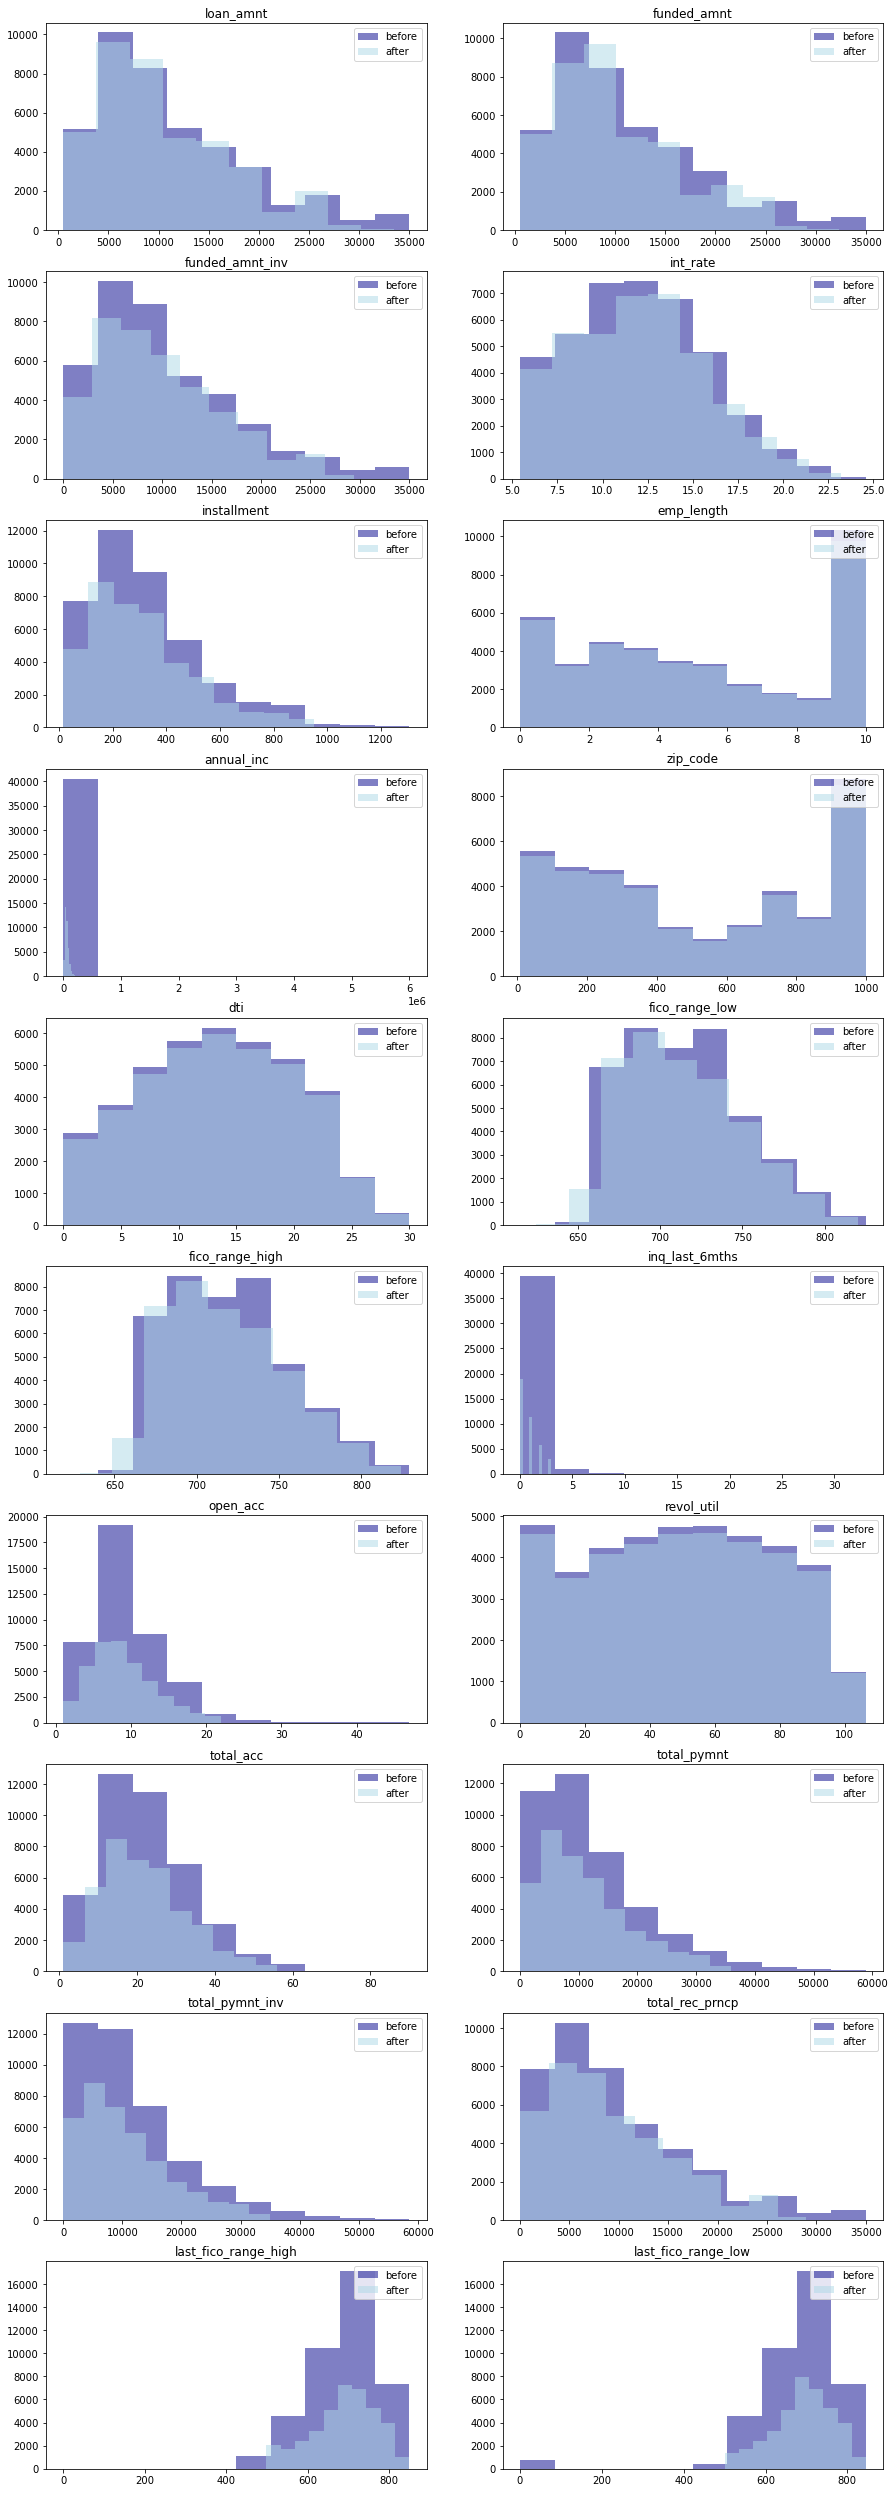

In [187]:
plot_histograms_before_after_outliers(df, df_tmp)

Rozkłady zmiennych po usunięciu outlierów nadal zachowują swoje zależności i zmienne te nie powinny już wprowadzać większych zaburzeń w dalszej części projektu

In [188]:
df_tmp.to_csv("data_preprocessed.csv")

In [189]:
df = df_tmp

In [190]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38993 entries, 0 to 40546
Data columns (total 43 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   loan_amnt                38993 non-null  int64   
 1   funded_amnt              38993 non-null  int64   
 2   funded_amnt_inv          38993 non-null  float64 
 3   term                     38993 non-null  object  
 4   int_rate                 38993 non-null  float64 
 5   installment              38993 non-null  float64 
 6   grade                    38993 non-null  object  
 7   sub_grade                38993 non-null  object  
 8   emp_length               38993 non-null  int64   
 9   home_ownership           38993 non-null  object  
 10  annual_inc               38993 non-null  float64 
 11  verification_status      38993 non-null  object  
 12  loan_status              38993 non-null  object  
 13  desc                     38993 non-null  object  
 14  purpos

# 4. EDA

EDA, czyli obszerna eksploracja danych (100pkt) Opisz wnioski płynące z każdego wykresu, swoje hipotezy poprzyj testami statystycznymi takimi jak np. t-test lub Chi-square. Dodatkowo odpowiedz na poniższe pytania:
1.	W jaki sposób wynik FICO wiąże się z prawdopodobieństwem spłacenia pożyczki przez pożyczkobiorcę?
2.	W jaki sposób wiek kredytowy wiąże się z prawdopodobieństwem niewykonania zobowiązania i czy ryzyko to jest niezależne lub związane z wynikiem FICO
3.	W jaki sposób status kredytu hipotecznego na dom wiąże się z prawdopodobieństwem niewypłacalności?
4.	W jaki sposób roczny dochód wiąże się z prawdopodobieństwem niewykonania zobowiązania?
5.	W jaki sposób historia zatrudnienia wiąże się z prawdopodobieństwem niewykonania zobowiązania?
6.	Jak wielkość żądanej pożyczki jest powiązana z prawdopodobieństwem niewykonania zobowiązania?


**Analiza ważności zmiennych i ich selekcja wykonana w dalszej części (po OneHotEncoder) za pomocą Mutual Score Info**

In [191]:
df.head()

loan_amnt  funded_amnt  funded_amnt_inv term  int_rate  installment grade  \
0       5000         5000           4975.0   36     10.65       162.87     B   
1       2500         2500           2500.0   60     15.27        59.83     C   
2       2400         2400           2400.0   36     15.96        84.33     C   
3      10000        10000          10000.0   36     13.49       339.31     C   
4       3000         3000           3000.0   60     12.69        67.79     B   

  sub_grade  emp_length home_ownership  ...  collection_recovery_fee  \
0         2          10           RENT  ...                        0   
1         4           0           RENT  ...                        1   
2         5          10           RENT  ...                        0   
3         1          10           RENT  ...                        0   
4         5           1           RENT  ...                        0   

  last_pymnt_amnt last_fico_range_high last_fico_range_low  \
0               1                  739                 735   
1               1                  499                 695   
2               1                  739                 735   
3               1                  604                 600   
4               1                  684                 680   

  pub_rec_bankruptcies  debt_settlement_flag issue_d_month  issue_d_year  \
0                    0                     N           DEC          2011   
1                    0                     N           DEC          2011   
2                    0                     N           DEC          2011   
3                    0                     N           DEC          2011   
4                    0                     N           DEC          2011   

  earliest_cr_line_month  earliest_cr_line_year  
0                    JAN                   1985  
1                    APR                   1999  
2                    NOV                   2001  
3                    FEB                   1996  
4                    JAN                   1996  

[5 rows x 43 columns]

Niezbliansowane dane - większość próbek dla klasy "Fully paid", co należy uwzględnić przy modelowaniu - wykorzystać oversampling/undersampling lub dobranie odpowiednich wag w klasyfikatorze

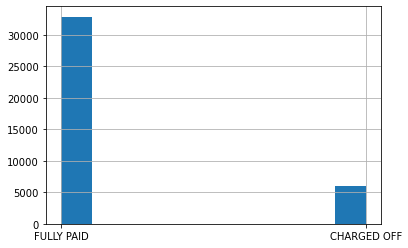

In [192]:
df["loan_status"].hist();

Zamiana zmiennej objaśnianej na wartości binarne:

* Fully paid - 1
* Charged off - 0

In [193]:
df["loan_status"].replace("FULLY PAID", 1, inplace=True)
df["loan_status"].replace("CHARGED OFF", 0, inplace=True)

In [194]:
df["loan_status"] = df["loan_status"].astype('category')

Zależność pomiędzy długością opisu podanego przez kredytobiorcę od spłacalności kredytu

In [195]:
desc_df = pd.crosstab(df["loan_status"], df["desc"])
desc_df

desc         LONG  MISSING  SHORT
loan_status                      
0             674     1824   3588
1            1617    10727  20563

In [196]:
desc_df.loc[1] = desc_df.loc[1]/df["loan_status"].value_counts()[0]*100
desc_df.loc[0] = desc_df.loc[0]/df["loan_status"].value_counts()[1]*100

In [197]:
desc_df # w %

desc              LONG    MISSING      SHORT
loan_status                                 
0            11.074597  29.970424  58.954979
1             4.913848  32.597927  62.488224

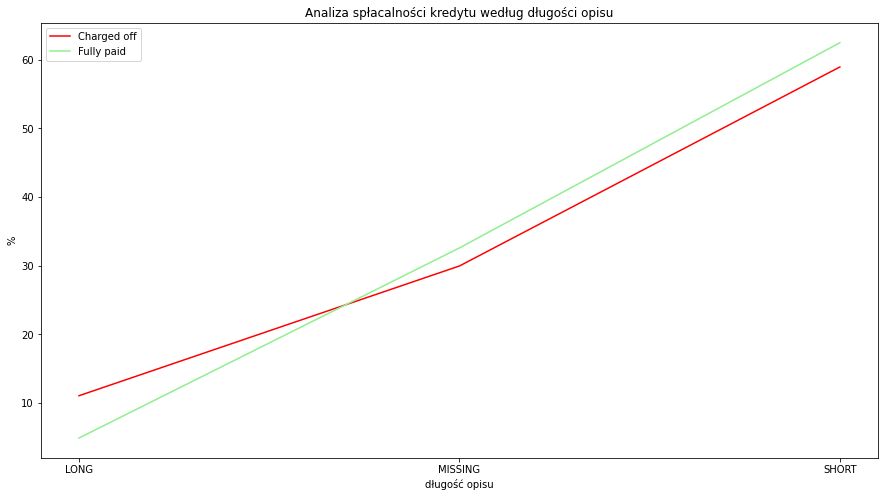

In [198]:
plt.figure(figsize=(15,8))
plt.plot(desc_df.loc[0], color='red');
plt.plot(desc_df.loc[1], color='lightgreen');
plt.title("Analiza spłacalności kredytu według długości opisu");
plt.xlabel("długość opisu");
plt.ylabel("%");
plt.legend(["Charged off", "Fully paid"]);

* W obu przypadkach największy odsetek kredytobiorców stosuje krótki opis
* W przypadku osób, które spłacą kredytu, prawie 3-krotnie większy odestek kredytobiorców stosuje długi opis pożyczki

In [199]:
# df.info()

**5. W jaki sposób historia zatrudnienia wiąże się z prawdopodobieństwem niewykonania zobowiązania?**

In [200]:
num_fully_paid = df["loan_status"].value_counts()[0]
num_charged_off = df["loan_status"].value_counts()[1]

In [201]:
len(df)

38993

In [202]:
emp_length_df = pd.crosstab(df["loan_status"], df["emp_length"])

emp_length_df.loc[1] = round(emp_length_df.loc[1]/num_fully_paid*100, 2) # / przez wszyskie osoby, które spłaciły kredyt
emp_length_df.loc[0] = round(emp_length_df.loc[0]/num_charged_off*100, 2) # / przez wszyskie osoby, które nie spłaciły kredytu

emp_length_df # w % w stosunku do wszystkich osób należących do danej klasy [0,1]

emp_length      0     1      2      3     4     5     6     7     8     9   \
loan_status                                                                  
0            15.61  8.41  10.22   9.89  8.13  7.85  5.54  4.63  3.73  2.78   
1            14.24  8.24  11.31  10.46  8.80  8.28  5.61  4.43  3.73  3.24   

emp_length      10  
loan_status         
0            23.20  
1            21.66

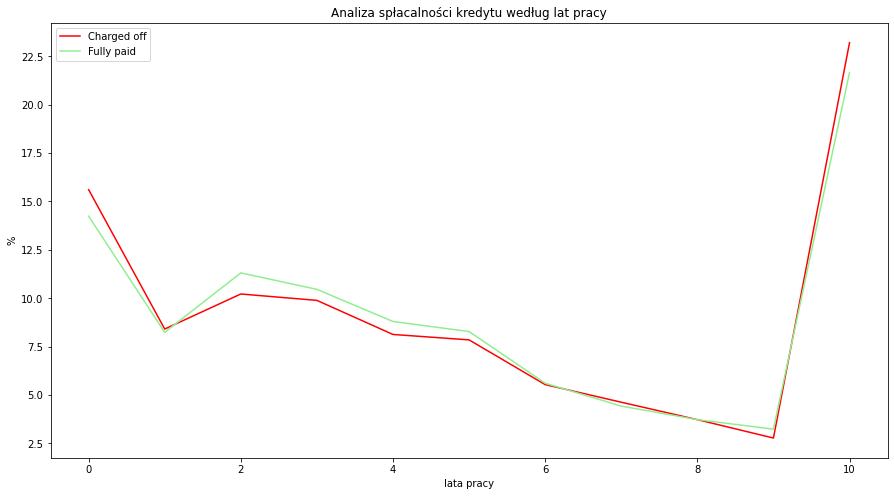

In [203]:
plt.figure(figsize=(15,8))
plt.plot(emp_length_df.loc[0], color='red');
plt.plot(emp_length_df.loc[1], color='lightgreen');
plt.title("Analiza spłacalności kredytu według lat pracy");
plt.xlabel("lata pracy");
plt.ylabel("%");
plt.legend(["Charged off", "Fully paid"]);

* Większy odestek osób, które nie spłaciły kredytu w porównaniu do osób, które spełniły zobowiązanie występuje u osób ze stażem pracy <1 rok oraz 10+ lat

* Największy odestek osób, które spełniły zobowiązanie w porównaniu do osób, które nie spłaciły kredytu występuje w przedziale 2-5 lat

Podsumowanie:

bliski zeru lub bardzo duży staż pracy wpływa negatywnie na prawdopodbieństwo spłacenia kredytu - do 1 grupy należą osoby dopiero zaczynające karierę, a więc mogą mieć trudności w terminowej spłącie kredytu, natomiast osoby pracujące 10+ lat mogą być osobami z innymi dodatkowymi problemami finansowymi, co również przekłada się na spłacalność

**3. W jaki sposób status kredytu hipotecznego na dom wiąże się z prawdopodobieństwem niewypłacalności?**

In [204]:
purpose_df = pd.crosstab(df["loan_status"], df["purpose"])

purpose_df.loc[1] = round(purpose_df.loc[1]/num_fully_paid*100, 2)
purpose_df.loc[0] = round(purpose_df.loc[0]/num_charged_off*100, 2)

purpose_df

purpose       CAR  CREDIT_CARD  DEBT_CONSOLIDATION  EDUCATIONAL  \
loan_status                                                       
0            2.78         9.73               48.18         1.33   
1            4.19        13.56               46.42         0.81   

purpose      HOME_IMPROVEMENT  HOUSE  MAJOR_PURCHASE  MEDICAL  MOVING  OTHER  \
loan_status                                                                    
0                        6.28   1.02            3.91     2.04    1.68  11.76   
1                        7.47   0.92            5.83     1.74    1.47   9.96   

purpose      RENEWABLE_ENERGY  SMALL_BUSINESS  VACATION  WEDDING  
loan_status                                                       
0                        0.33            8.38      0.92     1.68  
1                        0.25            3.87      0.99     2.54

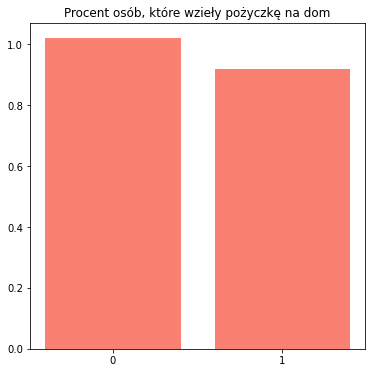

In [205]:
plt.figure(figsize=(6,6));
plt.bar(purpose_df["HOUSE"].index, height=purpose_df["HOUSE"], color="salmon")
plt.xticks([0,1]);
plt.title("Procent osób, które wzieły pożyczkę na dom");

In [206]:
purpose_df["HOUSE"]

loan_status
0    1.02
1    0.92
Name: HOUSE, dtype: float64

Wśród wszystkich osób, które nie spłaciły kredytu 1.02% jako cel określiło dom, w przypadku osób, które spłaciły kredyt nieco mniejsza liczba: 0.92, a więc osoby zaciągające pożyczkę na dom mają mniejsze szanse spłaty kredytu

**4. W jaki sposób roczny dochód wiąże się z prawdopodobieństwem niewykonania zobowiązania?**

In [207]:
income_df = pd.crosstab(df["loan_status"], df["annual_inc"])

income_df.loc[1] = round(income_df.loc[1]/num_fully_paid*100, 2)
income_df.loc[0] = round(income_df.loc[0]/num_charged_off*100, 2)

income_df

annual_inc   2000.00    3600.00    4000.00    4080.00    4200.00    4800.00    \
loan_status                                                                     
0                 0.02       0.02        0.0       0.02       0.00       0.02   
1                 0.00       0.00        0.0       0.00       0.01       0.01   

annual_inc   4888.00    5000.00    5500.00    6000.00    ...  249000.00  \
loan_status                                              ...              
0                  0.0       0.02        0.0       0.03  ...        0.0   
1                  0.0       0.00        0.0       0.01  ...        0.0   

annual_inc   249996.00  249999.96  250000.00  252000.00  254616.00  255000.00  \
loan_status                                                                     
0                 0.00        0.0       0.12        0.0       0.02        0.0   
1                 0.02        0.0       0.11        0.0       0.00        0.0   

annual_inc   258000.00  259000.00  260000.00  
loan_status                                   
0                  0.0        0.0       0.00  
1                  0.0        0.0       0.02  

[2 rows x 5142 columns]

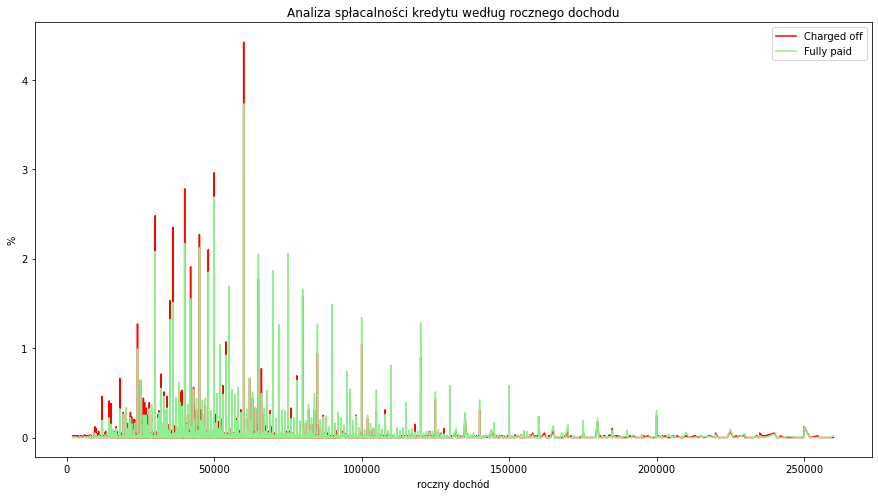

In [208]:
plt.figure(figsize=(15,8))
plt.plot(income_df.loc[0], color='red');
plt.plot(income_df.loc[1], color='lightgreen');
plt.title("Analiza spłacalności kredytu według rocznego dochodu");
plt.xlabel("roczny dochód");
plt.ylabel("%");
plt.legend(["Charged off", "Fully paid"]);

* Największe prawdopodbieństwo nie spłacenia pożyczki mają osoby z niskim rocznym dochodem - poniżej ok 70 000 zł
* Większość, które zaciągają kredyt ma roczny dochód poniżej 150 000 zł

Podsumowanie:
Osoby z mniejszym rocznym dochodem mają mniejsze szanse na spłatę pożyczki

**6.Jak wielkość żądanej pożyczki jest powiązana z prawdopodobieństwem niewykonania zobowiązania?**

In [209]:
amount_df = pd.crosstab(df["loan_status"], df["loan_amnt"])

amount_df.loc[1] = round(amount_df.loc[1]/num_fully_paid*100, 2)
amount_df.loc[0] = round(amount_df.loc[0]/num_charged_off*100, 2)

amount_df

loan_amnt    500    600    700    725    750    800    900    925    950    \
loan_status                                                                  
0             0.02   0.02   0.02    0.0    0.0   0.02   0.02   0.02    0.0   
1             0.02   0.00   0.00    0.0    0.0   0.00   0.00   0.00    0.0   

loan_amnt    1000   ...  32350  32400  32500  32525  32775  32875  33000  \
loan_status         ...                                                    
0             0.84  ...   0.03   0.02    0.0    0.0    0.0   0.00   0.00   
1             0.77  ...   0.00   0.00    0.0    0.0    0.0   0.01   0.02   

loan_amnt    33250  33425  33500  
loan_status                       
0              0.0   0.02    0.0  
1              0.0   0.00    0.0  

[2 rows x 854 columns]

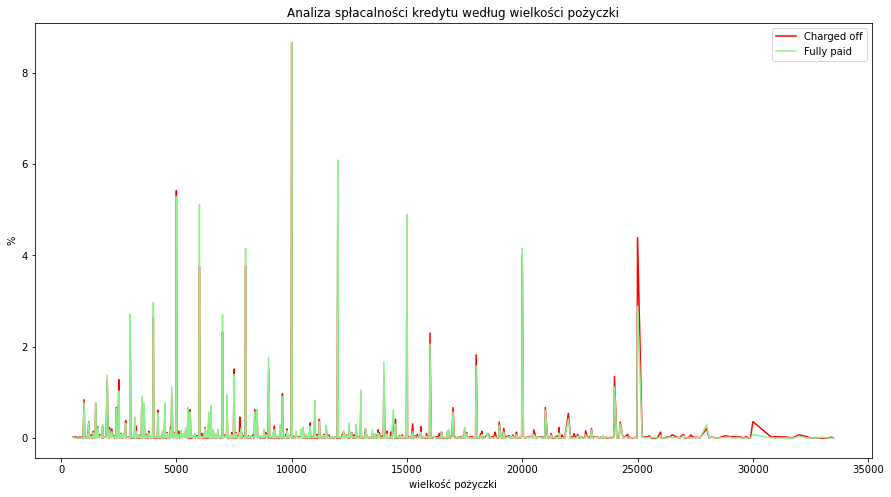

In [210]:
plt.figure(figsize=(15,8))
plt.plot(amount_df.loc[0], color='red');
plt.plot(amount_df.loc[1], color='lightgreen');
plt.title("Analiza spłacalności kredytu według wielkości pożyczki");
plt.xlabel("wielkość pożyczki");
plt.ylabel("%");
plt.legend(["Charged off", "Fully paid"]);

* Najniższa szansa na spłatę pożyczki występuje dla 25 000 zł
* Od ok 16 000 zł prawdpodobieństwo spłaty zmniejsza się

Podsumowanie: Zapożycznie na większe kwoty zmniejsza szanse na spłatę pożyczki

**Odpowiedzi do pytań 1 i 2 z EDA w części Feature Engineering - utworzona zostaje tam zmienna FICO potrzebna do analizy**

1.W jaki sposób wynik FICO wiąże się z prawdopodobieństwem spłacenia pożyczki przez pożyczkobiorcę?

2.W jaki sposób wiek kredytowy wiąże się z prawdopodobieństwem niewykonania zobowiązania i czy ryzyko to jest niezależne lub związane z wynikiem FICO


**Analiza wpływu zmiennej "grade" na spłacalność**

In [211]:
grade_df = pd.crosstab(df["loan_status"], df["grade"])

grade_df.loc[1] = round(grade_df.loc[1]/num_fully_paid*100, 2)
grade_df.loc[0] = round(grade_df.loc[0]/num_charged_off*100, 2)

grade_df

grade            A      B      C      D      E     F     G
loan_status                                               
0             9.74  23.69  23.55  20.72  13.59  6.23  2.48
1            28.17  31.30  19.99  12.26   5.83  1.92  0.52

In [212]:
feature_desc("grade")

LoanStatNew             Description
25       grade  LC assigned loan grade

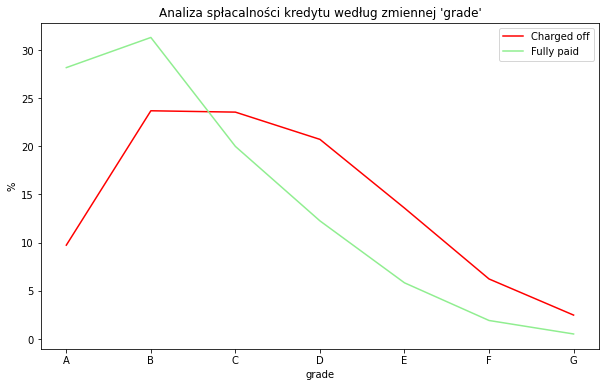

In [213]:
plt.figure(figsize=(10,6))
plt.plot(grade_df.loc[0], color='red');
plt.plot(grade_df.loc[1], color='lightgreen');
plt.title("Analiza spłacalności kredytu według zmiennej 'grade'");
plt.xlabel("grade");
plt.ylabel("%");
plt.legend(["Charged off", "Fully paid"]);

Osoby z 'grade' A oraz B wykazują większe prawdpodobieństwo spłaty kredytu, wraz ze spadkiem oceny znacząco pogarsza się prawdpodobieństwo spłacenia kredytu przez pożyczkobiorcę

### Correlation

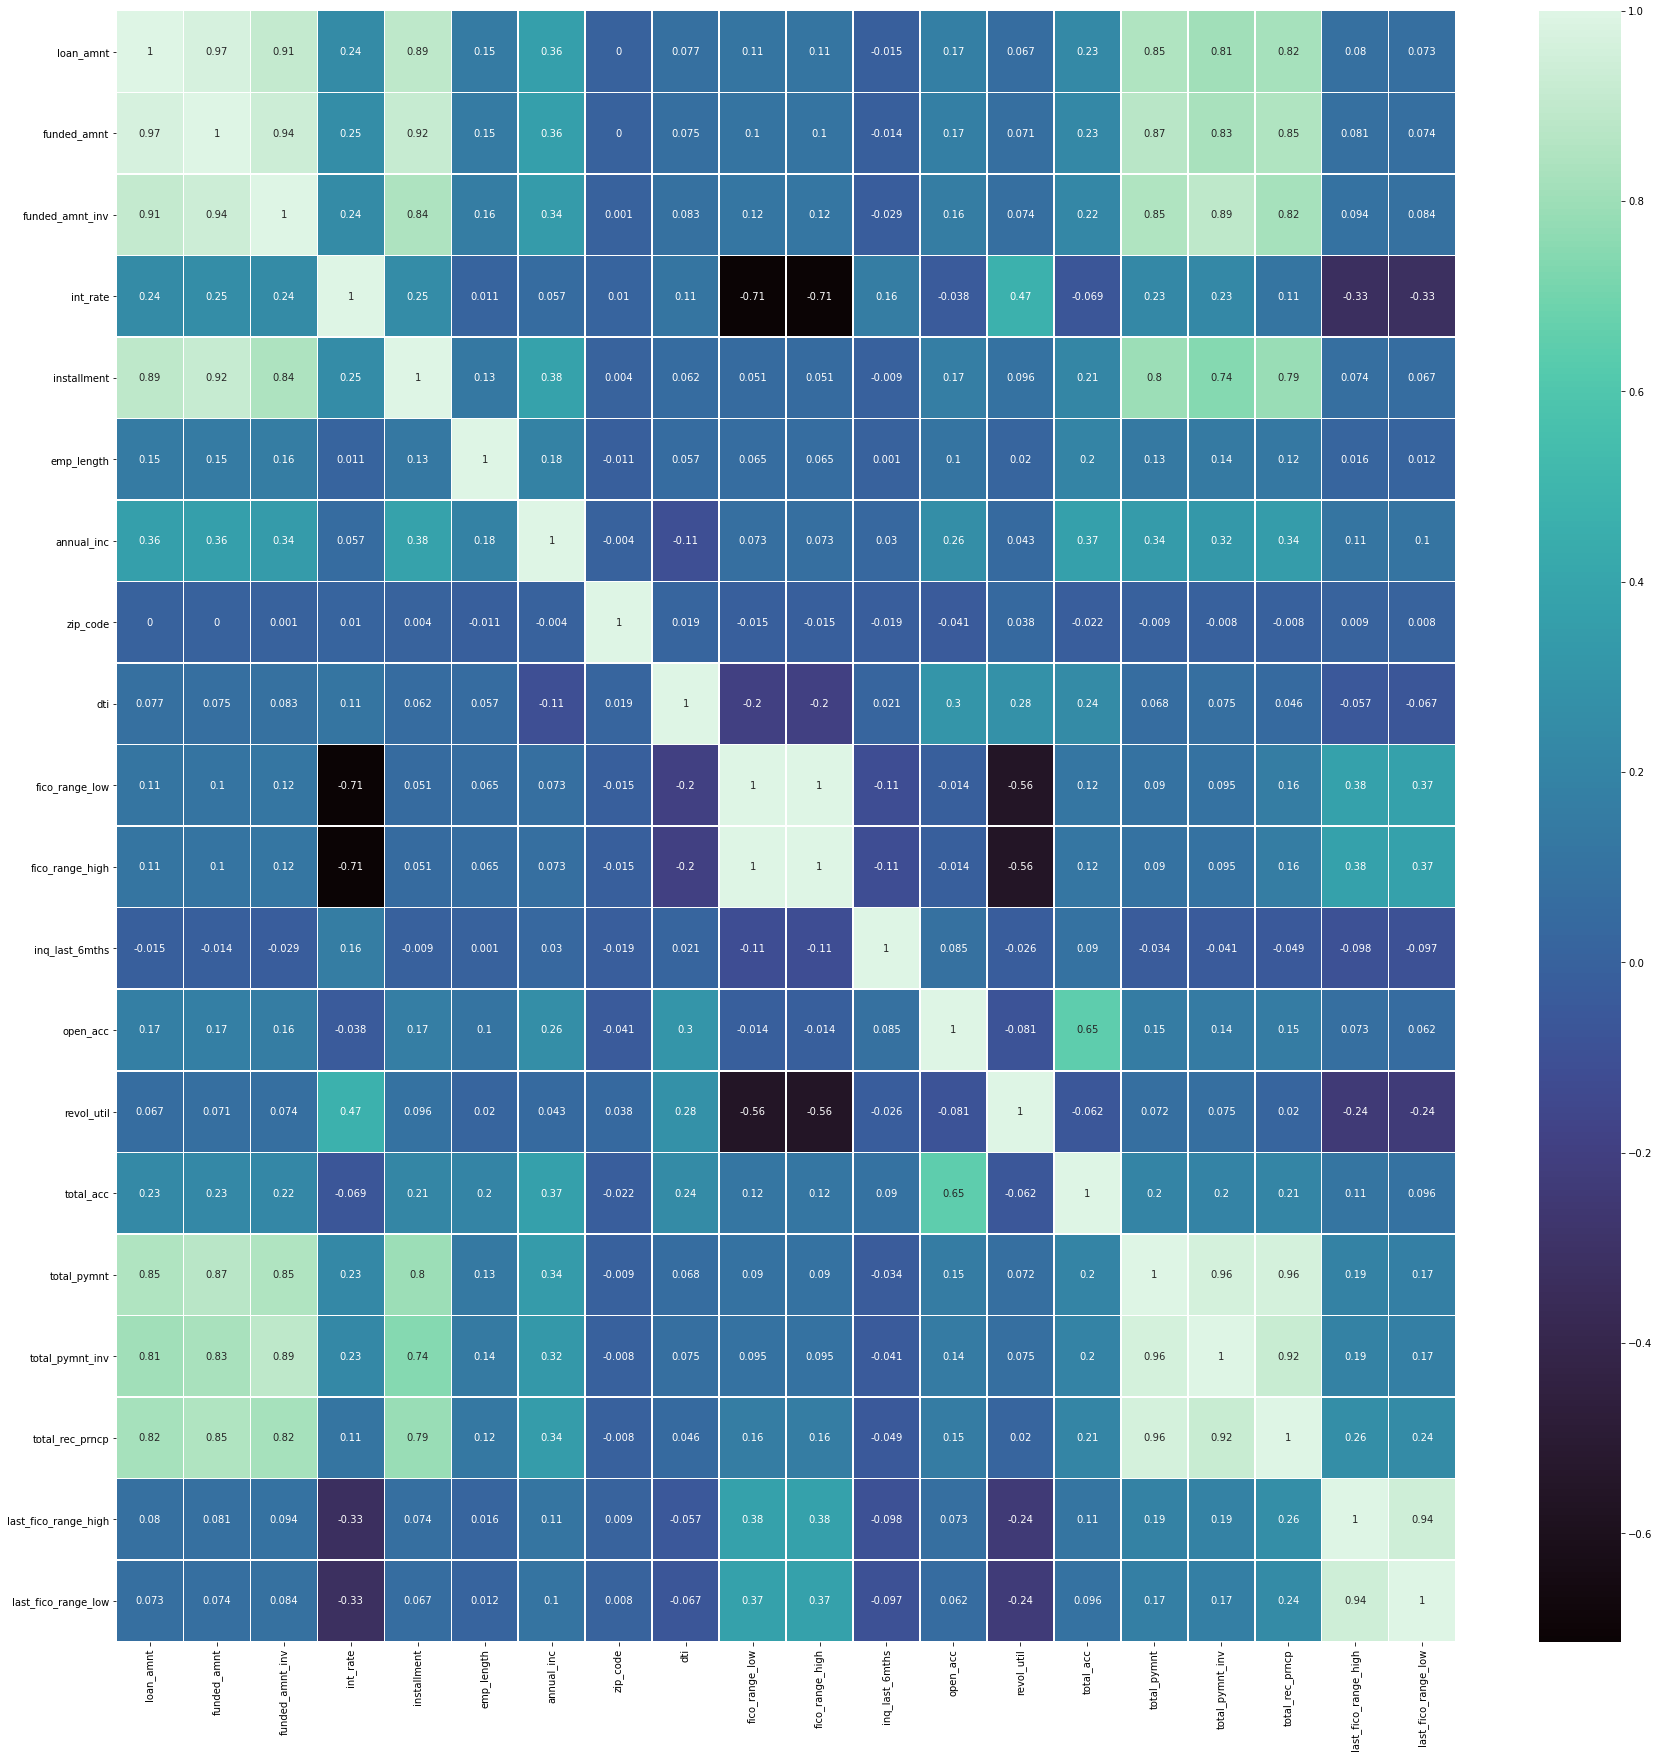

In [214]:
plt.figure(figsize=(30, 30));
sns.heatmap(round(df.corr(), 3), annot=True, linewidths=0.5, cmap = 'mako');

**Podgląd opisu zmiennych silnie skorelowanych** - następnie próba utworzenia nowych zmiennych z wykorzystaniem zmiennych silnie skorelowanych (w części Feature Engineering) aby wyeliminować dużą korelację zachowując przy tym część informacji jakie niosą te dane

In [215]:
feature_desc("fico_range_low")

LoanStatNew  \
22  fico_range_low   

                                                                     Description  
22  The lower boundary range the borrower’s FICO at loan origination belongs to.

In [216]:
feature_desc("fico_range_high")

LoanStatNew  \
21  fico_range_high   

                                                                     Description  
21  The upper boundary range the borrower’s FICO at loan origination belongs to.

In [217]:
feature_desc("revol_util")

LoanStatNew  \
91  revol_util   

                                                                                                                   Description  
91  Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.

In [218]:
feature_desc("int_rate")

LoanStatNew                Description
34    int_rate  Interest Rate on the loan

In [219]:
feature_desc("funded_amnt")

LoanStatNew  \
23  funded_amnt   

                                                       Description  
23  The total amount committed to that loan at that point in time.

In [220]:
feature_desc("funded_amnt_inv")

LoanStatNew  \
24  funded_amnt_inv   

                                                                     Description  
24  The total amount committed by investors for that loan at that point in time.

In [221]:
feature_desc("loan_amnt")

LoanStatNew  \
41   loan_amnt   

                                                                                                                                                                     Description  
41  The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.

In [222]:
feature_desc("installment")

LoanStatNew  \
33  installment   

                                                         Description  
33  The monthly payment owed by the borrower if the loan originates.

In [223]:
feature_desc("total_pymnt")

LoanStatNew                                        Description
105  total_pymnt  Payments received to date for total amount funded

In [224]:
feature_desc("total_pymnt_inv")

LoanStatNew  \
106  total_pymnt_inv   

                                                                   Description  
106  Payments received to date for portion of total amount funded by investors

In [225]:
feature_desc("total_rec_prncp")

LoanStatNew                 Description
109  total_rec_prncp  Principal received to date

In [226]:
feature_desc("total_acc")

LoanStatNew  \
99   total_acc   

                                                                 Description  
99  The total number of credit lines currently in the borrower's credit file

In [227]:
feature_desc("open_acc")

LoanStatNew                                                     Description
73    open_acc  The number of open credit lines in the borrower's credit file.

### EDA cd. - Feature engineering

3.	Feature Engineering – utwórz 20 nowych zmiennych (60 pkt)

**Adding feature #1**

Utworzenie nowej zmiennej o wartościach binarnych sygnalizujących czy earliest_cr_line ma datę przed 2000 r

**earliest_cr_line_before_2000** -> 1 if true, 0 if false

`earliest_cr_line` ->The month the borrower's earliest reported credit line was opened

In [228]:
df["earliest_cr_line_year"] = df["earliest_cr_line_year"].astype('int64')

In [229]:
 df["earliest_cr_line_year"].value_counts().index

Int64Index([2000, 1999, 1998, 2001, 1997, 1996, 1995, 1994, 2002, 2003, 2004,
            2005, 1993, 2006, 1992, 1990, 1991, 1989, 2007, 1988, 1987, 1986,
            1985, 1984, 1983, 1982, 1981, 1980, 2008, 1979, 1978, 1977, 1976,
            1975, 1973, 1974, 1972, 1970, 1971, 1969, 1968, 1967, 1963, 1966,
            1964, 1965, 1962, 1954, 1961, 1959, 1946, 1950, 1956],
           dtype='int64')

In [230]:
idx_to_fill = list(df[df["earliest_cr_line_year"]<2000]["earliest_cr_line_year"].index)

In [231]:
df["earliest_cr_line_before_2000"] = None
df["earliest_cr_line_before_2000"].loc[idx_to_fill] = 1
df["earliest_cr_line_before_2000"].fillna(0, inplace=True)
df["earliest_cr_line_before_2000"].value_counts()

1    24190
0    14803
Name: earliest_cr_line_before_2000, dtype: int64

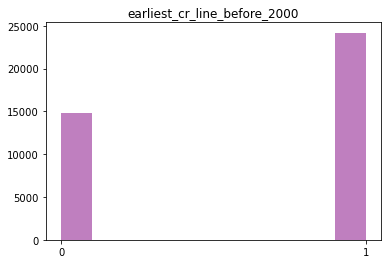

In [232]:
plt.hist(df["earliest_cr_line_before_2000"], color = "purple", alpha=0.5);
plt.title("earliest_cr_line_before_2000");
plt.xticks([0,1]);

**Adding feature #2**

Utworzenie nowej zmiennej określającej ilość lat od earliest_cr_line

**years_since_earliest_cr_line** -> issue_d_year - earliest_cr_line_year

`earliest_cr_line_year` -> The year the borrower's earliest reported credit line was opened

`issue_d_year` -> The year which the loan was funded

In [233]:
df["issue_d_year"] = df["issue_d_year"].astype('int64')

In [234]:
df["years_since_earliest_cr_line"] = df["issue_d_year"] - df["earliest_cr_line_year"]

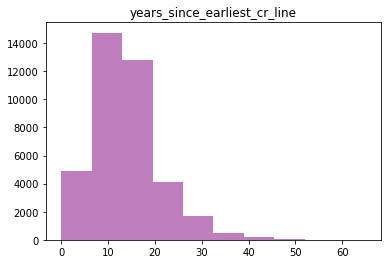

In [235]:
plt.hist(df["years_since_earliest_cr_line"], color = "purple", alpha=0.5);
plt.title("years_since_earliest_cr_line");

**Adding new feature #3**

Utworzenie zmiennej określającej FICO score według poniższych kryteriów:

fico_range_low & fico_range_high -> **FICO_rating**

* `800+ Exceptional` **->5**
* `740 - 799 Very Good`**->4**
* `670 - 739 Good`**->3**
* `580 - 669 Fair`**->2**
* `< 580 Poor`**->1**

Info: The higher the better

In [236]:
df.reset_index(inplace=True)

In [237]:
fico_1_idx = df[df["fico_range_low"]<580].index
fico_2_idx = df[(df["fico_range_low"]>=580) & (df["fico_range_high"]<=669)].index
fico_3_idx = df[(df["fico_range_low"]>=670) & (df["fico_range_high"]<=739)].index
fico_4_idx = df[(df["fico_range_low"]>=740) & (df["fico_range_high"]<=799)].index
fico_5_idx = df[df["fico_range_low"]>=800].index

In [238]:
df["FICO_rating"] = None

In [239]:
df[df["fico_range_low"]<580][["fico_range_low", "fico_range_high"]] # brak danych dla FICO 1 (Poor)

Empty DataFrame
Columns: [fico_range_low, fico_range_high]
Index: []

Utworzenie zmiennej przydzielającej odpowiedni wynik FICO:

In [240]:
for i, item in enumerate([fico_1_idx, fico_2_idx, fico_3_idx, fico_4_idx, fico_5_idx]):
    df["FICO_rating"].iloc[item] = i+1

In [241]:
df["FICO_rating"] = df["FICO_rating"].astype('int64')

In [242]:
df["FICO_rating"].value_counts()

3    25671
4     9523
2     3215
5      584
Name: FICO_rating, dtype: int64

Brak danych na tym zbiorze o wyniku FICO = 1

In [243]:
fico_1_idx # no data with fico rating 1 (Poor)

Int64Index([], dtype='int64')

In [244]:
df.drop(["fico_range_low", "fico_range_high"], axis=1, inplace=True)

**Cd. odpowiedzi na pytania z EDA:**

**1.W jaki sposób wynik FICO wiąże się z prawdopodobieństwem spłacenia pożyczki przez pożyczkobiorcę?**

In [245]:
FICO_df = pd.crosstab(df["loan_status"], df["FICO_rating"])

FICO_df.loc[1] = round(FICO_df.loc[1]/num_fully_paid*100, 2)
FICO_df.loc[0] = round(FICO_df.loc[0]/num_charged_off*100, 2)

FICO_df

FICO_rating      2      3      4     5
loan_status                           
0            14.89  71.25  13.34  0.53
1             7.02  64.83  26.47  1.68

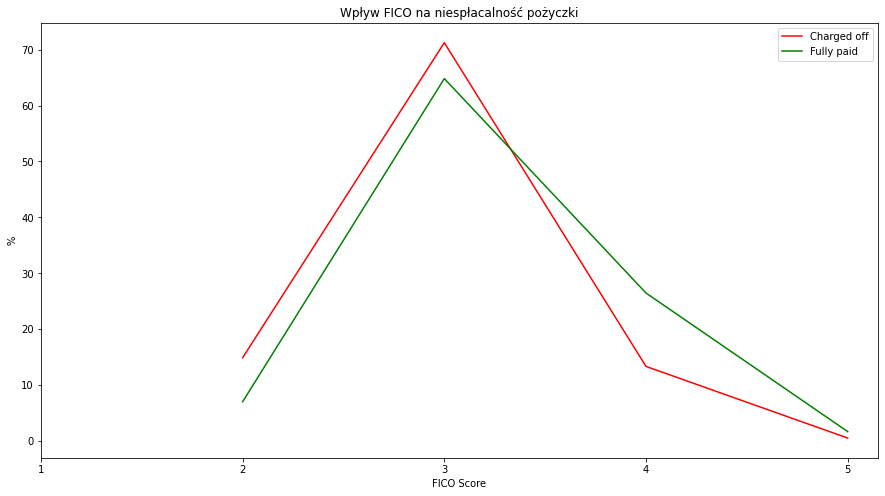

In [246]:
plt.figure(figsize=(15,8));
plt.plot(FICO_df.loc[0], color="red");
plt.plot(FICO_df.loc[1], color="green");
plt.title("Wpływ FICO na niespłacalność pożyczki");
plt.xlabel("FICO Score");
plt.ylabel("%");
plt.xticks(np.arange(1,6,1));
plt.legend(["Charged off", "Fully paid"]);

Większość osób w danym zbiorze danych ma wynik FICO = 3, w przypadku osób z FICO równym 4/5 (Exceptional/Very Good) prawdopodbieństwo spłacenia kredytu jest większe, natomiast osoby z wynikiem 2/3 (Good/Fair) częściej nie spłacają kredytu 

Podsumowanie: wyższy wynik FICO wpływa pozytywnie na spłacalność

In [247]:
feature_desc("last_fico_range_high")

LoanStatNew  \
37  last_fico_range_high   

                                                             Description  
37  The upper boundary range the borrower’s last FICO pulled belongs to.

In [248]:
feature_desc("fico_range_high")

LoanStatNew  \
21  fico_range_high   

                                                                     Description  
21  The upper boundary range the borrower’s FICO at loan origination belongs to.

**2. W jaki sposób wiek kredytowy wiąże się z prawdopodobieństwem niewykonania zobowiązania i czy ryzyko to jest niezależne lub związane z wynikiem FICO**

In [249]:
cr_age_df = pd.crosstab(df["loan_status"], df["years_since_earliest_cr_line"])

cr_age_df.loc[1] = round(cr_age_df.loc[1]/num_fully_paid*100, 2)
cr_age_df.loc[0] = round(cr_age_df.loc[0]/num_charged_off*100, 2)

cr_age_df

years_since_earliest_cr_line   0     1     2     3     4     5     6     7   \
loan_status                                                                   
0                             0.1  0.25  0.39  1.77  3.53  4.75  4.27  4.04   
1                             0.0  0.00  0.00  1.12  2.84  3.74  4.46  4.83   

years_since_earliest_cr_line    8     9   ...    47    48    49   50   52  \
loan_status                               ...                               
0                             4.63  5.19  ...  0.02  0.03  0.02  0.0  0.0   
1                             5.03  5.67  ...  0.02  0.02  0.01  0.0  0.0   

years_since_earliest_cr_line   55   56   57   61   65  
loan_status                                            
0                             0.0  0.0  0.0  0.0  0.0  
1                             0.0  0.0  0.0  0.0  0.0  

[2 rows x 57 columns]

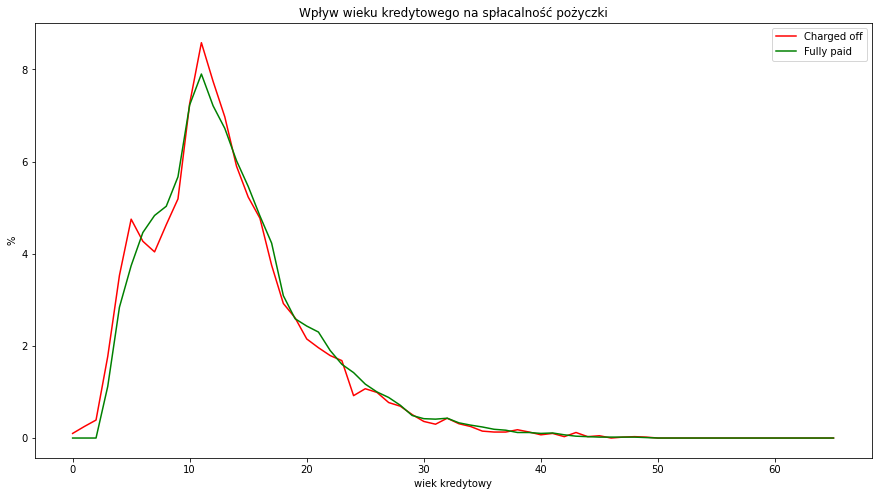

In [250]:
plt.figure(figsize=(15,8));
plt.plot(cr_age_df.loc[0], color="red");
plt.plot(cr_age_df.loc[1], color="green");
plt.title("Wpływ wieku kredytowego na spłacalność pożyczki");
plt.xlabel("wiek kredytowy");
plt.ylabel("%");
plt.legend(["Charged off", "Fully paid"]);

Osoby z niższym wiekiem kredytowym (0-14 lat) mają większe prawdpodobnieństwo nie spłacenia pożyczki

In [251]:
df["FICO_rating"].value_counts()

3    25671
4     9523
2     3215
5      584
Name: FICO_rating, dtype: int64

Analiza czy wiek kredytowy ma wpływ na FICO score

Utworzenie df z wiekiem kredytowym z niskim prawdopodbieństwem spłacenia pożyczki (do 14 lat):

In [252]:
cr_age_to_14 = df[df["years_since_earliest_cr_line"]<=14]["years_since_earliest_cr_line"]

In [253]:
cr_age_FICO_df = pd.crosstab(df["FICO_rating"], cr_age_to_14)
for i in range(0,15):
    for fico in range(2,6):
        cr_age_FICO_df[i].loc[fico] = round(cr_age_FICO_df[i].loc[fico]/cr_age_to_14.value_counts().loc[i]*100, 2)


In [254]:
cr_age_FICO_df # w % /liczbę wszystkich osób z danym wiekiem kredytowym np. dla 0-> 33% ma ocenę 2

years_since_earliest_cr_line     0     1      2      3      4      5      6   \
FICO_rating                                                                    
2                             33.33  60.0  54.17  15.16  16.19  13.43  10.83   
3                             50.00  40.0  45.83  79.16  76.33  76.10  75.28   
4                             16.67   0.0   0.00   5.68   7.48  10.47  13.84   
5                              0.00   0.0   0.00   0.00   0.00   0.00   0.06   

years_since_earliest_cr_line     7     8      9      10     11     12     13  \
FICO_rating                                                                    
2                             10.46   9.8   9.40   9.26   9.03   7.88   7.89   
3                             74.35  72.5  71.34  70.14  67.81  66.44  64.26   
4                             15.14  17.6  18.94  20.11  22.42  24.62  26.14   
5                              0.05   0.1   0.32   0.50   0.74   1.06   1.71   

years_since_earliest_cr_line     14  
FICO_rating                          
2                              7.05  
3                             66.05  
4                             25.44  
5                              1.45

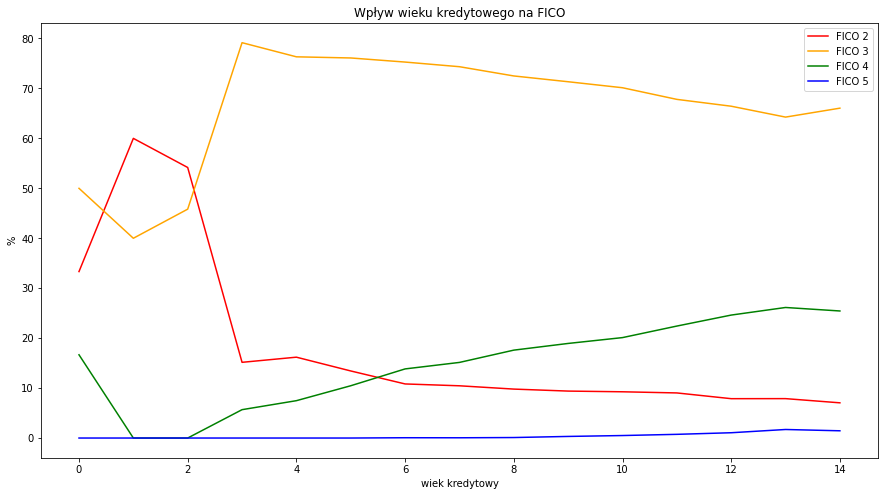

In [255]:
plt.figure(figsize=(15,8));
plt.plot(cr_age_FICO_df.loc[2], color="red", label = "FICO 2");
plt.plot(cr_age_FICO_df.loc[3], color="orange", label = "FICO 3");
plt.plot(cr_age_FICO_df.loc[4], color="green", label = "FICO 4");
plt.plot(cr_age_FICO_df.loc[5], color="blue", label = "FICO 5");
plt.title("Wpływ wieku kredytowego na FICO");
plt.xlabel("wiek kredytowy");
plt.ylabel("%");
plt.legend();

* Wraz ze wzrostem wieku kredytowego można zauważyć zwiększenie ilości osób w wyższymi ocenami FICO -> zielona i niebieska linia oznaczające wysokie oceny FICO reprezentuje zwiększanie wartości FICO wraz ze wzrotem wieku kredytowego
* Linia czerwona i żółta reprezentująca słabe wyniki FICO po osiągnięciu wieku kredytowego 4 stopniowo dąży do mniejszych wartości
* Dla najniższego wieku kredytowego (0-2 lata) można zauważyć znaczącą liczbę osób z niskim wynikiem FICO - przeważa FICO 2

Podsumowanie: Prawdopodobieństwo niewykonania zobowiązania zależy od wieku kredytowego - im niższy wiek kredytowy tym większa szansa na niewykonanie zobowiązania. Zależy również od wyniku FICO - im mniejszy wiek kredytowy, tym mniejszy wynik FICO, co przekłada się na mniejsze szanse spłaty kredytu

**Adding new feature #4**

Wykorzystanie informacji o poprzednich zakresach FICO score do utworzenia nowej zmiennej z informacją o wyniku FICO z przeszłości

last_fico_range_low & last_fico_range_high -> **last_FICO_rating**

In [256]:
last_fico_1_idx = df[df["last_fico_range_low"]<580].index
last_fico_2_idx = df[(df["last_fico_range_low"]>=580) & (df["last_fico_range_high"]<=669)].index
last_fico_3_idx = df[(df["last_fico_range_low"]>=670) & (df["last_fico_range_high"]<=739)].index
last_fico_4_idx = df[(df["last_fico_range_low"]>=740) & (df["last_fico_range_high"]<=799)].index
last_fico_5_idx = df[df["last_fico_range_low"]>=800].index

In [257]:
df["last_FICO_rating"] = None

for i, item in enumerate([last_fico_1_idx, last_fico_2_idx, last_fico_3_idx, last_fico_4_idx, last_fico_5_idx]):
    df["last_FICO_rating"].iloc[item] = i+1

Podgląd porównania FICO i last FICO

In [258]:
df[["last_FICO_rating", "FICO_rating"]].head()

last_FICO_rating  FICO_rating
0                3            3
1                3            4
2                3            3
3                2            3
4                3            3

In [259]:
df.drop(["last_fico_range_low", "last_fico_range_high"], axis=1, inplace=True)

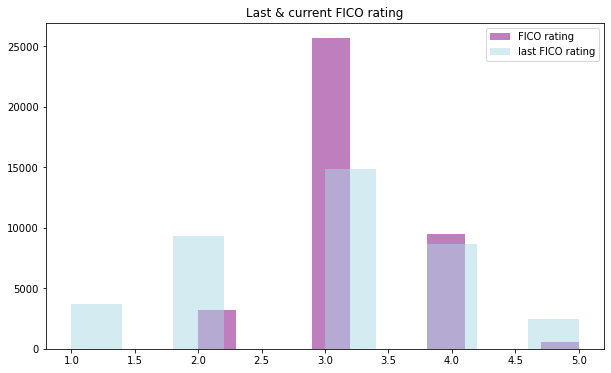

In [260]:
plt.figure(figsize=(10,6));
plt.hist(df["FICO_rating"], color = "purple", alpha=0.5, label="FICO rating");
plt.hist(df["last_FICO_rating"], color = "lightblue", alpha=0.5, label="last FICO rating");
plt.legend();
plt.title("Last & current FICO rating");

Obecny wynik FICO pożyczkobiorców jest na ogól lepszy niż w poprzednim przypdaku - brak najgorszej oceny 1 (Poor) oraz zmniejszenie liczby osób z wynikiem 2 (Fair), różnica pomiędzy tymi wynikami jako dodatkowa zmienna może być korzystna przy modelowaniu

**Adding feature #5**

**FICO_diff** -> difference between current & last FICO rating

In [261]:
df["FICO_diff"] = df["FICO_rating"] - df["last_FICO_rating"]

In [262]:
df["FICO_diff"].value_counts()

 0    15524
 1    10658
-1     7144
 2     3994
-2     1146
 3      484
-3       34
 4        9
Name: FICO_diff, dtype: int64

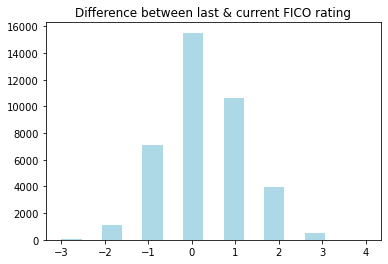

In [263]:
plt.hist(df["FICO_diff"], bins=15, color='lightblue');
plt.title("Difference between last & current FICO rating");

**Adding feature #6**

Utworzenie nowej zmiennej według zależności:

**acc_rate** = open_acc/total_acc

`open_acc` -> The number of open credit lines in the borrower's credit file.

`total_acc` -> The total number of credit lines currently in the borrower's credit file

In [264]:
df["acc_rate"] = df["open_acc"] / df["total_acc"]

In [265]:
df["acc_rate"].head()

0    0.333333
1    0.750000
2    0.200000
3    0.270270
4    0.394737
Name: acc_rate, dtype: float64

**Adding feature #7**

Silna korelacja pomiędzy 2 zmiennymi - połączenie w jedną według zależności:

**funded_amnt_avg** = (mean of funded_amnt + funded_amnt_inv)/2

`funded_amnt` -> The total amount committed to that loan at that point in time

`funded_amnt_inv` -> The total amount committed by investors for that loan at that point in time.

In [266]:
df["funded_amnt_avg"] = (df["funded_amnt"]+df["funded_amnt_inv"])/2

In [267]:
df["funded_amnt_avg"].head()

0     4987.5
1     2500.0
2     2400.0
3    10000.0
4     3000.0
Name: funded_amnt_avg, dtype: float64

In [268]:
df.drop(["funded_amnt", "funded_amnt_inv"], axis=1, inplace=True)

**Adding feature #8**

**loan_amnt_and_funded_diff** = loan_amnt - funded_amnt_avg

`loan_amnt`-> the listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.

In [269]:
df["loan_amnt"].corr(df["funded_amnt_avg"])

0.9548248207803227

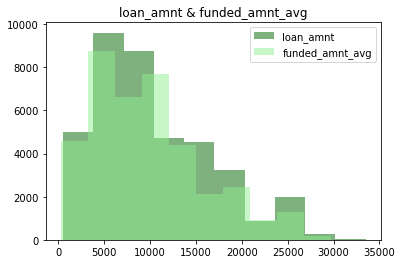

In [270]:
plt.hist(df["loan_amnt"], color = "darkgreen", alpha=0.5, label="loan_amnt");
plt.hist(df["funded_amnt_avg"], color = "lightgreen", alpha=0.5, label = "funded_amnt_avg");
plt.title("loan_amnt & funded_amnt_avg");
plt.legend();

Utworzenie nowej zmiennej wykorzystując różnice pomiędzy powyższymi zmiennymi

In [271]:
df["loan_amnt_and_funded_diff"] = df["loan_amnt"] - df["funded_amnt_avg"]

In [272]:
df["loan_amnt_and_funded_diff"].value_counts()

0.000000       19097
12.500000       3442
25.000000       1533
125.000000      1197
50.000000        684
               ...  
9375.000000        1
712.378777         1
174.976738         1
451.306235         1
61.784343          1
Name: loan_amnt_and_funded_diff, Length: 7714, dtype: int64

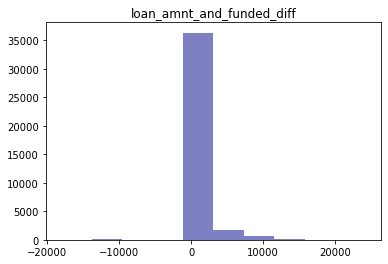

In [273]:
plt.hist(df["loan_amnt_and_funded_diff"], color = "darkblue", alpha=0.5);
plt.title("loan_amnt_and_funded_diff");

**Adding feature #9**

Utworzenie nowej zmiennej, która jest średnią poniższych zmiennych:

**total_pymnt_avg** = (total_pymnt + total_pymnt_inv)/2

`total_pymnt`-> Payments received to date for total amount funded

`total_pymnt_inv`->	Payments received to date for portion of total amount funded by investors

In [274]:
df["total_pymnt_avg"] = (df["total_pymnt"]+df["total_pymnt_inv"])/2
df.drop(["total_pymnt", "total_pymnt_inv"], axis=1, inplace=True)
df["total_pymnt_avg"].head()

0     5848.497593
1     1014.530000
2     3005.668422
3    12231.890000
4     4066.909081
Name: total_pymnt_avg, dtype: float64

**Adding feature #10**

Utworzenie nowej zmiennej według zależności:

**total_pymnt_prncp_diff** = total_pymnt_avg - total_rec_prncp

principal - the initial amount borrowed

`total_rec_prncp` -> Principal received to date

`total_pymnt`-> Payments received to date for total amount funded


In [275]:
df["total_pymnt_prncp_diff"] = df["total_pymnt_avg"] - df["total_rec_prncp"]

In [276]:
df["total_pymnt_prncp_diff"].head()

0     848.497593
1     558.070000
2     605.668422
3    2231.890000
4    1066.909081
Name: total_pymnt_prncp_diff, dtype: float64

In [277]:
df.drop("index", axis=1, inplace=True)

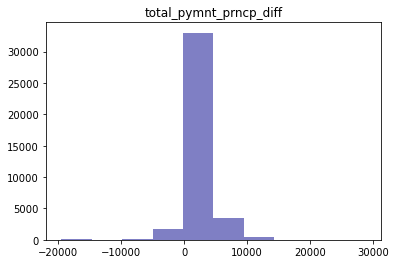

In [278]:
plt.hist(df["total_pymnt_prncp_diff"], color = "darkblue", alpha=0.5);
plt.title("total_pymnt_prncp_diff");

**Adding feature #11**

Utworzenie nowej zmiennej według zależności:

**loan_amnt_ratio** = funded_amnt_avg/loan_amnt

`loan_amnt` ->The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.


In [279]:
df["loan_amnt_ratio"] = df["funded_amnt_avg"]/df["loan_amnt"]

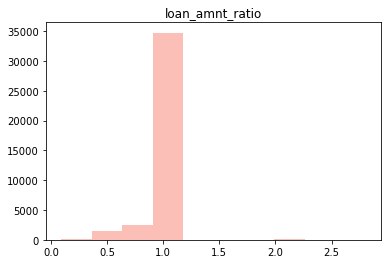

In [280]:
plt.hist(df["loan_amnt_ratio"], color = "salmon", alpha=0.5);
plt.title("loan_amnt_ratio");

**Adding feature #12**

Utworzenie nowej zmiennej o wartościach binarnych sygnalizujących czy jest to kredyt konsolidacyjny

**is_consolidation** -> if consolidation as purpose 1, otherwise 0

In [281]:
df["is_consolidation"] = None
df["is_consolidation"].iloc[df["purpose"][df["purpose"].str.contains("CONSOLID")].index] = 1
df["is_consolidation"].fillna(0, inplace=True)

In [282]:
df["is_consolidation"].value_counts()

0    20787
1    18206
Name: is_consolidation, dtype: int64

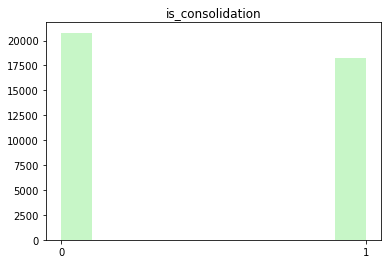

In [283]:
plt.hist(df["is_consolidation"], color = "lightgreen", alpha=0.5);
plt.title("is_consolidation");
plt.xticks([0,1]);

**Adding feature #13**

Utworzenie nowej zmiennej o wartościach binarnych sygnalizujących czy pożyczka jest na dom

**is_for_house** -> if for home/house as purpose 1, otherwise 0

In [284]:
df["is_for_home"] = None
df["is_for_home"].iloc[df["purpose"][df["purpose"].str.contains("HOME|HOUSE")].index] = 1
df["is_for_home"].fillna(0, inplace=True)
df["is_for_home"].value_counts()

0    35789
1     3204
Name: is_for_home, dtype: int64

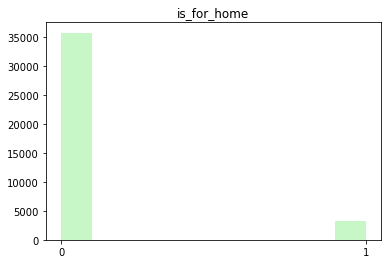

In [285]:
plt.hist(df["is_for_home"], color = "lightgreen", alpha=0.5);
plt.title("is_for_home");
plt.xticks([0,1]);

**Adding feature #14**

Utworzenie nowej zmiennej o wartościach binarnych sygnalizujących czy pożyczkobiorca jest właścicielem domu

**is_house_owner** -> [0, 1]



In [286]:
df["is_house_owner"] = None
df["is_house_owner"].iloc[df["home_ownership"][df["home_ownership"]=="OWN"].index] = 1
df["is_house_owner"].fillna(0, inplace=True)
df["is_house_owner"].value_counts()

0    35974
1     3019
Name: is_house_owner, dtype: int64

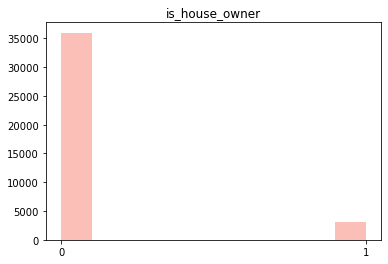

In [287]:
plt.hist(df["is_house_owner"], color = "salmon", alpha=0.5);
plt.title("is_house_owner");
plt.xticks([0,1]);

**Adding feature #15**

Utworzenie nowej zmiennej o wartościach binarnych sygnalizujących czy roczny dochód powyżej mediany

**annual_inc_high** -> 1 if annual income above median

In [288]:
df["annual_inc_high"] = None
df["annual_inc_high"].iloc[df["annual_inc"][df["annual_inc"]>df["annual_inc"].median()].index] = 1
df["annual_inc_high"].fillna(0, inplace=True)
df["annual_inc_high"].value_counts()

0    19559
1    19434
Name: annual_inc_high, dtype: int64

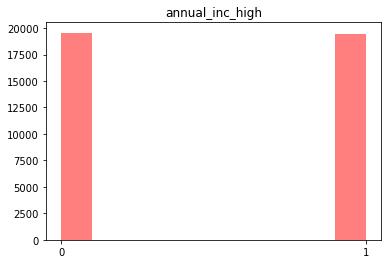

In [289]:
plt.hist(df["annual_inc_high"], color = "red", alpha=0.5);
plt.title("annual_inc_high");
plt.xticks([0,1]);

**Adding feature #16**

Utworzenie nowej zmiennej o wartościach binarnych sygnalizujących czy brakuje opisu pożyczki

**is_desc_missing** = [0,1]

In [290]:
df["is_desc_missing"] = None
df["is_desc_missing"].iloc[df["desc"][df["desc"] == "MISSING"].index] = 1
df["is_desc_missing"].fillna(0, inplace=True)
df["is_desc_missing"].value_counts()

0    26442
1    12551
Name: is_desc_missing, dtype: int64

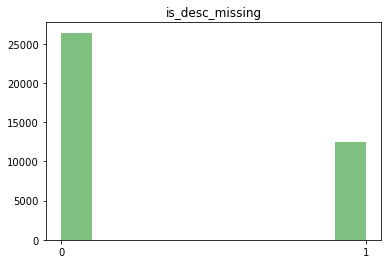

In [291]:
plt.hist(df["is_desc_missing"], color = "green", alpha=0.5);
plt.title("is_desc_missing");
plt.xticks([0,1]);

**Adding feature #17**

Utworzenie nowej zmiennej o wartościach binarnych sygnalizujących czy dti poniżej progu: mediana * 1.50

**low_dti** -> 1 if dti below median*1.50

`dti` -> A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.


In [292]:
df["low_dti"] = None
df["low_dti"].iloc[df["dti"][df["dti"] < df["dti"].median()*1.5].index] = 1
df["low_dti"].fillna(0, inplace=True)
df["low_dti"].value_counts()

1    31864
0     7129
Name: low_dti, dtype: int64

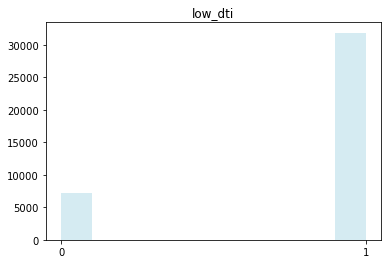

In [293]:
plt.hist(df["low_dti"], color = "lightblue", alpha=0.5);
plt.title("low_dti");
plt.xticks([0,1]);

**Adding feature #18**

Utworzenie nowej zmiennej o wartościach binarnych sygnalizujących czy int_rate powyżej progu: mediana * 1.50

**high_int_rate** -> interest rate above median*1.5

`int_rate` -> Interest Rate on the loan


In [294]:
df["high_int_rate"] = None
df["high_int_rate"].iloc[df["int_rate"][df["int_rate"] > df["int_rate"].median()*1.5].index] = 1
df["high_int_rate"].fillna(0, inplace=True)
df["high_int_rate"].value_counts()

0    36450
1     2543
Name: high_int_rate, dtype: int64

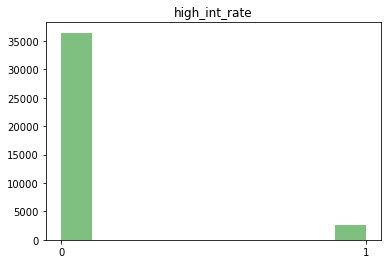

In [295]:
plt.hist(df["high_int_rate"], color = "green", alpha=0.5);
plt.title("high_int_rate");
plt.xticks([0,1]);

**Adding feature #19**

Utworzenie nowej zmiennej o wartościach binarnych sygnalizujących czy cel pożyczki znany

**is_purpose_not_known** -> 1 if purpose is "other"

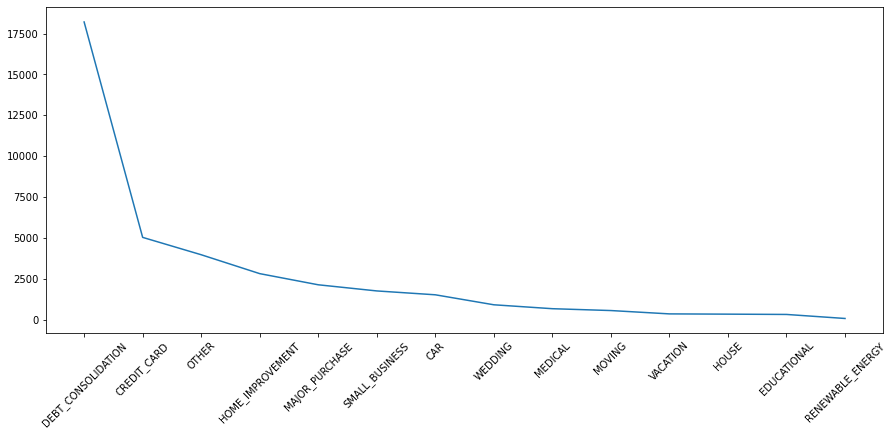

In [296]:
plt.figure(figsize=(15,6))
plt.plot(df["purpose"].value_counts());
plt.xticks(rotation=45);

In [297]:
df["is_purpose_not_known"] = None
df["is_purpose_not_known"].iloc[df["purpose"][df["purpose"] == "OTHER"].index] = 1
df["is_purpose_not_known"].fillna(0, inplace=True)
df["is_purpose_not_known"].value_counts()

0    35000
1     3993
Name: is_purpose_not_known, dtype: int64

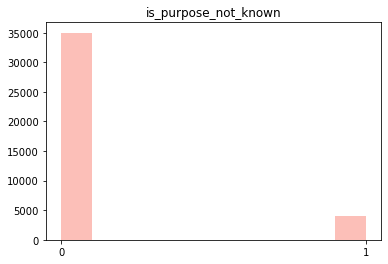

In [298]:
plt.hist(df["is_purpose_not_known"], color = "salmon", alpha=0.5);
plt.title("is_purpose_not_known");
plt.xticks([0,1]);

**Adding feature #20**

Utworzenie nowej zmiennej o wartościach binarnych sygnalizujących czy niskie lata pracy, jeśli poniżej mediany ->0

**short_emp_length** -> 1 if below median

In [299]:
df["short_emp_length"] = None
df["short_emp_length"].iloc[df["emp_length"][df["emp_length"] > df["emp_length"].median()].index] = 1
df["short_emp_length"].fillna(0, inplace=True)
df["short_emp_length"].value_counts()

0    20639
1    18354
Name: short_emp_length, dtype: int64

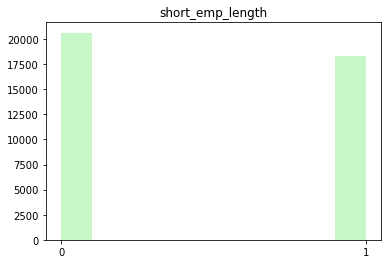

In [300]:
plt.hist(df["short_emp_length"], color = "lightgreen", alpha=0.5);
plt.title("short_emp_length");
plt.xticks([0,1]);

**Adding feature #21**

Utworzenie nowej zmiennej o wartościach binarnych sygnalizujących czy wysokie raty, jeśli powyżej mediany*1.5 ->1

**high_installment** -> 1 if above median*1.5

In [301]:
df["high_installment"] = None
df["high_installment"].iloc[df["installment"][df["installment"] > df["installment"].median()*1.5].index] = 1
df["high_installment"].fillna(0, inplace=True)
df["high_installment"].value_counts()

0    29393
1     9600
Name: high_installment, dtype: int64

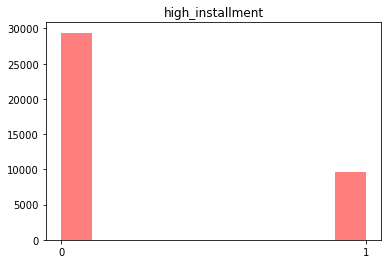

In [302]:
plt.hist(df["high_installment"], color = "red", alpha=0.5);
plt.title("high_installment");
plt.xticks([0,1]);

Sprawdzenie typów nowo utworzonych zmiennych

In [303]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38993 entries, 0 to 38992
Data columns (total 56 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   loan_amnt                     38993 non-null  int64   
 1   term                          38993 non-null  object  
 2   int_rate                      38993 non-null  float64 
 3   installment                   38993 non-null  float64 
 4   grade                         38993 non-null  object  
 5   sub_grade                     38993 non-null  object  
 6   emp_length                    38993 non-null  int64   
 7   home_ownership                38993 non-null  object  
 8   annual_inc                    38993 non-null  float64 
 9   verification_status           38993 non-null  object  
 10  loan_status                   38993 non-null  category
 11  desc                          38993 non-null  object  
 12  purpose                       38993 non-null  

In [304]:
cols_to_change =[
                "FICO_rating", "last_FICO_rating", "is_consolidation", "is_for_home", "is_house_owner", "earliest_cr_line_before_2000",
                "annual_inc_high", "is_desc_missing", "low_dti", "high_int_rate", "is_purpose_not_known", "short_emp_length", "high_installment",
                ]

df[cols_to_change] = df[cols_to_change].astype('int')

Określenie które zmienne są binarne + ich zamiana na kategorie:

In [305]:
bin_cat_cols=[]
for label in df.columns:
    if len(df[label].value_counts().index) == 2:
        bin_cat_cols.append(label)

In [306]:
df[bin_cat_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38993 entries, 0 to 38992
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   term                          38993 non-null  object  
 1   loan_status                   38993 non-null  category
 2   delinq_2yrs                   38993 non-null  category
 3   pub_rec                       38993 non-null  category
 4   revol_bal                     38993 non-null  category
 5   total_rec_int                 38993 non-null  category
 6   total_rec_late_fee            38993 non-null  category
 7   recoveries                    38993 non-null  category
 8   collection_recovery_fee       38993 non-null  category
 9   last_pymnt_amnt               38993 non-null  category
 10  pub_rec_bankruptcies          38993 non-null  category
 11  debt_settlement_flag          38993 non-null  object  
 12  earliest_cr_line_before_2000  38993 non-null  

In [307]:
df[bin_cat_cols] = df[bin_cat_cols].astype('category')

In [308]:
df[bin_cat_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38993 entries, 0 to 38992
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   term                          38993 non-null  category
 1   loan_status                   38993 non-null  category
 2   delinq_2yrs                   38993 non-null  category
 3   pub_rec                       38993 non-null  category
 4   revol_bal                     38993 non-null  category
 5   total_rec_int                 38993 non-null  category
 6   total_rec_late_fee            38993 non-null  category
 7   recoveries                    38993 non-null  category
 8   collection_recovery_fee       38993 non-null  category
 9   last_pymnt_amnt               38993 non-null  category
 10  pub_rec_bankruptcies          38993 non-null  category
 11  debt_settlement_flag          38993 non-null  category
 12  earliest_cr_line_before_2000  38993 non-null  

# EDA cd. - z uwzględnieniem nowo utworzonych zmiennych

Ponowne sprawdzenie korelacji:

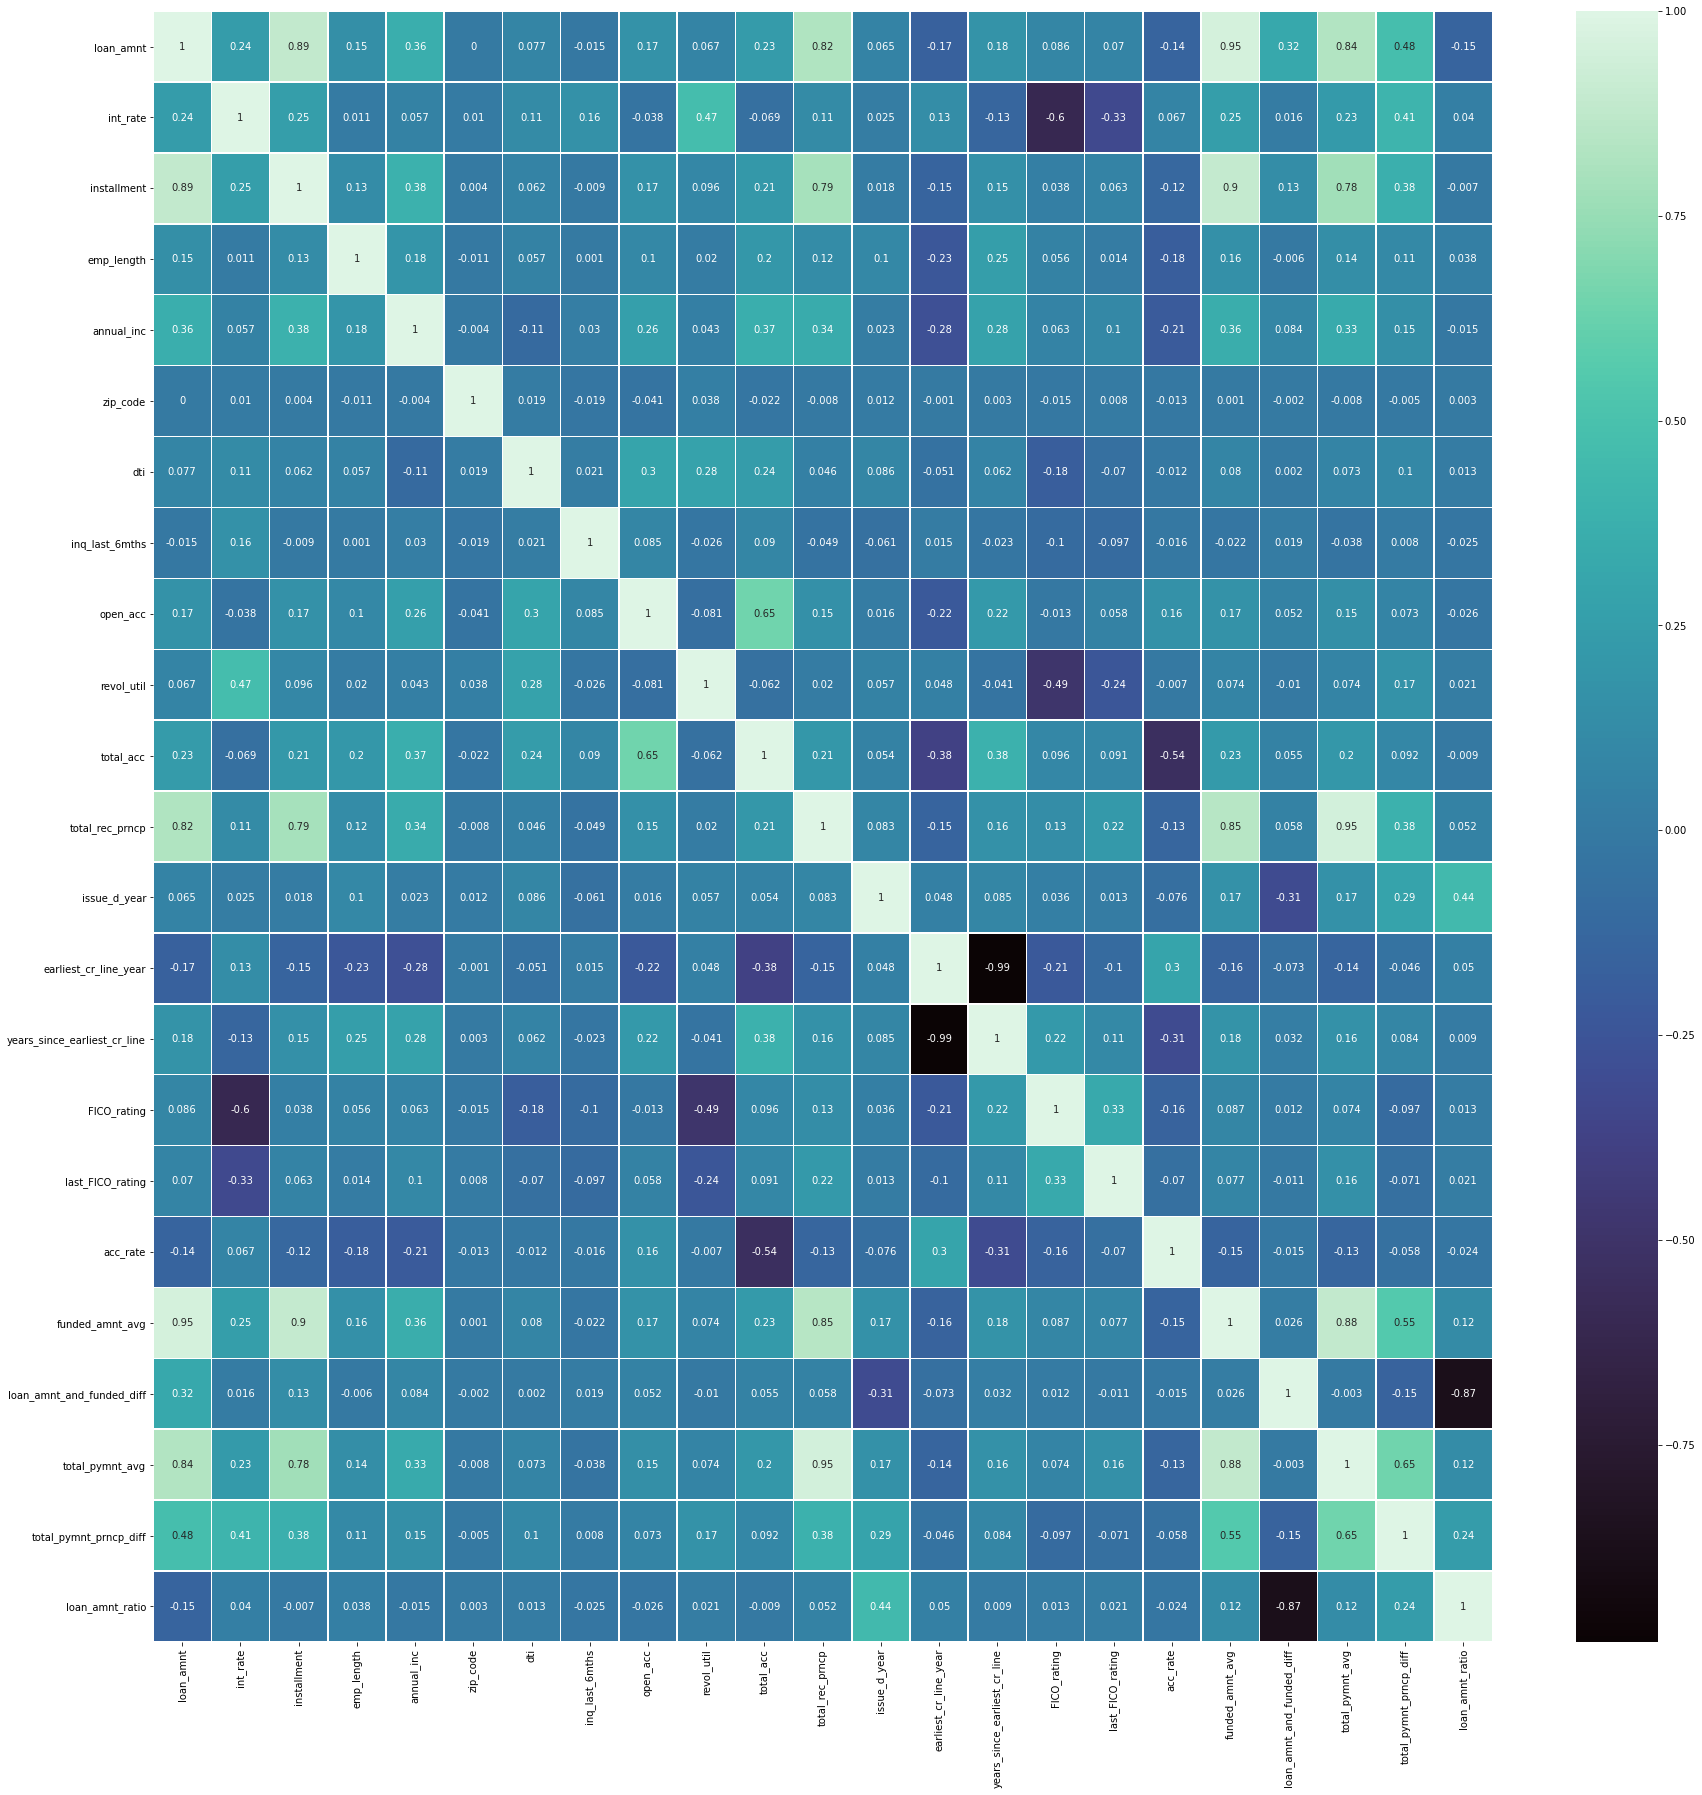

In [309]:
plt.figure(figsize=(30, 30));
sns.heatmap(round(df.corr(), 3), annot=True, linewidths=0.5, cmap = 'mako');

Zmienne, które nadal są silnie skorelowane -> drop:

In [310]:
# high correlation
cols_to_drop =["loan_amnt", "int_rate", "total_rec_prncp", "funded_amnt_avg", "total_pymnt_avg", "total_acc",
               "loan_amnt_and_funded_diff"]
df.drop(cols_to_drop, axis=1, inplace=True)

In [311]:
df[["issue_d_year", "earliest_cr_line_year"]] = df[["issue_d_year", "earliest_cr_line_year"]].astype('category')

Ponowne sprawdzenie macierzy korelacji po wprowadzonych zmianach:

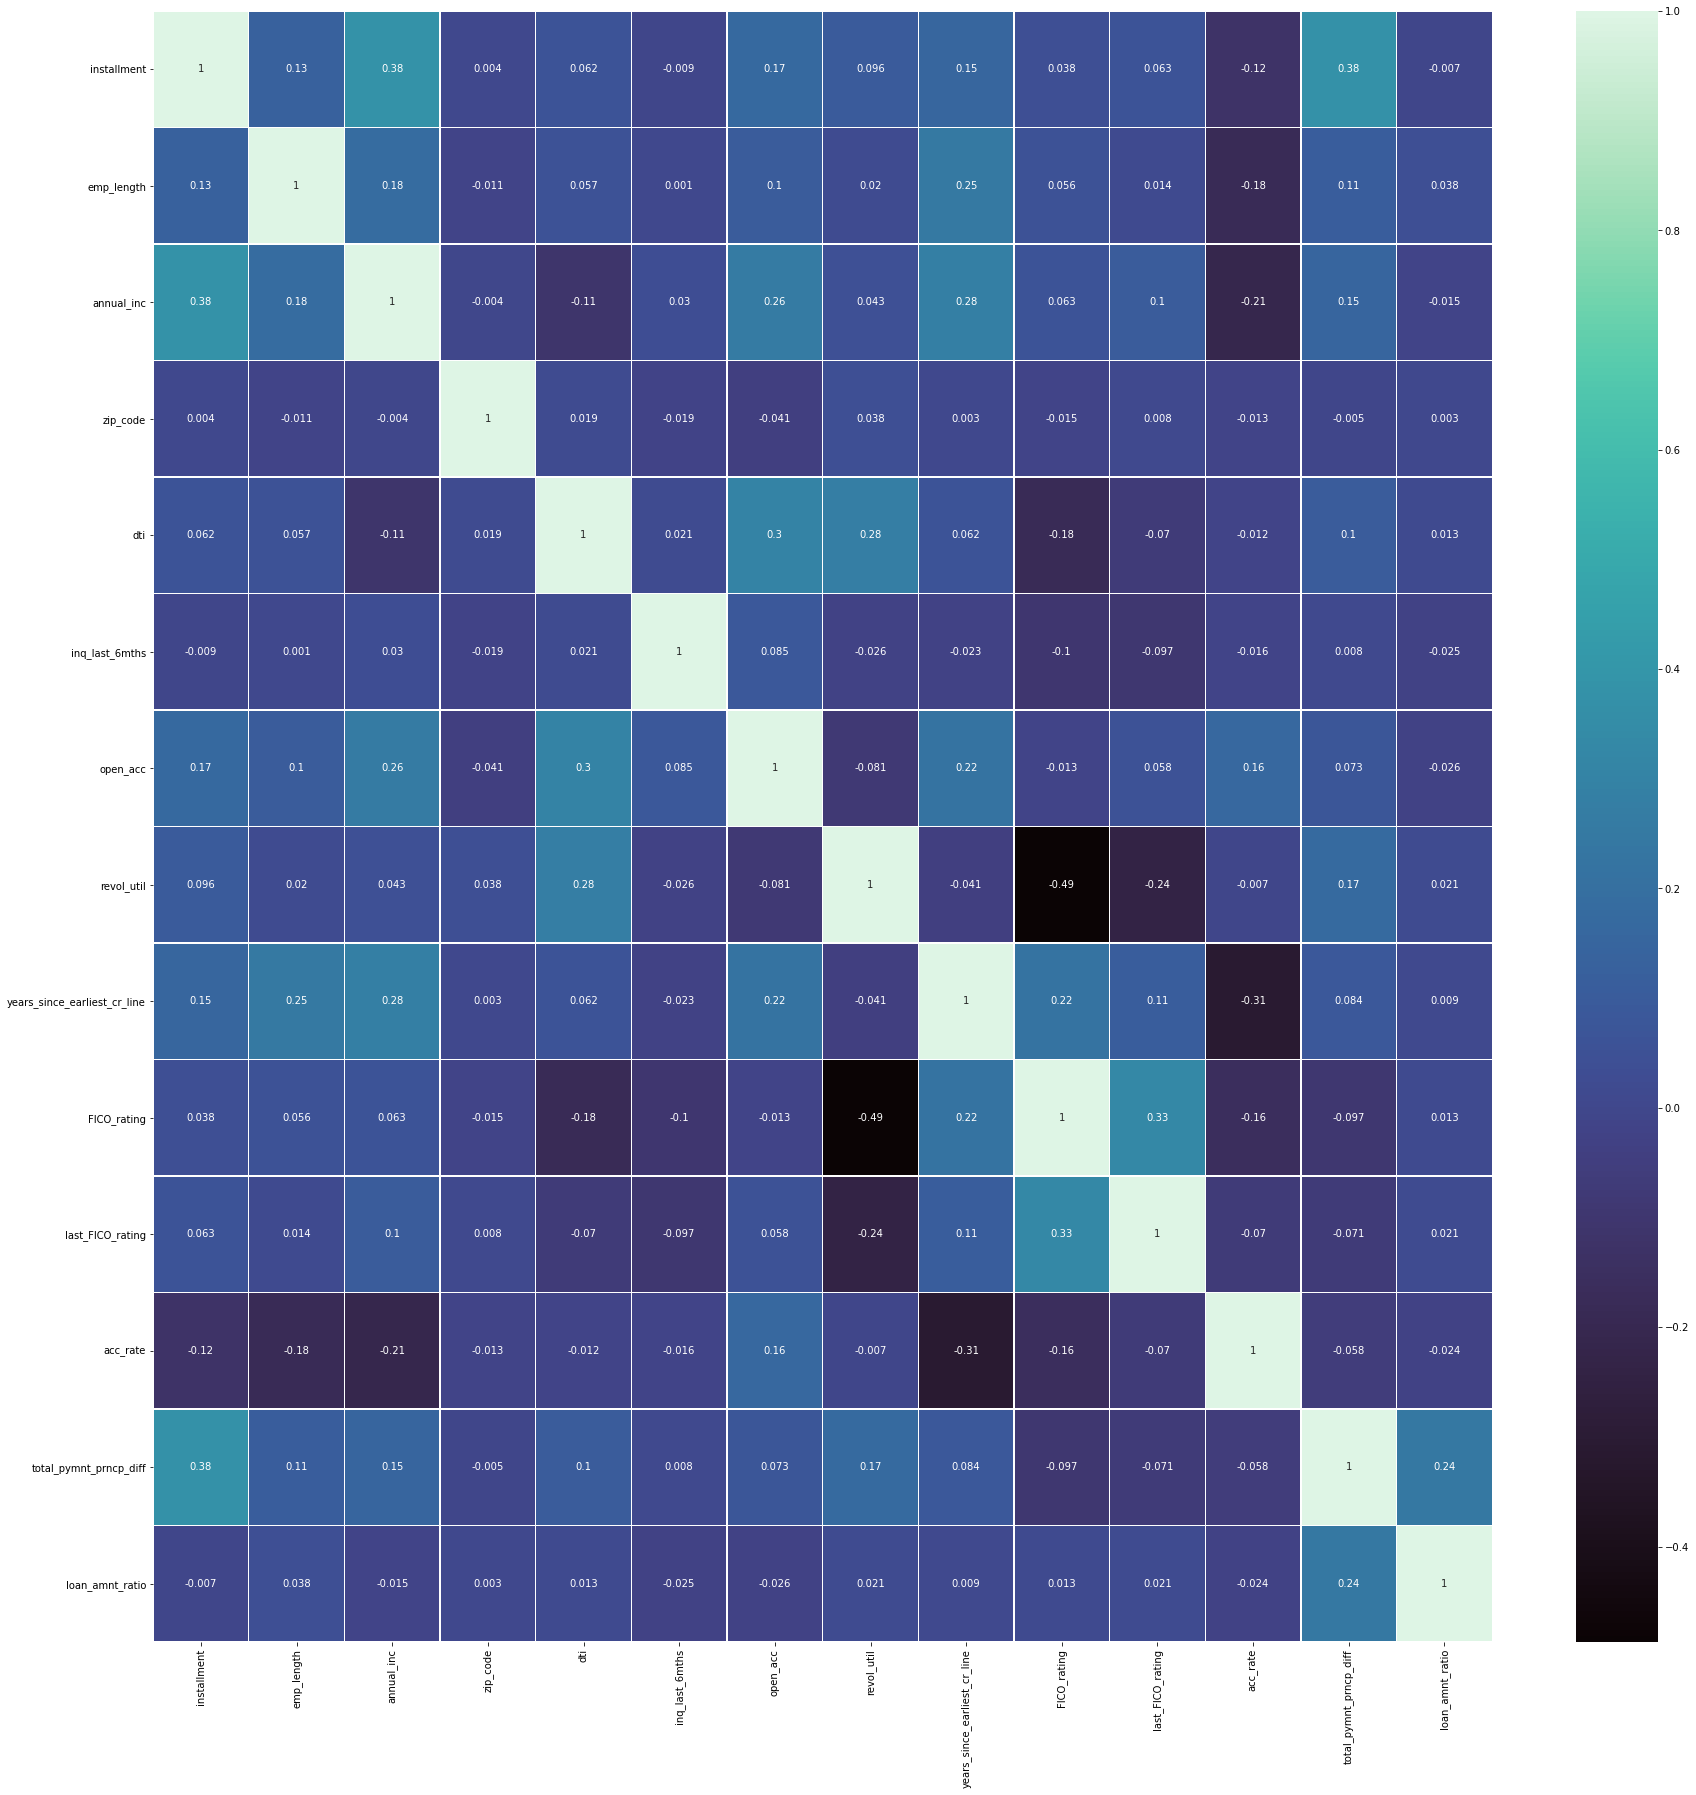

In [312]:
plt.figure(figsize=(30, 30));
sns.heatmap(round(df.corr(), 3), annot=True, linewidths=0.5, cmap = 'mako');

Korelacja pomiędzy zmiennymi na dostatecznym poziomie -> (-0.5, 0.5),

dodatkowo sprawdzenie zmiennej revol_util z korelacją -0.49 z FICO rating

In [313]:
df["revol_util"].value_counts()

0.00     965
49.50    100
0.20      62
63.00     61
40.70     58
        ... 
69.98      1
10.17      1
46.74      1
17.67      1
26.33      1
Name: revol_util, Length: 1096, dtype: int64

In [314]:
feature_desc("revol_util")

LoanStatNew  \
91  revol_util   

                                                                                                                   Description  
91  Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.

In [315]:
df["revol_util"][df["revol_util"] !=0].count()

38028

In [316]:
df["revol_util"][(df["revol_util"] !=0) & df["revol_util"]<=df["revol_util"].max()/2].count()

38993

In [317]:
df["revol_util"][df["revol_util"]>df["revol_util"].max()/2].count()

17946

Podział zmiennej revol_util na 3 kategorie:

próg = wartość max/2

* wartości równe zero -> 'zero'
* poniżej progu -> 'low'
* powyżej progu -> 'high'

In [318]:
# revol_util -> 3 categories
threshold = df["revol_util"].max()/2
df["revol_util_level"] = None
df["revol_util_level"][df["revol_util"] ==0] = "zero"
df["revol_util_level"][(df["revol_util"] !=0) & (df["revol_util"]<=threshold)] = "low"
df["revol_util_level"][(df["revol_util"]>threshold)] = "high"

df.drop("revol_util", axis=1, inplace=True)

In [319]:
df["revol_util_level"].value_counts()

low     20082
high    17946
zero      965
Name: revol_util_level, dtype: int64

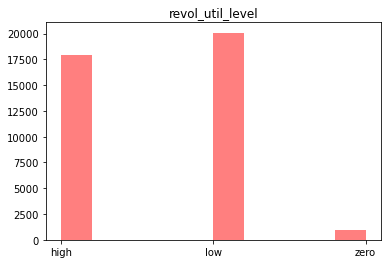

In [320]:
plt.hist(df["revol_util_level"], color = "red", alpha=0.5);
plt.title("revol_util_level");

In [321]:
df[["emp_length", "revol_util_level"]] = df[["emp_length", "revol_util_level"]].astype('category')

Stworzenie list z nazwami zmiennych kategorycznych i numerycznych:

In [322]:
numeric_cols = []
cat_cols = []
for label, content in df.drop("loan_status", axis=1).items():
    if pd.api.types.is_numeric_dtype(content):
        numeric_cols.append(label)
    else:
        cat_cols.append(label)

### Histograms for numeric features

In [323]:
numeric_cols

['installment',
 'annual_inc',
 'zip_code',
 'dti',
 'inq_last_6mths',
 'open_acc',
 'years_since_earliest_cr_line',
 'FICO_rating',
 'last_FICO_rating',
 'acc_rate',
 'total_pymnt_prncp_diff',
 'loan_amnt_ratio']

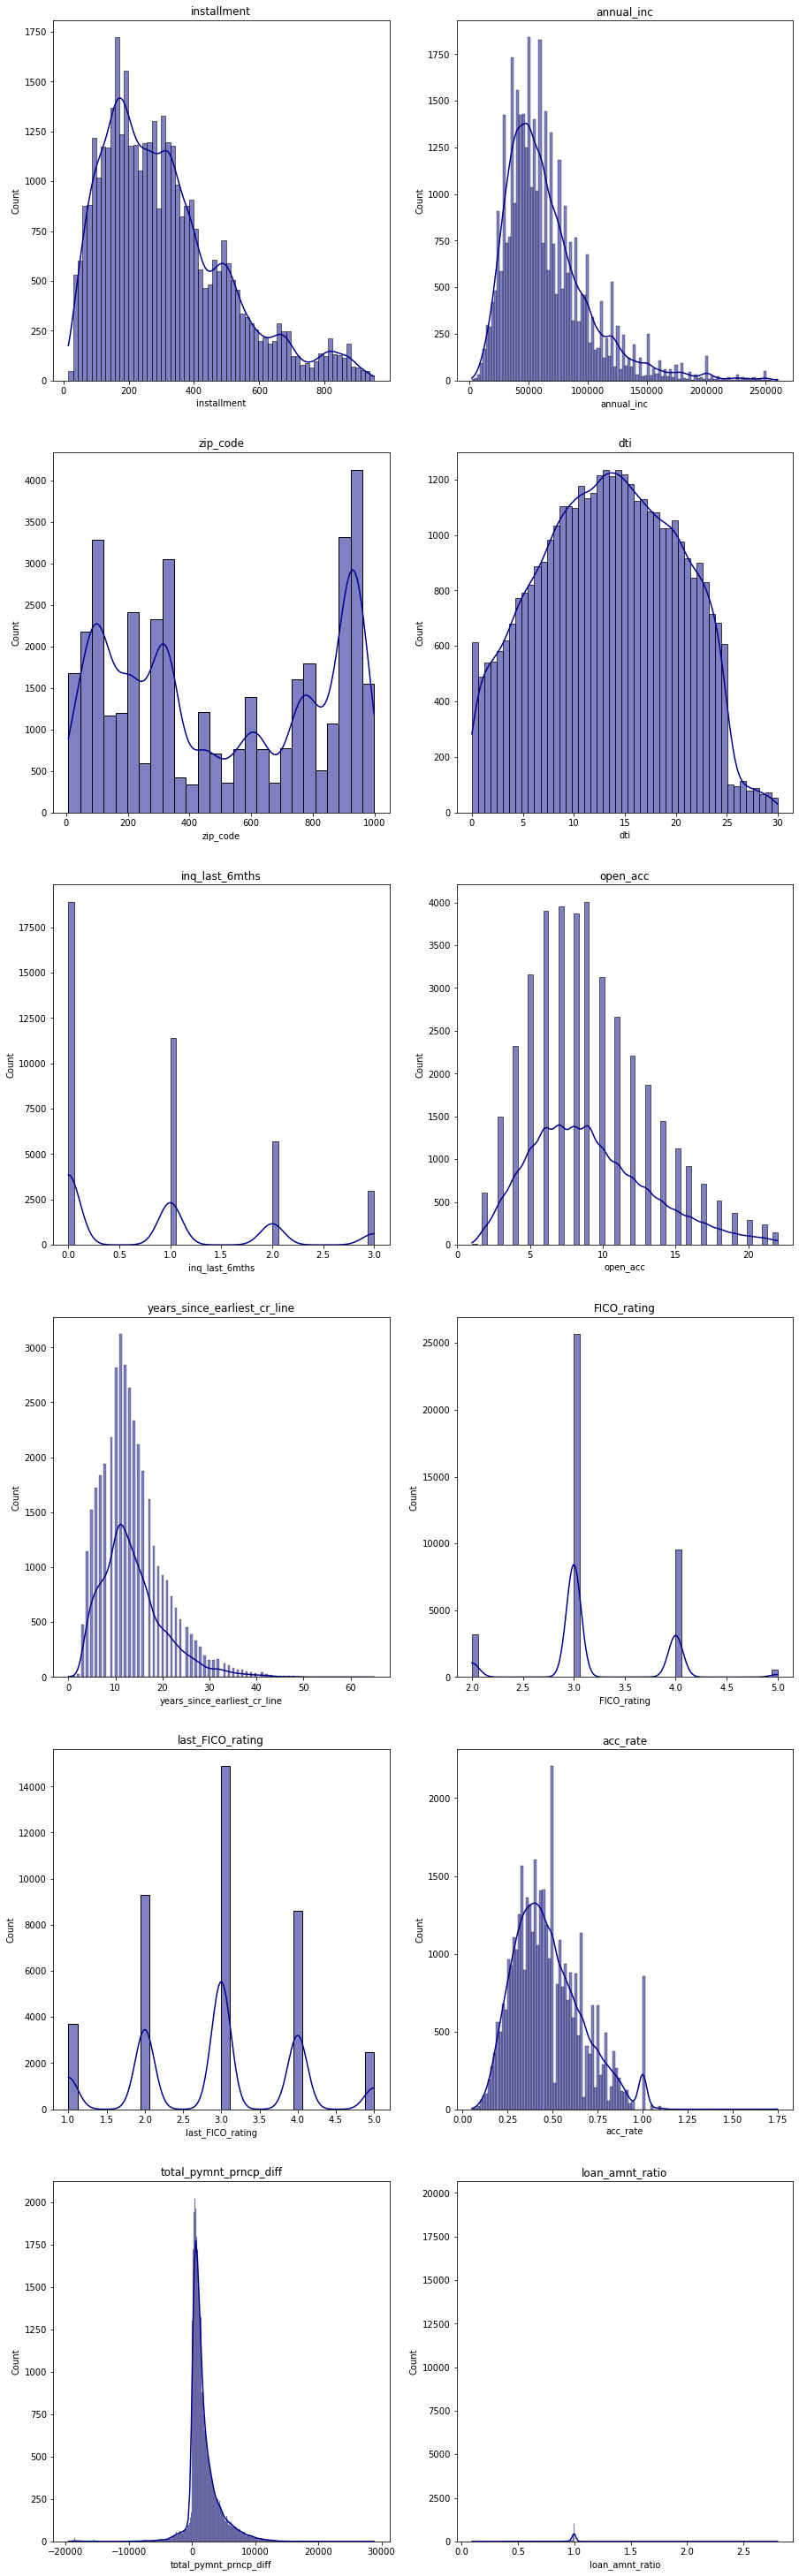

In [324]:
colors=['darkblue']

fig, axs = plt.subplots((round(len(numeric_cols)/2)), 2, figsize = (15, 15*3.5))
step=0
for i in range(round(len(numeric_cols)/2)):

    sns.histplot(df[numeric_cols[i+step]], color = colors[0], kde=True, ax = axs[i,0])
    axs[i,0].set_title(numeric_cols[i+step])
        
    sns.histplot(df[numeric_cols[i+step+1]], color = colors[0], kde=True, ax = axs[i,1])
    axs[i,1].set_title(numeric_cols[i+step+1])
            
    step +=1
        


Zmienne numeryczne posiadają rozkłady normalne (FICO rating widoczne na wykresie zamienić poniżej na kategorie) + analiza zmiennej 'zip_code' i 'addr_state'

In [325]:
df["addr_state"] # similar to zip code

0        AZ
1        GA
2        IL
3        CA
4        OR
         ..
38988    FL
38989    MO
38990    CO
38991    MA
38992    CT
Name: addr_state, Length: 38993, dtype: object

Zmienna zip_code -> podobna informacja do addr_state -> drop

In [326]:
df.drop("zip_code", axis=1, inplace=True)

In [327]:
df[["inq_last_6mths", "FICO_rating", "last_FICO_rating"]] = df[["inq_last_6mths", "FICO_rating", "last_FICO_rating"]].astype('category')

###  Turning data into categories & one-hot encoding

Ponowny podział na zmienne kategoryczne i numeryczne:

In [328]:
cat_cols = []
numeric_cols = []
for label, content in df.drop("loan_status", axis=1).items():
    if not pd.api.types.is_numeric_dtype(content):
        df[label] = df[label].astype("category")
        cat_cols.append(label)
    else:
        numeric_cols.append(label)

In [329]:
df[numeric_cols]

installment  annual_inc    dti  open_acc  years_since_earliest_cr_line  \
0           162.87     24000.0  27.65       3.0                            26   
1            59.83     30000.0   1.00       3.0                            12   
2            84.33     12252.0   8.72       2.0                            10   
3           339.31     49200.0  20.00      10.0                            15   
4            67.79     80000.0  17.94      15.0                            15   
...            ...         ...    ...       ...                           ...   
38988       693.45     80000.0   3.11       5.0                            10   
38989       226.98     60000.0  13.16      10.0                            16   
38990        81.94      6500.0   6.46       9.0                            16   
38991        42.65     40000.0  10.00       9.0                            16   
38992       208.66     20000.0  10.00       9.0                            16   

       acc_rate  total_pymnt_prncp_diff  loan_amnt_ratio  
0      0.333333              848.497593         0.997500  
1      0.750000              558.070000         1.000000  
2      0.200000              605.668422         1.000000  
3      0.270270             2231.890000         1.000000  
4      0.394737             1066.909081         1.000000  
...         ...                     ...              ...  
38988  0.833333             -899.360000         0.517500  
38989  0.312500             -676.290000         0.561338  
38990  0.450000             -533.005000         0.610577  
38991  0.450000              330.480000         0.500000  
38992  0.450000             1805.210000         0.500000  

[38993 rows x 8 columns]

In [330]:
df[cat_cols]

term grade sub_grade emp_length home_ownership verification_status  \
0       36     B         2         10           RENT            VERIFIED   
1       60     C         4          0           RENT     SOURCE VERIFIED   
2       36     C         5         10           RENT        NOT VERIFIED   
3       36     C         1         10           RENT     SOURCE VERIFIED   
4       60     B         5          1           RENT     SOURCE VERIFIED   
...    ...   ...       ...        ...            ...                 ...   
38988   36     F         1          2            OWN        NOT VERIFIED   
38989   36     D         5         10       MORTGAGE        NOT VERIFIED   
38990   36     A         5          3       MORTGAGE        NOT VERIFIED   
38991   36     D         3          1           RENT        NOT VERIFIED   
38992   36     B         4          0           RENT        NOT VERIFIED   

          desc             purpose addr_state delinq_2yrs  ... is_for_home  \
0        SHORT         CREDIT_CARD         AZ           0  ...           0   
1        SHORT                 CAR         GA           0  ...           0   
2      MISSING      SMALL_BUSINESS         IL           0  ...           0   
3        SHORT               OTHER         CA           0  ...           0   
4        SHORT               OTHER         OR           0  ...           0   
...        ...                 ...        ...         ...  ...         ...   
38988    SHORT         CREDIT_CARD         FL           1  ...           0   
38989     LONG  DEBT_CONSOLIDATION         MO           0  ...           0   
38990    SHORT               OTHER         CO           0  ...           0   
38991  MISSING               OTHER         MA           0  ...           0   
38992     LONG               OTHER         CT           0  ...           0   

      is_house_owner annual_inc_high is_desc_missing low_dti high_int_rate  \
0                  0               0               0       0             0   
1                  0               0               0       1             0   
2                  0               0               1       1             0   
3                  0               0               0       1             0   
4                  0               1               0       1             0   
...              ...             ...             ...     ...           ...   
38988              1               1               0       1             0   
38989              0               1               0       1             0   
38990              0               0               0       1             0   
38991              0               0               1       1             0   
38992              0               0               0       1             0   

      is_purpose_not_known short_emp_length high_installment revol_util_level  
0                        0                1                0             high  
1                        0                0                0              low  
2                        0                1                0             high  
3                        1                1                0              low  
4                        1                0                0             high  
...                    ...              ...              ...              ...  
38988                    0                0                1             high  
38989                    0                1                0             high  
38990                    1                0                0              low  
38991                    1                0                0              low  
38992                    1                0                0              low  

[38993 rows x 39 columns]

Wyodrębnmienie zmiennych kategorycznych binarnych i nie uwzględnienie ich podczas OneHotEncoding

In [331]:
# categorical cols that are not binary
cat_cols_binary = []
cat_cols_to_encode = []
for label in df[cat_cols]:
    if (list(df[label].value_counts().index) == [0,1]) | (list(df[label].value_counts().index) == [1,0]):
        cat_cols_binary.append(label)
    else:
        cat_cols_to_encode.append(label)

In [332]:
df[cat_cols_binary]

delinq_2yrs pub_rec revol_bal total_rec_int total_rec_late_fee  \
0               0       0         1             0                  0   
1               0       0         1             0                  0   
2               0       0         1             0                  0   
3               0       0         1             1                  1   
4               0       0         1             1                  0   
...           ...     ...       ...           ...                ...   
38988           1       0         1             1                  0   
38989           0       1         1             1                  0   
38990           0       0         0             0                  1   
38991           0       0         0             0                  0   
38992           0       0         0             0                  0   

      recoveries collection_recovery_fee last_pymnt_amnt pub_rec_bankruptcies  \
0              0                       0               1                    0   
1              1                       1               1                    0   
2              0                       0               1                    0   
3              0                       0               1                    0   
4              0                       0               1                    0   
...          ...                     ...             ...                  ...   
38988          1                       1               1                    0   
38989          1                       0               1                    0   
38990          1                       1               1                    0   
38991          1                       1               1                    0   
38992          1                       1               1                    0   

      earliest_cr_line_before_2000 is_consolidation is_for_home  \
0                                1                0           0   
1                                1                0           0   
2                                0                0           0   
3                                1                0           0   
4                                1                0           0   
...                            ...              ...         ...   
38988                            1                0           0   
38989                            1                1           0   
38990                            1                0           0   
38991                            1                0           0   
38992                            1                0           0   

      is_house_owner annual_inc_high is_desc_missing low_dti high_int_rate  \
0                  0               0               0       0             0   
1                  0               0               0       1             0   
2                  0               0               1       1             0   
3                  0               0               0       1             0   
4                  0               1               0       1             0   
...              ...             ...             ...     ...           ...   
38988              1               1               0       1             0   
38989              0               1               0       1             0   
38990              0               0               0       1             0   
38991              0               0               1       1             0   
38992              0               0               0       1             0   

      is_purpose_not_known short_emp_length high_installment  
0                        0                1                0  
1                        0                0                0  
2                        0                1                0  
3                        1                1                0  
4                        1                0                0  
...                    ...              ...     

In [333]:
df[cat_cols_to_encode] = df[cat_cols_to_encode].astype('category')

In [334]:
df[cat_cols_binary] = df[cat_cols_binary].astype('int')

In [335]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38993 entries, 0 to 38992
Data columns (total 48 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   term                          38993 non-null  category
 1   installment                   38993 non-null  float64 
 2   grade                         38993 non-null  category
 3   sub_grade                     38993 non-null  category
 4   emp_length                    38993 non-null  category
 5   home_ownership                38993 non-null  category
 6   annual_inc                    38993 non-null  float64 
 7   verification_status           38993 non-null  category
 8   loan_status                   38993 non-null  category
 9   desc                          38993 non-null  category
 10  purpose                       38993 non-null  category
 11  addr_state                    38993 non-null  category
 12  dti                           38993 non-null  

In [336]:
one_hot = OneHotEncoder()

one_hot_arr = one_hot.fit_transform(df[cat_cols_to_encode]).toarray()
one_hot_arr

array([[1., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       ...,
       [1., 0., 1., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.]])

In [337]:
cat_cols_to_encode

['term',
 'grade',
 'sub_grade',
 'emp_length',
 'home_ownership',
 'verification_status',
 'desc',
 'purpose',
 'addr_state',
 'inq_last_6mths',
 'debt_settlement_flag',
 'issue_d_month',
 'issue_d_year',
 'earliest_cr_line_month',
 'earliest_cr_line_year',
 'FICO_rating',
 'last_FICO_rating',
 'FICO_diff',
 'revol_util_level']

In [338]:
one_hot_labels_arr = one_hot.categories_
one_hot_labels_arr

[array(['36', '60'], dtype=object),
 array(['A', 'B', 'C', 'D', 'E', 'F', 'G'], dtype=object),
 array(['1', '2', '3', '4', '5'], dtype=object),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64),
 array(['MORTGAGE', 'NONE', 'OTHER', 'OWN', 'RENT'], dtype=object),
 array(['NOT VERIFIED', 'SOURCE VERIFIED', 'VERIFIED'], dtype=object),
 array(['LONG', 'MISSING', 'SHORT'], dtype=object),
 array(['CAR', 'CREDIT_CARD', 'DEBT_CONSOLIDATION', 'EDUCATIONAL',
        'HOME_IMPROVEMENT', 'HOUSE', 'MAJOR_PURCHASE', 'MEDICAL', 'MOVING',
        'OTHER', 'RENEWABLE_ENERGY', 'SMALL_BUSINESS', 'VACATION',
        'WEDDING'], dtype=object),
 array(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
        'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
        'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'NE', 'NH', 'NJ', 'NM', 'NV',
        'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT',
        'VA', 'VT', 'WA', 'WI', 'WV', 'WY'], dtype=object

In [339]:
one_hot_labels = []
counter = 0
for i in range(len(one_hot_labels_arr)):
    one_hot_labels.extend([x+"_"+cat_cols_to_encode[counter] for x in [str(x) for x in list(one_hot_labels_arr[i])]])
    counter+=1

In [340]:
one_hot_labels

['36_term',
 '60_term',
 'A_grade',
 'B_grade',
 'C_grade',
 'D_grade',
 'E_grade',
 'F_grade',
 'G_grade',
 '1_sub_grade',
 '2_sub_grade',
 '3_sub_grade',
 '4_sub_grade',
 '5_sub_grade',
 '0_emp_length',
 '1_emp_length',
 '2_emp_length',
 '3_emp_length',
 '4_emp_length',
 '5_emp_length',
 '6_emp_length',
 '7_emp_length',
 '8_emp_length',
 '9_emp_length',
 '10_emp_length',
 'MORTGAGE_home_ownership',
 'NONE_home_ownership',
 'OTHER_home_ownership',
 'OWN_home_ownership',
 'RENT_home_ownership',
 'NOT VERIFIED_verification_status',
 'SOURCE VERIFIED_verification_status',
 'VERIFIED_verification_status',
 'LONG_desc',
 'MISSING_desc',
 'SHORT_desc',
 'CAR_purpose',
 'CREDIT_CARD_purpose',
 'DEBT_CONSOLIDATION_purpose',
 'EDUCATIONAL_purpose',
 'HOME_IMPROVEMENT_purpose',
 'HOUSE_purpose',
 'MAJOR_PURCHASE_purpose',
 'MEDICAL_purpose',
 'MOVING_purpose',
 'OTHER_purpose',
 'RENEWABLE_ENERGY_purpose',
 'SMALL_BUSINESS_purpose',
 'VACATION_purpose',
 'WEDDING_purpose',
 'AK_addr_state',
 'A

In [341]:
one_hot_encoded_data = pd.DataFrame(one_hot_arr, columns = one_hot_labels)
one_hot_encoded_data

36_term  60_term  A_grade  B_grade  C_grade  D_grade  E_grade  F_grade  \
0          1.0      0.0      0.0      1.0      0.0      0.0      0.0      0.0   
1          0.0      1.0      0.0      0.0      1.0      0.0      0.0      0.0   
2          1.0      0.0      0.0      0.0      1.0      0.0      0.0      0.0   
3          1.0      0.0      0.0      0.0      1.0      0.0      0.0      0.0   
4          0.0      1.0      0.0      1.0      0.0      0.0      0.0      0.0   
...        ...      ...      ...      ...      ...      ...      ...      ...   
38988      1.0      0.0      0.0      0.0      0.0      0.0      0.0      1.0   
38989      1.0      0.0      0.0      0.0      0.0      1.0      0.0      0.0   
38990      1.0      0.0      1.0      0.0      0.0      0.0      0.0      0.0   
38991      1.0      0.0      0.0      0.0      0.0      1.0      0.0      0.0   
38992      1.0      0.0      0.0      1.0      0.0      0.0      0.0      0.0   

       G_grade  1_sub_grade  ...  -2_FICO_diff  -1_FICO_diff  0_FICO_diff  \
0          0.0          0.0  ...           0.0           0.0          1.0   
1          0.0          0.0  ...           0.0           0.0          0.0   
2          0.0          0.0  ...           0.0           0.0          1.0   
3          0.0          1.0  ...           0.0           0.0          0.0   
4          0.0          0.0  ...           0.0           0.0          1.0   
...        ...          ...  ...           ...           ...          ...   
38988      0.0          1.0  ...           0.0           0.0          0.0   
38989      0.0          0.0  ...           0.0           0.0          0.0   
38990      0.0          0.0  ...           0.0           0.0          0.0   
38991      0.0          0.0  ...           0.0           0.0          0.0   
38992      0.0          0.0  ...           0.0           0.0          0.0   

       1_FICO_diff  2_FICO_diff  3_FICO_diff  4_FICO_diff  \
0              0.0          0.0          0.0          0.0   
1              1.0          0.0          0.0          0.0   
2              0.0          0.0          0.0          0.0   
3              1.0          0.0          0.0          0.0   
4              0.0          0.0          0.0          0.0   
...            ...          ...          ...          ...   
38988          0.0          1.0          0.0          0.0   
38989          0.0          1.0          0.0          0.0   
38990          1.0          0.0          0.0          0.0   
38991          1.0          0.0          0.0          0.0   
38992          0.0          1.0          0.0          0.0   

       high_revol_util_level  low_revol_util_level  zero_revol_util_level  
0                        1.0                   0.0                    0.0  
1                        0.0                   1.0                    0.0  
2                        1.0                   0.0                    0.0  
3                        0.0                   1.0                    0.0  
4                        1.0                   0.0                    0.0  
...                      ...                   ...                    ...  
38988                    1.0                   0.0                    0.0  
38989                    1.0                   0.0                    0.0  
38990                    0.0                   1.0                    0.0  
38991                    0.0                   1.0                    0.0  
38992                    0.0                   1.0                    0.0  

[38993 rows x 208 columns]

In [342]:
df_encoded = pd.concat([df.drop(cat_cols, axis=1), one_hot_encoded_data], axis=1)

Dane po encodowaniu:

In [343]:
df_encoded.head()

installment  annual_inc loan_status    dti  open_acc  \
0       162.87     24000.0           1  27.65       3.0   
1        59.83     30000.0           0   1.00       3.0   
2        84.33     12252.0           1   8.72       2.0   
3       339.31     49200.0           1  20.00      10.0   
4        67.79     80000.0           1  17.94      15.0   

   years_since_earliest_cr_line  acc_rate  total_pymnt_prncp_diff  \
0                            26  0.333333              848.497593   
1                            12  0.750000              558.070000   
2                            10  0.200000              605.668422   
3                            15  0.270270             2231.890000   
4                            15  0.394737             1066.909081   

   loan_amnt_ratio  36_term  ...  -2_FICO_diff  -1_FICO_diff  0_FICO_diff  \
0           0.9975      1.0  ...           0.0           0.0          1.0   
1           1.0000      0.0  ...           0.0           0.0          0.0   
2           1.0000      1.0  ...           0.0           0.0          1.0   
3           1.0000      1.0  ...           0.0           0.0          0.0   
4           1.0000      0.0  ...           0.0           0.0          1.0   

   1_FICO_diff  2_FICO_diff  3_FICO_diff  4_FICO_diff  high_revol_util_level  \
0          0.0          0.0          0.0          0.0                    1.0   
1          1.0          0.0          0.0          0.0                    0.0   
2          0.0          0.0          0.0          0.0                    1.0   
3          1.0          0.0          0.0          0.0                    0.0   
4          0.0          0.0          0.0          0.0                    1.0   

   low_revol_util_level  zero_revol_util_level  
0                   0.0                    0.0  
1                   1.0                    0.0  
2                   0.0                    0.0  
3                   1.0                    0.0  
4                   0.0                    0.0  

[5 rows x 217 columns]

In [344]:
df_encoded["loan_status"] = df_encoded["loan_status"].astype('int')

### Save & load encoded dataframe

In [345]:
df_encoded.to_pickle("df_encoded.pkl")

In [346]:
df_encoded = pd.read_pickle("df_encoded.pkl")

In [347]:
X = df_encoded.drop("loan_status", axis=1)
y = df_encoded["loan_status"]

## Data standarization

Dane numeryczne według rozkładu normalnego - zastosować standaryzację danych przed modelowaniem

In [348]:
numeric_cols

['installment',
 'annual_inc',
 'dti',
 'open_acc',
 'years_since_earliest_cr_line',
 'acc_rate',
 'total_pymnt_prncp_diff',
 'loan_amnt_ratio']

In [349]:
X[numeric_cols]

installment  annual_inc    dti  open_acc  years_since_earliest_cr_line  \
0           162.87     24000.0  27.65       3.0                            26   
1            59.83     30000.0   1.00       3.0                            12   
2            84.33     12252.0   8.72       2.0                            10   
3           339.31     49200.0  20.00      10.0                            15   
4            67.79     80000.0  17.94      15.0                            15   
...            ...         ...    ...       ...                           ...   
38988       693.45     80000.0   3.11       5.0                            10   
38989       226.98     60000.0  13.16      10.0                            16   
38990        81.94      6500.0   6.46       9.0                            16   
38991        42.65     40000.0  10.00       9.0                            16   
38992       208.66     20000.0  10.00       9.0                            16   

       acc_rate  total_pymnt_prncp_diff  loan_amnt_ratio  
0      0.333333              848.497593         0.997500  
1      0.750000              558.070000         1.000000  
2      0.200000              605.668422         1.000000  
3      0.270270             2231.890000         1.000000  
4      0.394737             1066.909081         1.000000  
...         ...                     ...              ...  
38988  0.833333             -899.360000         0.517500  
38989  0.312500             -676.290000         0.561338  
38990  0.450000             -533.005000         0.610577  
38991  0.450000              330.480000         0.500000  
38992  0.450000             1805.210000         0.500000  

[38993 rows x 8 columns]

In [350]:
from sklearn.preprocessing import StandardScaler

In [351]:
X_stand = X.copy()
transformer = StandardScaler()
X_stand[numeric_cols] = transformer.fit_transform(X_stand[numeric_cols])

## Data clustering

Wykonaj klasteryzację danych (wypróbuj do tego celu kilka metod, min. 3) i sprawdź, czy występują jakieś segmenty pożyczkobiorców, wykorzystaj odpowiednie metody do określenia optymalnej liczby klastrów (40 pkt)

In [352]:
cluster_df = pd.concat([X_stand, y], axis=1) # dodanie kolumny z loan status
cluster_df

installment  annual_inc       dti  open_acc  \
0        -0.772214   -1.145595  2.136795 -1.491587   
1        -1.313094   -0.978680 -1.854573 -1.491587   
2        -1.184488   -1.472413 -0.698349 -1.736022   
3         0.153958   -0.444554  0.991055  0.219461   
4        -1.271310    0.412273  0.682529  1.441638   
...            ...         ...       ...       ...   
38988     2.012917    0.412273 -1.538558 -1.002716   
38989    -0.435687   -0.144108 -0.033371  0.219461   
38990    -1.197034   -1.632428 -1.036829 -0.024975   
38991    -1.403276   -0.700490 -0.506644 -0.024975   
38992    -0.531853   -1.256871 -0.506644 -0.024975   

       years_since_earliest_cr_line  acc_rate  total_pymnt_prncp_diff  \
0                          1.811383 -0.743112               -0.372935   
1                         -0.239675  1.445811               -0.489357   
2                         -0.532683 -1.443567               -0.470277   
3                          0.199837 -1.074408                0.181617   
4                          0.199837 -0.420534               -0.285382   
...                             ...       ...                     ...   
38988                     -0.532683  1.883596               -1.073589   
38989                      0.346342 -0.852558               -0.984168   
38990                      0.346342 -0.130213               -0.926730   
38991                      0.346342 -0.130213               -0.580590   
38992                      0.346342 -0.130213                0.010576   

       loan_amnt_ratio  36_term  60_term  ...  -1_FICO_diff  0_FICO_diff  \
0             0.259175      1.0      0.0  ...           0.0          1.0   
1             0.278132      0.0      1.0  ...           0.0          0.0   
2             0.278132      1.0      0.0  ...           0.0          1.0   
3             0.278132      1.0      0.0  ...           0.0          0.0   
4             0.278132      0.0      1.0  ...           0.0          1.0   
...                ...      ...      ...  ...           ...          ...   
38988        -3.380481      1.0      0.0  ...           0.0          0.0   
38989        -3.048072      1.0      0.0  ...           0.0          0.0   
38990        -2.674714      1.0      0.0  ...           0.0          0.0   
38991        -3.513176      1.0      0.0  ...           0.0          0.0   
38992        -3.513176      1.0      0.0  ...           0.0          0.0   

       1_FICO_diff  2_FICO_diff  3_FICO_diff  4_FICO_diff  \
0              0.0          0.0          0.0          0.0   
1              1.0          0.0          0.0          0.0   
2              0.0          0.0          0.0          0.0   
3              1.0          0.0          0.0          0.0   
4              0.0          0.0          0.0          0.0   
...            ...          ...          ...          ...   
38988          0.0          1.0          0.0          0.0   
38989          0.0          1.0          0.0          0.0   
38990          1.0          0.0          0.0          0.0   
38991          1.0          0.0          0.0          0.0   
38992          0.0          1.0          0.0          0.0   

       high_revol_util_level  low_revol_util_level  zero_revol_util_level  \
0                        1.0                   0.0                    0.0   
1                        0.0                   1.0                    0.0   
2                        1.0                   0.0                    0.0   
3                        0.0                   1.0                    0.0   
4                        1.0                   0.0                    0.0   
...                      ...                   ...                    ...   
38988                    1.0                   0.0                    0.0   
38989                    1.0                   0.0                    0.0   
38990                    0.0                   1.0                    0.0   
38991                    0.0                   1.0               

## K-means

Olbiczanie elbov curve w celu określenia optymalnej liczby klastrów z wykresu

In [353]:
cluster_range = list(range(2,10))

sd_sum =[] #sum of squared distances

for n_cluster in cluster_range:
    kmeans = KMeans(n_cluster, max_iter=1000)
    kmeans.fit(cluster_df)
    sd_sum.append(kmeans.inertia_)

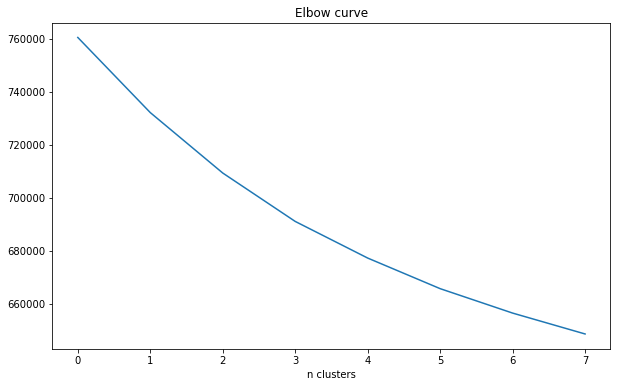

In [354]:
plt.figure(figsize=(10,6));
plt.plot(sd_sum);
plt.xlabel("n clusters");
plt.title("Elbow curve");

Według wykresu optymalna ilość klastrów 2-3, dodatkowo sprawdzenie za pomocą silhoutte score:

In [355]:
cluster_range = list(range(2,5))

Obliczenie optymalnej liczby klastrów za pomocą slihoutte score

In [356]:
for n_cluster in cluster_range:
    kmeans = KMeans(n_cluster, max_iter=1000)
    kmeans.fit(X_stand)
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(cluster_df, cluster_labels)
    print(f"For n_clusters={n_cluster}, the silhouette score is {silhouette_avg}")

For n_clusters=2, the silhouette score is 0.07102914518401948
For n_clusters=3, the silhouette score is 0.049821799617854504
For n_clusters=4, the silhouette score is 0.04905189312888783


Optymalna ilość klastrów biorąc pod uwagę oba wyniki wynosi 2-3, wybór:2

In [357]:
kmeans = KMeans(n_clusters=2, max_iter=1000)
kmeans.fit(X_stand)

KMeans(max_iter=1000, n_clusters=2)

In [358]:
cluster_labels = list(kmeans.labels_)

Dodanie do df kolumny z informacją o numerze klastra

In [359]:
cluster_df["K-Means_Cluster_ID"] = cluster_labels

Ilość rekordów w każdym z klastrów:

In [360]:
cluster_df["K-Means_Cluster_ID"].value_counts()

1    23290
0    15703
Name: K-Means_Cluster_ID, dtype: int64

## DB-scan

Wykorzystnaie kolejnej metody - DB-scan

In [361]:
dbscan=DBSCAN(eps=0.5, metric='euclidean')
dbscan.fit(cluster_df)

DBSCAN()

In [362]:
cluster_labels_DB = list(dbscan.labels_)

In [363]:
cluster_df["DBSCAN_Cluster_ID"] = cluster_labels_DB

In [364]:
cluster_df["DBSCAN_Cluster_ID"].value_counts()

-1    38993
Name: DBSCAN_Cluster_ID, dtype: int64

Wynik DB-Scan -> znajduje -1 klastrów - dane nie mają zależności, które możnaby wykryć za pomocą analizy skupień, przyczyną może być duża ilość zmiennych kategorycznych

Wniosek: najlepszy do klasteryzacji będzie K-Means, gdzie uzyskano 2 klastry -> w związku z tym, że jest to klasyfikacja na 2 klasy, podział na 2 klastry może być użyteczną informacją przy modelowaniu

In [365]:
cluster_df.drop("DBSCAN_Cluster_ID", axis=1, inplace=True)

II próba DB Scan wyłacznie dla danych numerycznych

In [366]:
cluster_df[numeric_cols]

installment  annual_inc       dti  open_acc  \
0        -0.772214   -1.145595  2.136795 -1.491587   
1        -1.313094   -0.978680 -1.854573 -1.491587   
2        -1.184488   -1.472413 -0.698349 -1.736022   
3         0.153958   -0.444554  0.991055  0.219461   
4        -1.271310    0.412273  0.682529  1.441638   
...            ...         ...       ...       ...   
38988     2.012917    0.412273 -1.538558 -1.002716   
38989    -0.435687   -0.144108 -0.033371  0.219461   
38990    -1.197034   -1.632428 -1.036829 -0.024975   
38991    -1.403276   -0.700490 -0.506644 -0.024975   
38992    -0.531853   -1.256871 -0.506644 -0.024975   

       years_since_earliest_cr_line  acc_rate  total_pymnt_prncp_diff  \
0                          1.811383 -0.743112               -0.372935   
1                         -0.239675  1.445811               -0.489357   
2                         -0.532683 -1.443567               -0.470277   
3                          0.199837 -1.074408                0.181617   
4                          0.199837 -0.420534               -0.285382   
...                             ...       ...                     ...   
38988                     -0.532683  1.883596               -1.073589   
38989                      0.346342 -0.852558               -0.984168   
38990                      0.346342 -0.130213               -0.926730   
38991                      0.346342 -0.130213               -0.580590   
38992                      0.346342 -0.130213                0.010576   

       loan_amnt_ratio  
0             0.259175  
1             0.278132  
2             0.278132  
3             0.278132  
4             0.278132  
...                ...  
38988        -3.380481  
38989        -3.048072  
38990        -2.674714  
38991        -3.513176  
38992        -3.513176  

[38993 rows x 8 columns]

In [367]:
dbscan=DBSCAN(eps=0.5, min_samples=20, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None)
dbscan.fit(cluster_df[numeric_cols])

DBSCAN(min_samples=20)

In [368]:
cluster_labels_DB = list(dbscan.labels_)

In [369]:
cluster_df["DBSCAN_Cluster_ID"] = cluster_labels_DB

In [370]:
cluster_df["DBSCAN_Cluster_ID"].value_counts()

-1     38214
 2       323
 3       151
 0       110
 6        45
 8        26
 4        23
 7        23
 1        22
 5        21
 10       18
 9        17
Name: DBSCAN_Cluster_ID, dtype: int64

In [371]:
cluster_df.drop("DBSCAN_Cluster_ID", axis=1, inplace=True)

Nadal podział na klastry za pomocą DB scan nieskuteczny -> w dalszej analizie K-Means

## Hierarchical Clustering

In [372]:
# from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree

In [373]:
# 3 metoda z zajęć - hierarchiczne -> blad przy dendrogramie - kernel died 
#-> próba podziału na 2 klastry (2 klasy w danych [0,1]- sprawdzenie takiego podziału bez wyznaczenia z denrogramu)
#-> bardzo długi czas klasteryzacji -> nieopoweidnia metoda do dużej ilości danych (do analizy wyłącznie klasteryzacja
# z DBscan i KMeans)

In [374]:
# sl_mergings = linkage(X_stand[numeric_cols], method="single", metric='euclidean')

In [375]:
# sl_cluster_labels = cut_tree(sl_mergings, n_clusters=2).reshape(-1, )
# sl_cluster_labels

### Analiza danych w klastrach - wybrany algorytm: K-means

In [376]:
cluster_df

installment  annual_inc       dti  open_acc  \
0        -0.772214   -1.145595  2.136795 -1.491587   
1        -1.313094   -0.978680 -1.854573 -1.491587   
2        -1.184488   -1.472413 -0.698349 -1.736022   
3         0.153958   -0.444554  0.991055  0.219461   
4        -1.271310    0.412273  0.682529  1.441638   
...            ...         ...       ...       ...   
38988     2.012917    0.412273 -1.538558 -1.002716   
38989    -0.435687   -0.144108 -0.033371  0.219461   
38990    -1.197034   -1.632428 -1.036829 -0.024975   
38991    -1.403276   -0.700490 -0.506644 -0.024975   
38992    -0.531853   -1.256871 -0.506644 -0.024975   

       years_since_earliest_cr_line  acc_rate  total_pymnt_prncp_diff  \
0                          1.811383 -0.743112               -0.372935   
1                         -0.239675  1.445811               -0.489357   
2                         -0.532683 -1.443567               -0.470277   
3                          0.199837 -1.074408                0.181617   
4                          0.199837 -0.420534               -0.285382   
...                             ...       ...                     ...   
38988                     -0.532683  1.883596               -1.073589   
38989                      0.346342 -0.852558               -0.984168   
38990                      0.346342 -0.130213               -0.926730   
38991                      0.346342 -0.130213               -0.580590   
38992                      0.346342 -0.130213                0.010576   

       loan_amnt_ratio  36_term  60_term  ...  0_FICO_diff  1_FICO_diff  \
0             0.259175      1.0      0.0  ...          1.0          0.0   
1             0.278132      0.0      1.0  ...          0.0          1.0   
2             0.278132      1.0      0.0  ...          1.0          0.0   
3             0.278132      1.0      0.0  ...          0.0          1.0   
4             0.278132      0.0      1.0  ...          1.0          0.0   
...                ...      ...      ...  ...          ...          ...   
38988        -3.380481      1.0      0.0  ...          0.0          0.0   
38989        -3.048072      1.0      0.0  ...          0.0          0.0   
38990        -2.674714      1.0      0.0  ...          0.0          1.0   
38991        -3.513176      1.0      0.0  ...          0.0          1.0   
38992        -3.513176      1.0      0.0  ...          0.0          0.0   

       2_FICO_diff  3_FICO_diff  4_FICO_diff  high_revol_util_level  \
0              0.0          0.0          0.0                    1.0   
1              0.0          0.0          0.0                    0.0   
2              0.0          0.0          0.0                    1.0   
3              0.0          0.0          0.0                    0.0   
4              0.0          0.0          0.0                    1.0   
...            ...          ...          ...                    ...   
38988          1.0          0.0          0.0                    1.0   
38989          1.0          0.0          0.0                    1.0   
38990          0.0          0.0          0.0                    0.0   
38991          0.0          0.0          0.0                    0.0   
38992          1.0          0.0          0.0                    0.0   

       low_revol_util_level  zero_revol_util_level  loan_status  \
0                       0.0                    0.0            1   
1                       1.0                    0.0            0   
2                       0.0                    0.0            1   
3                       1.0                    0.0            1   
4                       0.0                    0.0            1   
...                     ...                    ...          ...   
38988                   0.0                    0.0            0   
38989                   0.0                    0.0            0   
38990                   1.0                    0.0            0   
38991                   1.0                    0.0       

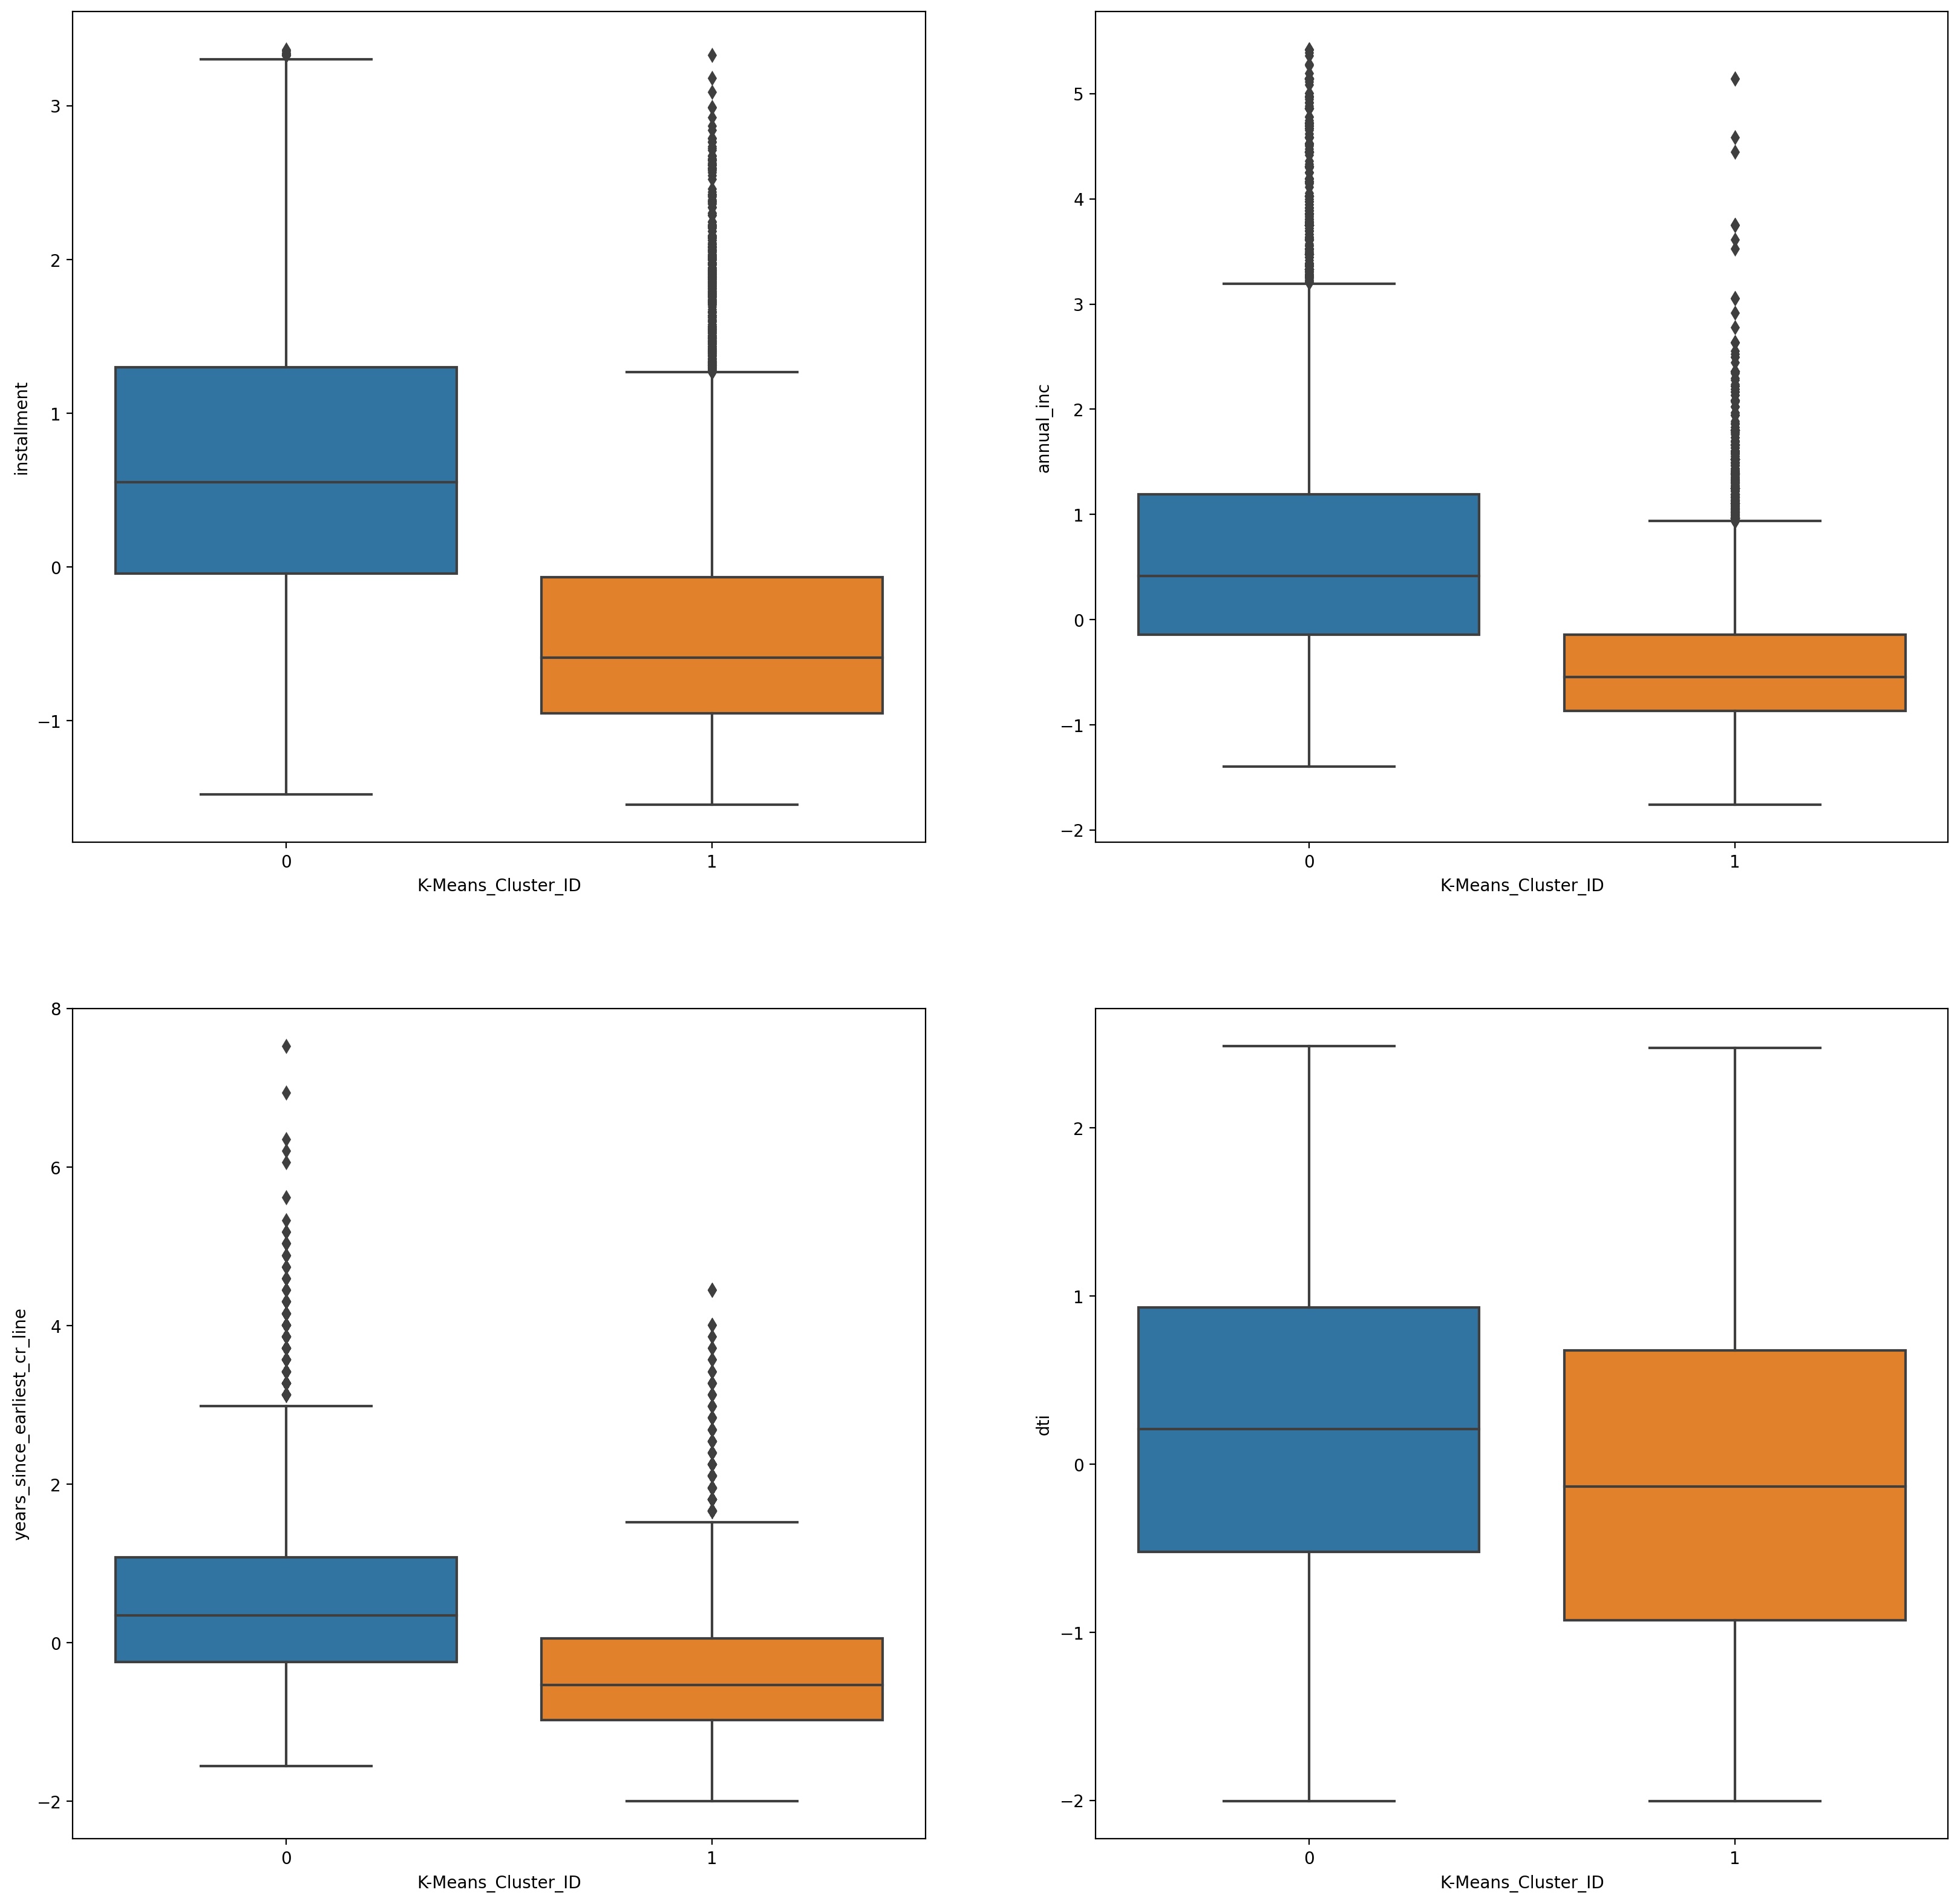

In [377]:
plt.figure(figsize=(20,20), dpi=200);

plt.subplot(2,2,1);
sns.boxplot(x="K-Means_Cluster_ID", y="installment", data=cluster_df);
plt.subplot(2,2,2);
sns.boxplot(x="K-Means_Cluster_ID", y="annual_inc", data=cluster_df);
plt.subplot(2,2,3);
sns.boxplot(x="K-Means_Cluster_ID", y="years_since_earliest_cr_line", data=cluster_df);
plt.subplot(2,2,4);
sns.boxplot(x="K-Means_Cluster_ID", y="dti", data=cluster_df);

* Klaster 0 zawiera osoby o większym dochodzie rocznym oraz z większymi ratami, klaster ten posiada również większy wiek kredytowy -> nazwiązując do analizy przeprowadzonej w części EDA osoby z tego klastra mają większe prawdopodobieństwo na spłatę pożyczki

* Klaster 1 zawiera osoby o niskich zarobkach, mniejszych ratach niż w przypadku klastra 1 oraz niższym wieku kredytowym, a więc prawdopobieństwo spłaty kredytu w tym klastrze może być niższe

Wykresy zależności pomiędzy wybranymi zmiennymi z uwzględnieniem klastrów

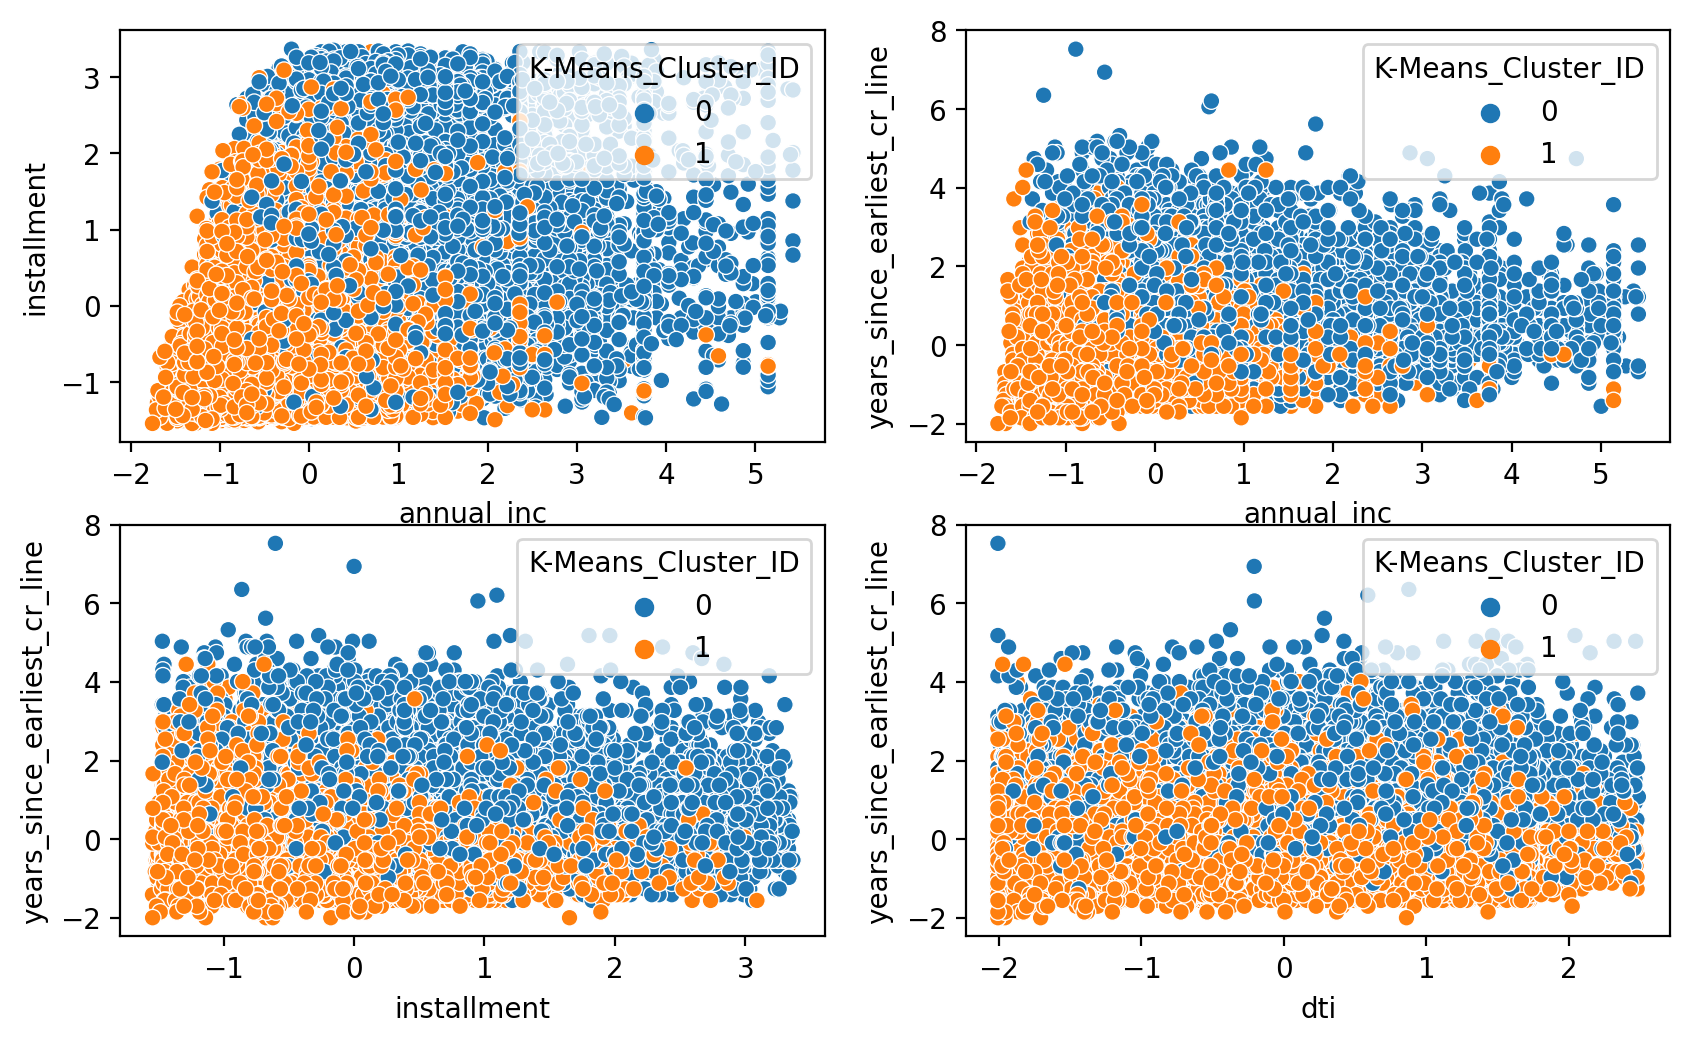

In [378]:
plt.figure(figsize=(10,6),dpi=200)

plt.subplot(2,2,1);
sns.scatterplot(x="annual_inc", y="installment", data=cluster_df, hue="K-Means_Cluster_ID");

plt.subplot(2,2,2);
sns.scatterplot(x="annual_inc",y="years_since_earliest_cr_line", data=cluster_df, hue="K-Means_Cluster_ID");

plt.subplot(2,2,3);
sns.scatterplot(x="installment",y="years_since_earliest_cr_line", data=cluster_df, hue="K-Means_Cluster_ID");

plt.subplot(2,2,4);
sns.scatterplot(x="dti",y="years_since_earliest_cr_line", data=cluster_df, hue="K-Means_Cluster_ID");

Przy podziale na 2 klastry, są one zbilansowane - można wyodrębnić wyraźnie 2 grupy pożyczkobiorców - bardziej zamożnych i mniej zamożnych jak podano we wnisokach powyżej. Informacja o numerze klastra jest więc istotna i zostaje dodana jako zmienna uwzględniona w modelowaniu.

In [379]:
X_stand["K-Means_Cluster_ID"] = cluster_labels

In [380]:
X_stand.head()

installment  annual_inc       dti  open_acc  years_since_earliest_cr_line  \
0    -0.772214   -1.145595  2.136795 -1.491587                      1.811383   
1    -1.313094   -0.978680 -1.854573 -1.491587                     -0.239675   
2    -1.184488   -1.472413 -0.698349 -1.736022                     -0.532683   
3     0.153958   -0.444554  0.991055  0.219461                      0.199837   
4    -1.271310    0.412273  0.682529  1.441638                      0.199837   

   acc_rate  total_pymnt_prncp_diff  loan_amnt_ratio  36_term  60_term  ...  \
0 -0.743112               -0.372935         0.259175      1.0      0.0  ...   
1  1.445811               -0.489357         0.278132      0.0      1.0  ...   
2 -1.443567               -0.470277         0.278132      1.0      0.0  ...   
3 -1.074408                0.181617         0.278132      1.0      0.0  ...   
4 -0.420534               -0.285382         0.278132      0.0      1.0  ...   

   -1_FICO_diff  0_FICO_diff  1_FICO_diff  2_FICO_diff  3_FICO_diff  \
0           0.0          1.0          0.0          0.0          0.0   
1           0.0          0.0          1.0          0.0          0.0   
2           0.0          1.0          0.0          0.0          0.0   
3           0.0          0.0          1.0          0.0          0.0   
4           0.0          1.0          0.0          0.0          0.0   

   4_FICO_diff  high_revol_util_level  low_revol_util_level  \
0          0.0                    1.0                   0.0   
1          0.0                    0.0                   1.0   
2          0.0                    1.0                   0.0   
3          0.0                    0.0                   1.0   
4          0.0                    1.0                   0.0   

   zero_revol_util_level  K-Means_Cluster_ID  
0                    0.0                   1  
1                    0.0                   1  
2                    0.0                   1  
3                    0.0                   0  
4                    0.0                   1  

[5 rows x 217 columns]

# Feature Selection - EDA cd.

## Mutual Info Score

In [381]:
from sklearn.feature_selection import mutual_info_classif

In [382]:
MI_score = mutual_info_classif(X_stand, y, random_state=42)

In [383]:
feature_MI_scores = pd.DataFrame(data=MI_score, index=X_stand.columns, columns=["MI_score"]).sort_values(by="MI_score", ascending=False)

In [384]:
feature_MI_scores["feature_ID"] = list(range(1, len(feature_MI_scores)+1))

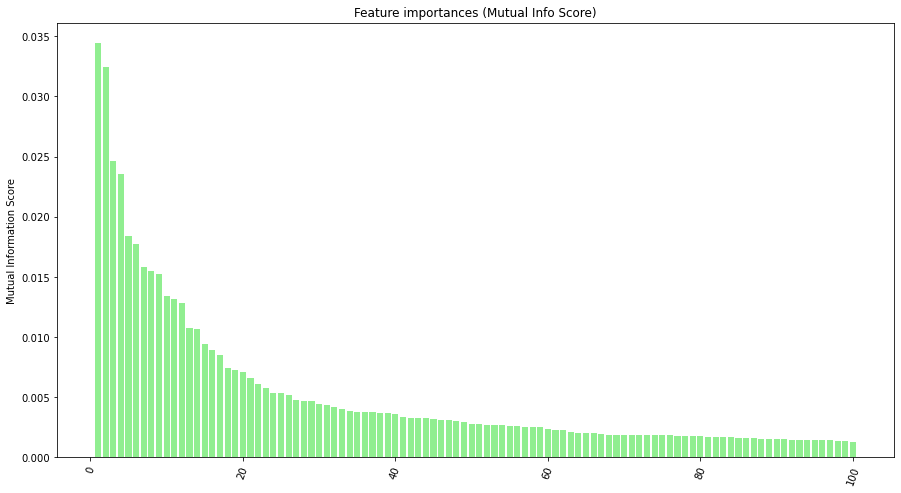

In [385]:
plt.figure(figsize=(15,8));
plt.bar(x=feature_MI_scores["feature_ID"][:100], height=feature_MI_scores["MI_score"][:100], color='lightgreen');
plt.ylabel('Mutual Information Score');
plt.xticks(rotation=70);
plt.title("Feature importances (Mutual Info Score)");

Wybór najlepszych zmiennych z wykresu -> 23 najlepsze z rankingu

In [386]:
best_features_labels = feature_MI_scores[feature_MI_scores["feature_ID"]<=23].index

In [387]:
feature_MI_scores.loc[best_features_labels]

MI_score  feature_ID
4_last_FICO_rating          0.034426           1
1_last_FICO_rating          0.032488           2
2_FICO_diff                 0.024676           3
2_last_FICO_rating          0.023569           4
-1_FICO_diff                0.018381           5
total_pymnt_prncp_diff      0.017709           6
A_grade                     0.015821           7
3_last_FICO_rating          0.015454           8
installment                 0.015226           9
N_debt_settlement_flag      0.013377          10
60_term                     0.013206          11
36_term                     0.012809          12
4_FICO_rating               0.010776          13
0_FICO_diff                 0.010679          14
low_revol_util_level        0.009433          15
loan_amnt_ratio             0.008944          16
1_FICO_diff                 0.008533          17
5_last_FICO_rating          0.007468          18
F_grade                     0.007264          19
K-Means_Cluster_ID          0.007078          20
DEBT_CONSOLIDATION_purpose  0.006617          21
high_revol_util_level       0.006080          22
0.0_inq_last_6mths          0.005772          23

Najepsze zmienne wybrane z rankingu:

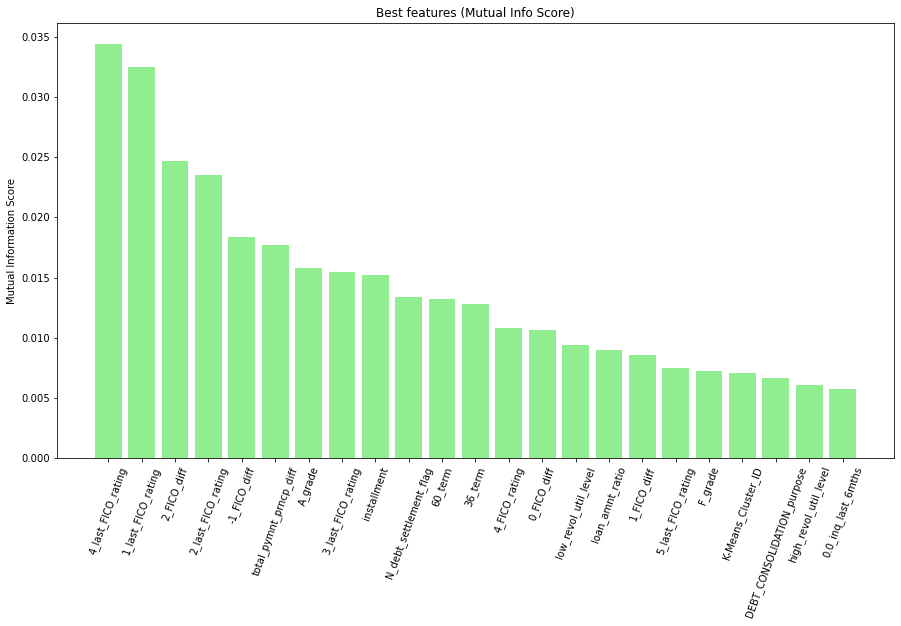

In [388]:
plt.figure(figsize=(15,8));
plt.bar(best_features_labels, height=feature_MI_scores.loc[best_features_labels]["MI_score"], color='lightgreen');
plt.ylabel('Mutual Information Score');
plt.xticks(rotation=70);
plt.title("Best features (Mutual Info Score)");

Wśród najlepszych zmiennych według MI Score można zauważyć wcześniej analizowane, które były wytypowane jako jedne z najbardziej wpływających na spłacenie pożyczki m.in FICO, FICO diff, grade, installment, inofrmacja o numerze klastra

In [389]:
X_selected = X_stand[best_features_labels]
X_selected

4_last_FICO_rating  1_last_FICO_rating  2_FICO_diff  \
0                     0.0                 0.0          0.0   
1                     0.0                 0.0          0.0   
2                     0.0                 0.0          0.0   
3                     0.0                 0.0          0.0   
4                     0.0                 0.0          0.0   
...                   ...                 ...          ...   
38988                 0.0                 1.0          1.0   
38989                 0.0                 1.0          1.0   
38990                 0.0                 0.0          0.0   
38991                 0.0                 0.0          0.0   
38992                 0.0                 1.0          1.0   

       2_last_FICO_rating  -1_FICO_diff  total_pymnt_prncp_diff  A_grade  \
0                     0.0           0.0               -0.372935      0.0   
1                     0.0           0.0               -0.489357      0.0   
2                     0.0           0.0               -0.470277      0.0   
3                     1.0           0.0                0.181617      0.0   
4                     0.0           0.0               -0.285382      0.0   
...                   ...           ...                     ...      ...   
38988                 0.0           0.0               -1.073589      0.0   
38989                 0.0           0.0               -0.984168      0.0   
38990                 1.0           0.0               -0.926730      1.0   
38991                 1.0           0.0               -0.580590      0.0   
38992                 0.0           0.0                0.010576      0.0   

       3_last_FICO_rating  installment  N_debt_settlement_flag  ...  \
0                     1.0    -0.772214                     1.0  ...   
1                     1.0    -1.313094                     1.0  ...   
2                     1.0    -1.184488                     1.0  ...   
3                     0.0     0.153958                     1.0  ...   
4                     1.0    -1.271310                     1.0  ...   
...                   ...          ...                     ...  ...   
38988                 0.0     2.012917                     1.0  ...   
38989                 0.0    -0.435687                     1.0  ...   
38990                 0.0    -1.197034                     1.0  ...   
38991                 0.0    -1.403276                     1.0  ...   
38992                 0.0    -0.531853                     1.0  ...   

       0_FICO_diff  low_revol_util_level  loan_amnt_ratio  1_FICO_diff  \
0              1.0                   0.0         0.259175          0.0   
1              0.0                   1.0         0.278132          1.0   
2              1.0                   0.0         0.278132          0.0   
3              0.0                   1.0         0.278132          1.0   
4              1.0                   0.0         0.278132          0.0   
...            ...                   ...              ...          ...   
38988          0.0                   0.0        -3.380481          0.0   
38989          0.0                   0.0        -3.048072          0.0   
38990          0.0                   1.0        -2.674714          1.0   
38991          0.0                   1.0        -3.513176          1.0   
38992          0.0                   1.0        -3.513176          0.0   

       5_last_FICO_rating  F_grade  K-Means_Cluster_ID  \
0                     0.0      0.0                   1   
1                     0.0      0.0                   1   
2                     0.0      0.0                   1   
3                     0.0      0.0                   0   
4                     0.0      0.0                   1   
...                   ...      ...                 ...   
38988                 0.0      1.0                   1   
38989                 0.0      0.0                   1   
38990                 0.0      0.0                   1   
38991                 0.0  

In [390]:
X_selected.to_pickle("X_selected.pkl")

In [391]:
X_selected = pd.read_pickle("X_selected.pkl")

# 5. Modeling

Będą wykorzystane 2 podejścia w związku z niezbliansowanymi danymi w loan_status:
1. oversampling&undersampling za pomocą SMOTETomek
2. dostosowanie wag w klasyfikatorach dla poszczególnych klas

### Splitting data - all features

In [392]:
X_train, X_test, y_train, y_test = train_test_split(X_stand, y, test_size=0.2, random_state=42)

## Fixing imbalanced data - using SMOTE/ADASYN/SMOTETomek

https://www.analyticsvidhya.com/blog/2020/10/overcoming-class-imbalance-using-smote-techniques/

In [393]:
# !pip install imblearn --ignore-installed scikit-learn

In [394]:
# SMOTE
# print("Before\n", y_train.value_counts())

# smt = SMOTE(random_state=42)
# X_train, y_train = smt.fit_resample(X_train, y_train)

# print("After\n", y_train.value_counts())

In [395]:
# ADASYN
# print("Before\n", y_train.value_counts())

# ada = ADASYN(random_state=42)
# X_train, y_train = ada.fit_resample(X_train, y_train)

# print("After\n", y_train.value_counts())

In [396]:
# SMOTETomek
print("Before\n", y_train.value_counts())

smtom = SMOTETomek(random_state=42)
X_train_sm, y_train_sm = smtom.fit_resample(X_train, y_train)

print("After\n", y_train_sm.value_counts())

Before
 1    26302
0     4892
Name: loan_status, dtype: int64
After
 0    26300
1    26300
Name: loan_status, dtype: int64


Wykorzystano oversampling a następnie undersampling, jeśli dane dla obu klas były zbliżone (usunięto 2 próbki), wcześniej próba używania SMOTE/ADASYN - lepsze wyniki dla SMOTETomek

## Model selection

1.	Wykonaj klasteryzację danych (wypróbuj do tego celu kilka metod, min. 3) i sprawdź, czy występują jakieś segmenty pożyczkobiorców, wykorzystaj odpowiednie metody do określenia optymalnej liczby klastrów (40 pkt)
2.	Wytrenuj 5 różnych modeli, wykorzystując do każdego inny algorytm, a następnie porównaj ich działanie, za metrykę oceny jakości modelu przyjmij AUROC score. (50pkt)
3.	Sprawdź działanie wcześniej użytych metod na skompresowanych danych za pomocą PCA, porównaj wyniki (AUROC score) z modelami wytrenowanymi w poprzednim podpunkcie. (20pkt)
4.	Zbuduj finalny model, którego AUROC score będzie >= 80%, pamiętaj o doborze istotnych zmiennych, kroswalidacji oraz dostrojeniu parametrów modelu, pomyśl również o zbalansowaniu klas. (40pkt)


Funkcja do fitowania modelu & wyznaczania accuracy,roc auc

In [397]:
def fit_and_score_model(model, X_train, X_test, y_train, y_test):
    
    np.random.seed(42)
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    y_pred = model.predict(X_test) # y_pred_test
    y_pred_train = model.predict(X_train)
    acc_train = accuracy_score(y_train, y_pred_train)
    roc_auc = roc_auc_score(y_test, y_pred)
        
    return score, y_pred, y_pred_train, acc_train, roc_auc

Funkcja do wizualizacji wyników: krzywa roc, conf matrix, calssification report

In [398]:
def scores_visualization(y_test, y_pred):
    print(classification_report(y_test, y_pred))
    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(cmap="bone");
    plt.show()
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    plt.plot(fpr,tpr, linewidth=3, color="purple");
    plt.ylabel("True Positive Rate");
    plt.xlabel("False Positive Rate");
    plt.title("ROC curve")
    plt.show()

##  I. Testowanie 5 modeli biorąc pod uwagę wszystkie zmienne ze zbilansowaniem klas za pomocą SMOTETomek

(Wyniki dla danego modelu zaprezentowane w tabelach)

### 1. Logistic Regression - balanced classes with SMOTE

In [399]:
model=LogisticRegression() 
score, y_pred, y_pred_train, acc_train, roc_auc = fit_and_score_model(model, X_train_sm, X_test, y_train_sm, y_test)

              precision    recall  f1-score   support

           0       0.36      0.79      0.50      1194
           1       0.95      0.75      0.84      6605

    accuracy                           0.75      7799
   macro avg       0.66      0.77      0.67      7799
weighted avg       0.86      0.75      0.79      7799



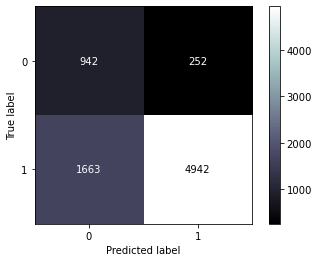

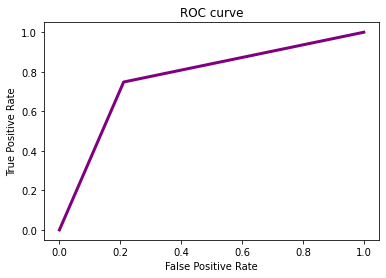

In [400]:
scores_visualization(y_test, y_pred)

In [401]:
model_metrics = pd.DataFrame([score, acc_train, roc_auc], columns=["LogisticRegression"],
             index = ["acc", "acc_train", "roc_auc"])
model_metrics

LogisticRegression
acc                  0.754456
acc_train            0.788574
roc_auc              0.768583

### 2. Random Forest - balanced classes with SMOTE

In [402]:
start_time_RF = time.time()

In [403]:
model=RandomForestClassifier(n_estimators = 60, max_depth=4)
score, y_pred, y_pred_train, acc_train, roc_auc = fit_and_score_model(model, X_train_sm, X_test, y_train_sm, y_test)

              precision    recall  f1-score   support

           0       0.37      0.70      0.48      1194
           1       0.94      0.78      0.85      6605

    accuracy                           0.77      7799
   macro avg       0.65      0.74      0.67      7799
weighted avg       0.85      0.77      0.79      7799



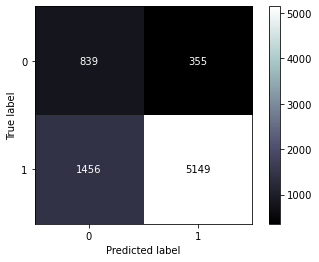

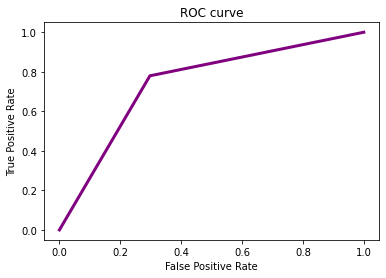

In [404]:
scores_visualization(y_test, y_pred)

In [405]:
run_time_RF = time.time() - start_time_RF
run_time_RF/60

0.042012627919514975

In [406]:
model_metrics["Random_Forest"] = [score, acc_train, roc_auc]

In [407]:
model_metrics

LogisticRegression  Random_Forest
acc                  0.754456       0.767791
acc_train            0.788574       0.808612
roc_auc              0.768583       0.741121

### 3. KNN - balanced classes with SMOTE

In [408]:
model = KNeighborsClassifier(n_neighbors=3)
score, y_pred, y_pred_train, acc_train, roc_auc = fit_and_score_model(model, X_train_sm, X_test, y_train_sm, y_test)

              precision    recall  f1-score   support

           0       0.25      0.82      0.39      1194
           1       0.95      0.56      0.70      6605

    accuracy                           0.60      7799
   macro avg       0.60      0.69      0.54      7799
weighted avg       0.84      0.60      0.65      7799



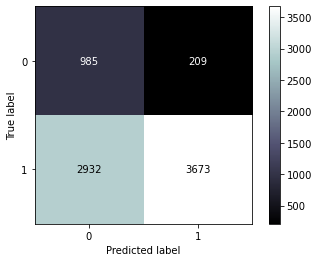

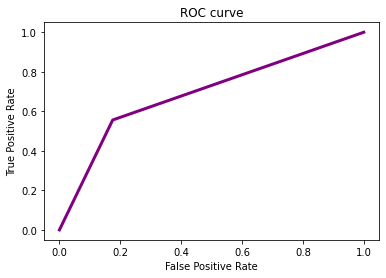

In [409]:
scores_visualization(y_test, y_pred)

In [410]:
model_metrics["KNN_n=3"] = [score, acc_train, roc_auc]
model_metrics

LogisticRegression  Random_Forest   KNN_n=3
acc                  0.754456       0.767791  0.597256
acc_train            0.788574       0.808612  0.859867
roc_auc              0.768583       0.741121  0.690526

### 4. XGBoost - balanced classes with SMOTE

In [411]:
# !pip install xgboost

In [412]:
model = xgb.XGBClassifier(n_estimators = 70, max_depth = 3, learning_rate=0.01)
score, y_pred, y_pred_train, acc_train, roc_auc = fit_and_score_model(model, X_train_sm, X_test, y_train_sm, y_test)

              precision    recall  f1-score   support

           0       0.35      0.76      0.48      1194
           1       0.94      0.75      0.83      6605

    accuracy                           0.75      7799
   macro avg       0.65      0.75      0.66      7799
weighted avg       0.85      0.75      0.78      7799



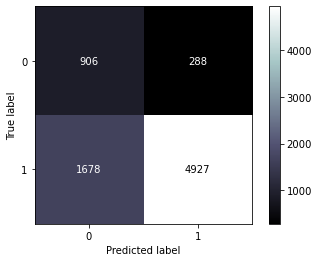

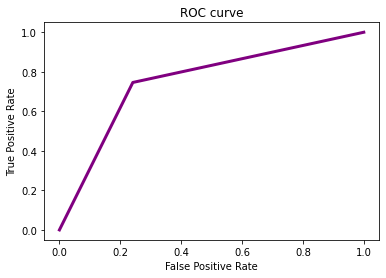

In [413]:
scores_visualization(y_test, y_pred)

In [414]:
model_metrics["XGBoost"] = [score, acc_train, roc_auc]
model_metrics

LogisticRegression  Random_Forest   KNN_n=3   XGBoost
acc                  0.754456       0.767791  0.597256  0.747916
acc_train            0.788574       0.808612  0.859867  0.788042
roc_auc              0.768583       0.741121  0.690526  0.752372

### 5. AdaBoost - balanced classes with SMOTE

In [415]:
model=AdaBoostClassifier(n_estimators=20, learning_rate=0.5)
score, y_pred, y_pred_train, acc_train, roc_auc = fit_and_score_model(model, X_train_sm, X_test, y_train_sm, y_test)

              precision    recall  f1-score   support

           0       0.36      0.70      0.47      1194
           1       0.93      0.78      0.85      6605

    accuracy                           0.76      7799
   macro avg       0.65      0.74      0.66      7799
weighted avg       0.85      0.76      0.79      7799



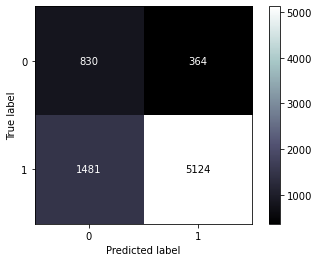

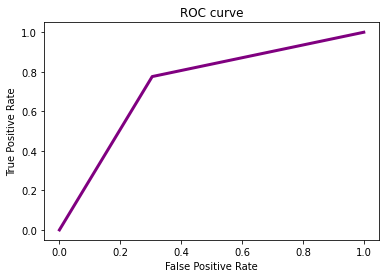

In [416]:
scores_visualization(y_test, y_pred)

In [417]:
model_metrics["AdaBoost"] = [score, acc_train, roc_auc]
model_metrics

LogisticRegression  Random_Forest   KNN_n=3   XGBoost  AdaBoost
acc                  0.754456       0.767791  0.597256  0.747916  0.763431
acc_train            0.788574       0.808612  0.859867  0.788042  0.822224
roc_auc              0.768583       0.741121  0.690526  0.752372  0.735459

Najlepsze wyniki roc auc dla regresji logistycznej i XGBoost

##  II. Testowanie 5 modeli biorąc pod uwagę wszystkie zmienne ze zbilansowaniem klas za pomocą SMOTETomek na danych z PCA

## PCA - balanced classes with SMOTE

In [418]:
pca = PCA()
X_PCA = pca.fit_transform(X_train_sm)
X_PCA = pd.DataFrame(X_PCA)

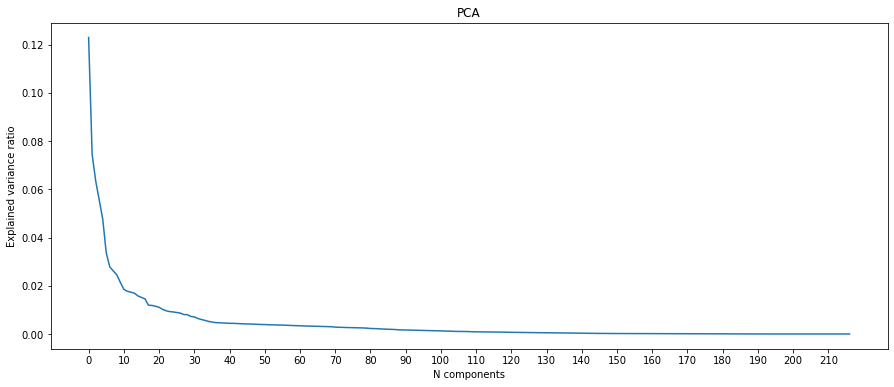

In [419]:
plt.figure(figsize=(15,6))
plt.plot(pca.explained_variance_ratio_)
plt.title("PCA")
plt.xlabel("N components")
plt.ylabel("Explained variance ratio")
plt.xticks(list(range(0,len(X_train_sm.columns),10)))
plt.show()

Z powyższego wykresu optymalna liczba komponentów ok 15 - po tej wartości znacząco spada poziom explaied variance ratio.

PCA z tą ilością komponentów:

In [420]:
pca_2 =  PCA(n_components=15)
X_train_PCA = pca_2.fit_transform(X_train_sm)
X_train_PCA = pd.DataFrame(X_train_PCA)

In [421]:
X_train_PCA

0         1         2         3         4         5         6   \
0      2.383029 -1.425207  0.054362  1.065189 -0.215307 -0.012514  1.512440   
1     -1.271125  1.469338 -0.106290 -0.464122 -0.846413 -0.096983  0.341233   
2     -2.070164 -1.714401  1.989562 -0.164375 -1.201918  0.721095 -0.478006   
3     -1.113413 -0.001665 -1.652279  0.504496  0.203027  0.503839 -1.289792   
4     -1.521791 -0.005936 -2.074147  0.145048  0.892567  0.042481 -0.386681   
...         ...       ...       ...       ...       ...       ...       ...   
52595 -0.512973 -0.860297 -1.129153  0.876611 -0.431088 -0.324338  1.391178   
52596 -0.056626  0.786013  1.774813 -0.797080  0.489839 -1.040809 -1.442532   
52597  1.204057 -0.070804  0.011844 -0.814766 -0.044923 -1.269387 -0.211432   
52598  1.614970 -0.808525 -0.110857  0.329714 -0.173292 -0.929475 -0.425506   
52599 -0.895437  0.022144 -0.804834  0.110911  0.273549 -0.226815  1.078903   

             7         8         9         10        11        12        13  \
0     -0.021255 -0.132392  0.050399  0.464867  0.499693  0.794999  0.296597   
1     -0.711428 -1.142847 -1.049670  0.186295  0.487176 -0.521147  1.237718   
2      0.371798 -1.200720 -0.374457 -0.196674  0.262969  0.317990 -0.228080   
3      0.081414  0.141068 -0.078533 -0.022622 -0.202730  0.219517 -0.327045   
4     -1.009645 -0.401785  0.455513  0.908934  0.078882 -0.154471  0.140672   
...         ...       ...       ...       ...       ...       ...       ...   
52595 -0.552838  0.273427  0.043724 -0.127383 -0.743922 -0.756591  0.478035   
52596  0.326897  0.046753 -0.161307  0.760025 -0.904650  0.778413 -0.068101   
52597  0.340701 -0.059111 -1.040106 -0.689840 -0.447493  0.270072 -0.015695   
52598  0.612429 -0.722354 -1.197504 -1.032388  0.539937 -0.122332  0.331937   
52599 -0.325038  0.291199 -0.704957 -0.019888  0.399760  1.115222  0.239404   

             14  
0     -1.396324  
1      0.204425  
2     -0.854802  
3     -0.059804  
4     -0.259942  
...         ...  
52595  0.161650  
52596  0.768433  
52597 -0.594196  
52598  0.310757  
52599  0.993682  

[52600 rows x 15 columns]

In [422]:
X_test_PCA = pca_2.fit_transform(X_test)
X_test_PCA = pd.DataFrame(X_test_PCA)

In [423]:
X_test_PCA

0         1         2         3         4         5         6   \
0    -0.871320  0.158041 -0.428023  0.669326 -0.056364  0.589870  0.370370   
1     0.718334 -1.462534  0.375034  0.345742  0.335314  1.349761  2.176648   
2    -2.266490 -0.716583  0.629544  0.227195  1.522500 -0.793833 -0.135330   
3    -1.397186  0.290535  1.174554 -0.890379  1.451470 -0.318462  0.118724   
4    -0.111598  0.961322  1.047883 -1.151807 -1.216793 -0.023438 -0.389522   
...        ...       ...       ...       ...       ...       ...       ...   
7794 -0.410400  0.241991  0.455386  0.237584 -0.681961  0.708409  0.208926   
7795 -2.431794  0.209727  1.310888 -0.572430 -0.280527  0.044481  0.064100   
7796 -0.901174  0.994156  1.495276 -0.916123  1.017493 -1.287926 -0.499051   
7797 -2.502630  0.406880  0.777302 -0.507387  1.426826 -0.104387  0.128971   
7798  2.320129  1.485739  0.158043 -1.056998 -0.735149  1.079844 -1.411704   

            7         8         9         10        11        12        13  \
0    -0.940574 -0.572862 -0.047607  0.343217  1.096069  1.252331 -0.008118   
1     0.159829 -0.689770  0.265356  0.417941 -0.365379 -0.179460 -0.336874   
2    -0.172039 -0.168515  0.135663 -0.567850  0.513087 -1.320780 -0.478236   
3    -0.114496  1.035957  0.356562  0.020238  1.340786  0.543099 -0.778373   
4    -0.589073 -0.244312 -0.894605 -0.167305 -0.449700  0.417268  0.392607   
...        ...       ...       ...       ...       ...       ...       ...   
7794  0.941384 -1.021772  0.860495  0.149155 -0.688513  0.484573 -0.400812   
7795  0.776095  0.848607 -0.479932  0.974755 -1.028071  0.031239 -0.285482   
7796 -0.775034 -0.116453  0.369233 -0.349337  1.109983 -1.258839 -0.648231   
7797 -0.073168  0.419757  0.107895 -0.153115  0.647163  0.491589  0.974541   
7798  0.610299 -1.196987 -0.765316 -0.237053 -0.876058  0.218012 -0.106131   

            14  
0     0.376434  
1    -0.093730  
2     0.318507  
3     0.406486  
4    -0.550463  
...        ...  
7794  0.259143  
7795  0.145581  
7796  0.632280  
7797 -0.619786  
7798  0.340852  

[7799 rows x 15 columns]

### 1. Logistic Regression PCA - balanced classes with SMOTE

In [424]:
model=LogisticRegression()
score, y_pred, y_pred_train, acc_train, roc_auc = fit_and_score_model(model, X_train_PCA, X_test_PCA, y_train_sm, y_test)

              precision    recall  f1-score   support

           0       0.21      0.68      0.32      1194
           1       0.90      0.55      0.68      6605

    accuracy                           0.57      7799
   macro avg       0.56      0.61      0.50      7799
weighted avg       0.80      0.57      0.63      7799



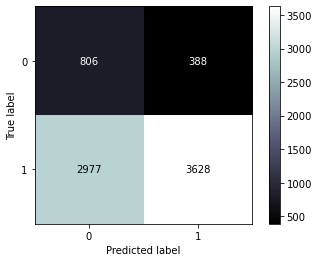

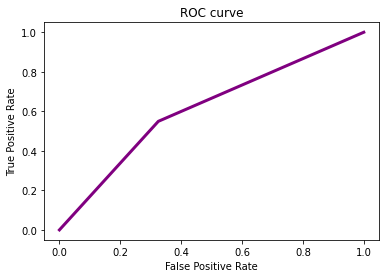

In [425]:
scores_visualization(y_test, y_pred)

In [426]:
model_metrics_PCA = pd.DataFrame([score, acc_train, roc_auc], columns=["LogisticRegression_PCA"],
             index = ["acc", "acc_train", "roc_auc"])
model_metrics_PCA

LogisticRegression_PCA
acc                      0.568534
acc_train                0.717243
roc_auc                  0.612161

### 2. Random Forest PCA - balanced classes with SMOTE

In [427]:
model=RandomForestClassifier(n_estimators = 60, max_depth=4)
score, y_pred, y_pred_train, acc_train, roc_auc = fit_and_score_model(model, X_train_PCA, X_test_PCA, y_train_sm, y_test)

              precision    recall  f1-score   support

           0       0.23      0.72      0.35      1194
           1       0.92      0.55      0.69      6605

    accuracy                           0.58      7799
   macro avg       0.57      0.64      0.52      7799
weighted avg       0.81      0.58      0.64      7799



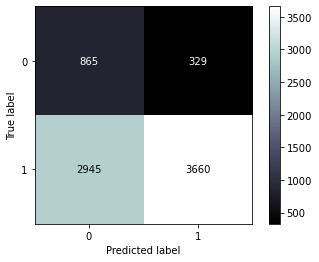

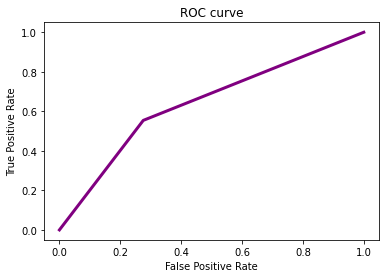

In [428]:
scores_visualization(y_test, y_pred)

In [429]:
model_metrics_PCA["RandomForest_PCA"] = [score, acc_train, roc_auc]
model_metrics_PCA

LogisticRegression_PCA  RandomForest_PCA
acc                      0.568534          0.580203
acc_train                0.717243          0.729829
roc_auc                  0.612161          0.639291

### 3. KNN PCA - balanced classes with SMOTE

In [430]:
model = KNeighborsClassifier(n_neighbors=3)
score, y_pred, y_pred_train, acc_train, roc_auc = fit_and_score_model(model, X_train_PCA, X_test_PCA, y_train_sm, y_test)

              precision    recall  f1-score   support

           0       0.20      0.55      0.29      1194
           1       0.88      0.60      0.71      6605

    accuracy                           0.59      7799
   macro avg       0.54      0.57      0.50      7799
weighted avg       0.78      0.59      0.65      7799



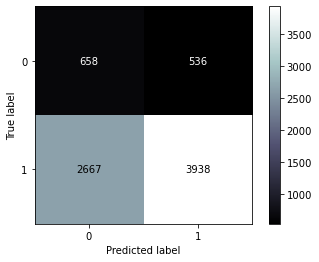

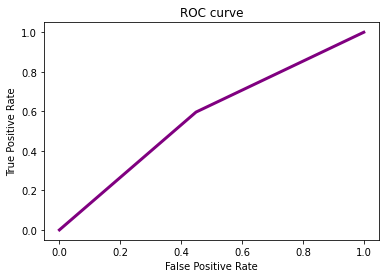

In [431]:
scores_visualization(y_test, y_pred)

In [432]:
model_metrics_PCA["KNN_PCA"] = [score, acc_train, roc_auc]
model_metrics_PCA

LogisticRegression_PCA  RandomForest_PCA   KNN_PCA
acc                      0.568534          0.580203  0.589306
acc_train                0.717243          0.729829  0.930551
roc_auc                  0.612161          0.639291  0.573652

### 4. XGBoost PCA - balanced classes with SMOTE

In [433]:
model = xgb.XGBClassifier(n_estimators = 70, max_depth = 3, learning_rate=0.01)
score, y_pred, y_pred_train, acc_train, roc_auc = fit_and_score_model(model, X_train_PCA, X_test_PCA, y_train_sm, y_test)

              precision    recall  f1-score   support

           0       0.22      0.73      0.34      1194
           1       0.92      0.54      0.68      6605

    accuracy                           0.57      7799
   macro avg       0.57      0.64      0.51      7799
weighted avg       0.81      0.57      0.63      7799



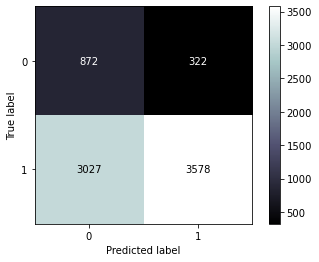

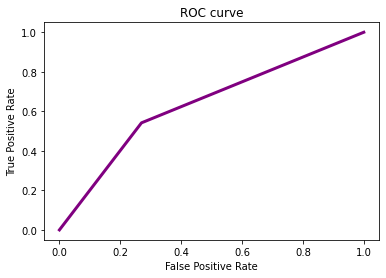

In [434]:
scores_visualization(y_test, y_pred)

In [435]:
model_metrics_PCA["XGBoost_PCA"] = [score, acc_train, roc_auc]
model_metrics_PCA

LogisticRegression_PCA  RandomForest_PCA   KNN_PCA  XGBoost_PCA
acc                      0.568534          0.580203  0.589306     0.570586
acc_train                0.717243          0.729829  0.930551     0.706426
roc_auc                  0.612161          0.639291  0.573652     0.636015

### 5. AdaBoost PCA - balanced classes with SMOTE

In [436]:
model=AdaBoostClassifier(n_estimators=20, learning_rate=0.5)
score, y_pred, y_pred_train, acc_train, roc_auc = fit_and_score_model(model, X_train_PCA, X_test_PCA, y_train_sm, y_test)

              precision    recall  f1-score   support

           0       0.22      0.71      0.33      1194
           1       0.91      0.54      0.68      6605

    accuracy                           0.56      7799
   macro avg       0.56      0.62      0.51      7799
weighted avg       0.81      0.56      0.62      7799



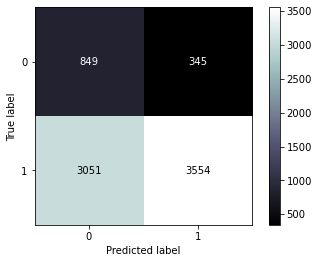

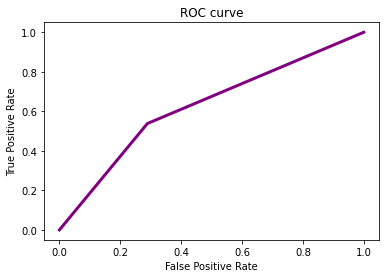

In [437]:
scores_visualization(y_test, y_pred)

In [438]:
model_metrics_PCA["AdaBoost_PCA"] = [score, acc_train, roc_auc]
model_metrics_PCA

LogisticRegression_PCA  RandomForest_PCA   KNN_PCA  XGBoost_PCA  \
acc                      0.568534          0.580203  0.589306     0.570586   
acc_train                0.717243          0.729829  0.930551     0.706426   
roc_auc                  0.612161          0.639291  0.573652     0.636015   

           AdaBoost_PCA  
acc            0.564560  
acc_train      0.717928  
roc_auc        0.624566

In [439]:
model_metrics

LogisticRegression  Random_Forest   KNN_n=3   XGBoost  AdaBoost
acc                  0.754456       0.767791  0.597256  0.747916  0.763431
acc_train            0.788574       0.808612  0.859867  0.788042  0.822224
roc_auc              0.768583       0.741121  0.690526  0.752372  0.735459

In [440]:
model_metrics_PCA = model_metrics_PCA.T

In [441]:
model_metrics = model_metrics.T

## Porównanie metryk z wykorzystaniem PCA i bez PCA

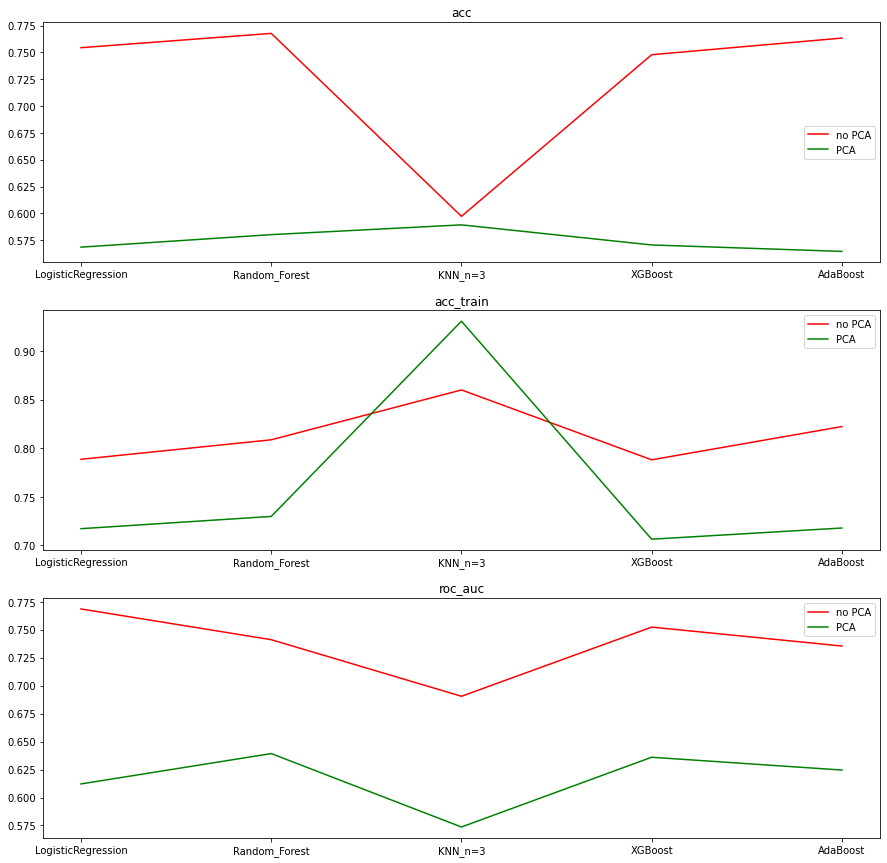

In [442]:
i=0
fig, axs = plt.subplots(3,figsize=(15,15));
for item in model_metrics.columns:
    axs[i].plot(model_metrics.index, model_metrics[item], label = "no PCA", color="red");
    axs[i].plot(model_metrics.index, model_metrics_PCA[item], label = "PCA", color="green");
    axs[i].legend();
    axs[i].set_title(item);
    i+=1

Wnioski: zastosowanie pogarsza wyniki w wykorzystanych modelach. Wynik roc auc znacząco spada po wykorzystaniu pca - skompresowanie danych wpływa negatywnie na zastosowane modele.

## III. Testowanie XGBoost w wykorzystaniem doboru wag oraz na wyselekcjonowanych zmiennych

## using selected features & weights in XGBoost (without SMOTE)

In [443]:
X_train_sel, X_test_sel, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [444]:
scale_pos_weight = y_train[y_train==0].count()/y_train[y_train==1].count()
scale_pos_weight

0.18599346057334043

In [445]:
model = xgb.XGBClassifier(n_estimators = 70, max_depth = 3, learning_rate=0.01, scale_pos_weight=scale_pos_weight)
score, y_pred, y_pred_train, acc_train, roc_auc = fit_and_score_model(model, X_train_sel, X_test_sel, y_train, y_test)

              precision    recall  f1-score   support

           0       0.35      0.77      0.48      1194
           1       0.95      0.75      0.83      6605

    accuracy                           0.75      7799
   macro avg       0.65      0.76      0.66      7799
weighted avg       0.86      0.75      0.78      7799



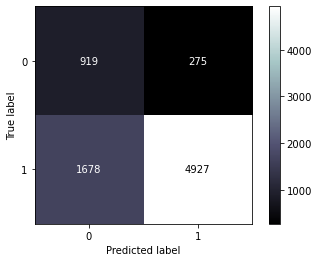

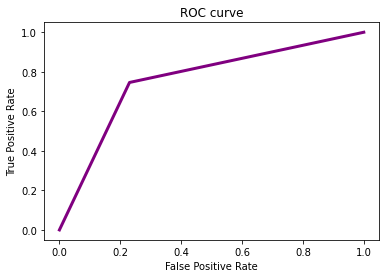

In [446]:
scores_visualization(y_test, y_pred)

In [447]:
roc_auc

0.7578158899468324

Dobry wynik modelu -> następnie do hyperparameter tuning, co poprawi wynik

## IV. Trenowanie 5 modeli z wykorzystaniem  wyselekcjonowanych zmiennych oraz z użyciem SMOTE do zbilansowania klas

### Selected features + SMOTE

In [448]:
# SMOTETomek
print("Before\n", y_train.value_counts())

smtom = SMOTETomek(random_state=42)
X_train_sel_sm, y_train_sm = smtom.fit_resample(X_train_sel, y_train)

print("After\n", y_train.value_counts())

Before
 1    26302
0     4892
Name: loan_status, dtype: int64
After
 1    26302
0     4892
Name: loan_status, dtype: int64


In [449]:
models = [LogisticRegression(),
          RandomForestClassifier(n_estimators = 60, max_depth=4),
          KNeighborsClassifier(n_neighbors=3),
          xgb.XGBClassifier(n_estimators = 70, max_depth = 3, learning_rate=0.01),
          AdaBoostClassifier(n_estimators=20, learning_rate=0.5)
          ]

In [450]:
model_metrics_selected = pd.DataFrame(index = ["acc", "acc_train", "roc_auc"], columns=model_metrics.T.columns)

Wytrenowanie modeli w pętli:

In [451]:
counter=0
for model in models:
    score, y_pred, y_pred_train, acc_train, roc_auc = fit_and_score_model(model, X_train_sel_sm, X_test_sel, y_train_sm, y_test)
    model_metrics_selected.iloc[:, counter] = [score, acc_train, roc_auc]
    counter+=1

Porównanie otrzymanych wyników dla modeli działających na zmiennych po selekcji (1 tablela) i  na wszystkich danych (2 tabela)

In [452]:
model_metrics_selected

LogisticRegression  Random_Forest   KNN_n=3   XGBoost  AdaBoost
acc                  0.740736       0.748429  0.779972  0.748814  0.733043
acc_train            0.776431       0.774345  0.942489  0.776233  0.787278
roc_auc              0.761169       0.754390  0.700970  0.755303  0.754912

In [453]:
model_metrics.T

LogisticRegression  Random_Forest   KNN_n=3   XGBoost  AdaBoost
acc                  0.754456       0.767791  0.597256  0.747916  0.763431
acc_train            0.788574       0.808612  0.859867  0.788042  0.822224
roc_auc              0.768583       0.741121  0.690526  0.752372  0.735459

Wnioski: lepsze wyniki na zmiennych po selekcji + działanie na mniejszej ilości danych zwiększa szybkość trenowania

# Hyperparameter tuning

Wnioskując po wynikach powyżej do dostrajania parametrów wykorzystane zostaną:

* XGBoost na danych po selekcji z doborem wag
* LogisticRegression na danych po selekcji, bilans klas-SMOTETomek
* RandomForest na danych po selekcji z doborem wag

RadomizedSearch/GridSearch zakomentowane - długi czas, wyniki w komentarzach

Dobór parametrów najpierw za pomocą RandomizedSearch, następnie stopniowe ogarniczanie zakresów parametrów. Po osiągnięciu małego zakresu parametrów do przeszukania wykorzystanie dokładniejszego GridSearch. Scoring ustawiony w poszukiwaniu najlepszegto roc_auc.

### XGBoost - selected + weights

zalecane wagi z dokumentacji:

scale_pos_weight = klasa mniej liczna/klasa większa

In [454]:
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(X_selected, y, test_size=0.2, random_state=42)

#### Radnomized Search CV

In [455]:
# xgb_grid = {'min_child_weight': np.arange(1, 10, 1),
#             'gamma': np.arange(0.5, 1, 0.1),
#             'subsample': [0.8], #[0.6, 0.8, 1.0]
#             'colsample_bytree': [0.6], #[0.6, 0.8, 1.0]
#             'max_depth': np.arange(3, 10, 1),
#             'learning_rate': np.arange(0.01, 0.3, 0.01),
#             'n_estimators': np.arange(500, 650, 5),
#             }

In [456]:
# scale_pos_weight = y_train_sel[y_train_sel==0].count()/y_train_sel[y_train_sel==1].count()
# scale_pos_weight # 0.18599346057334043 

In [457]:
# model = xgb.XGBClassifier(objective='binary:logistic', nthread=1, scale_pos_weight=scale_pos_weight)

In [458]:
# start_xgb = time.time()

In [459]:
# xgb_RS = RandomizedSearchCV(model,
#                             param_distributions=xgb_grid,
#                             n_iter=20,
#                             scoring='roc_auc',
#                             n_jobs=4,
#                             cv=5,
#                             verbose=3,
#                             random_state=42)
# xgb_RS.fit(X_train_sel, y_train_sel);

In [460]:
# run_time_xgb = (time.time() - start_xgb)/60
# run_time_xgb # 0.606156587600708

In [461]:
# xgb_RS.best_params_

In [462]:
# y_pred = xgb_RS.predict(X_test_sel)
# roc_auc_score(y_test_sel, y_pred) # 0.7858841900646305

In [463]:
# xgb_RS.score(X_test, y_test) # 0.8768534826542502

In [464]:
# best_XG_1={'subsample': 0.8,
#  'n_estimators': 600,
#  'min_child_weight': 1,
#  'max_depth': 5,
#  'learning_rate': 0.060000000000000005,
#  'gamma': 0.6,
#  'colsample_bytree': 0.6}

In [465]:
# pickle.dump(xgb_RS, open('XG_model1.pkl', 'wb'))

In [466]:
# model = pickle.load(open('XG_model1.pkl', 'rb'))
# model.predict(X_test_sel);

In [467]:
# roc_auc_score(y_test_sel, y_pred)

In [468]:
# scores_visualization(y_test_sel, y_pred)

Best 1 (XG_model1.pkl) -> roc 0.7858841900646305

#### Randomized Search - 2 próba

In [469]:
# scale_pos_weight = y_train_sel[y_train_sel==0].count()/y_train_sel[y_train_sel==1].count()
# scale_pos_weight

In [470]:
# xgb_grid_2 = {'min_child_weight': np.arange(1, 5, 1),
#             'gamma': np.arange(0.8, 1.1, 0.1),
#             'max_depth': np.arange(5, 10, 1),
#             'learning_rate': np.arange(0.01, 0.2, 0.01),
#             'n_estimators': np.arange(500, 600, 5),
#             'scale_pos_weight' : np.arange(0.1, scale_pos_weight, 0.01)
#             }

In [471]:
# model = xgb.XGBClassifier(objective='binary:logistic',
#                           nthread=1,
#                           colsample_bytree=0.6,
#                           subsample=0.8
#                           )

In [472]:
# start_xgb = time.time()

In [473]:
# xgb_RS_2 = RandomizedSearchCV(model,
#                             param_distributions=xgb_grid_2,
#                             n_iter=200,
#                             scoring='roc_auc',
#                             n_jobs=4,
#                             cv=5,
#                             verbose=3,
#                             random_state=42)
# xgb_RS_2.fit(X_train_sel, y_train_sel);

In [474]:
# run_time_xgb = (time.time() - start_xgb)/60
# run_time_xgb #5.19

In [475]:
# xgb_RS_2.best_params_

In [476]:
# y_pred = xgb_RS_2.predict(X_test_sel)
# roc_auc_score(y_test_sel, y_pred)

Best params for XGBoost:

* 'scale_pos_weight': 0.19000000000000003,
* 'n_estimators': 505,
* 'min_child_weight': 1,
* 'max_depth': 8,
* 'learning_rate': 0.05,
* 'gamma': 0.8}
* n_iter=200,

roc auc = 0.7884177384525454
features: 23 (selected from mutual score)

### Logistic Regression - selected + SMOTE

In [477]:
# # SMOTETomek
# print("Before\n", y_train.value_counts())

# smtom = SMOTETomek(random_state=42)
# X_train_sel_sm, y_train_sel_sm = smtom.fit_resample(X_train_sel, y_train_sel)

# print("After\n", y_train.value_counts())

In [478]:
# log_reg_grid = {"C": np.logspace(-4,4,20)}

In [479]:
# start_log_reg = time.time()

In [480]:
# np.random.seed(42)
# log_reg_rs = RandomizedSearchCV(LogisticRegression(solver="lbfgs"),
#                                 param_distributions=log_reg_grid,
#                                 cv=5,
#                                 n_iter=20,
#                                 verbose=3,
#                                 scoring='roc_auc')

# log_reg_rs.fit(X_train_sel_sm, y_train_sel_sm);

In [481]:
# run_time_log_reg = (time.time() - start_log_reg)/60
# run_time_log_reg

In [482]:
# y_pred = log_reg_rs.predict(X_test_sel)
# roc_auc_score(y_test_sel, y_pred)

In [483]:
# log_reg_rs.best_params_

Best : {'solver': 'lbfgs', 'C': 6866.488450042998} --> roc 0.7613607401123712

### RandomForest - selected + class weight

In [484]:
# rf_grid = {"n_estimators": np.arange(400, 700, 50),
#            "max_depth": np.arange(7, 15, 1),
#            "min_samples_split": np.arange(10, 20, 1),
#            "min_samples_leaf": np.arange(1, 10, 1)}

In [485]:
# model = RandomForestClassifier(class_weight='balanced_subsample') # zbilansowanie danych w loan_status

In [486]:
# start_rs = time.time()

In [487]:
# np.random.seed(42)

# # Setup random hyperparameter search for RandomForestClassifier
# rs_rf = RandomizedSearchCV(model,
#                            param_distributions=rf_grid,
#                            cv=5,
#                            n_iter=20,
#                            verbose=3,
#                            scoring='roc_auc')

# rs_rf.fit(X_train_sel, y_train_sel);

In [488]:
# run_time_rs = (time.time() - start_rs)/60
# run_time_rs # 17.153378637631736

In [489]:
# rs_rf.best_params_

In [490]:
# best_rf1= {'n_estimators': 510,
#  'min_samples_split': 14,
#  'min_samples_leaf': 1,
#  'max_depth': None}

In [491]:
# y_pred = rs_rf.predict(X_test_sel)
# roc_auc_score(y_test_sel, y_pred)

Best:
roc 0.7705947730070997

{'n_estimators': 300,
 'min_samples_split': 14,
 'min_samples_leaf': 7,
 'max_depth': None}
 
 balanced_subsample

In [492]:
# rs_rf.score(X_test_sel, y_test_sel)

In [493]:
# pickle.dump(rs_rf, open('rs_rf1.pkl', 'wb'))

#### Grid Search

In [494]:
# model = RandomForestClassifier(max_depth=4, n_estimators=240)

In [495]:
# start_rf = time.time()

In [496]:
# np.random.seed(42)

# # Setup random hyperparameter search for RandomForestClassifier
# rs_rf_2 = RandomizedSearchCV(model,
#                            param_distributions=rf_grid_2,
#                            cv=5,
#                            n_iter=20,
#                            verbose=3,
#                            scoring='roc_auc')

# rs_rf_2.fit(X_train_sel_sm, y_train_sel_sm);

In [497]:
# run_time_rf = (time.time() - start_rf)/60
# run_time_rf #6.661723947525024

In [498]:
# rs_rf_2.best_params_ # {'min_samples_split': 2, 'min_samples_leaf': 1}

In [499]:
# y_pred = rs_rf_2.predict(X_test_sel)
# roc_auc_score(y_test_sel, y_pred) # 0.756408208085596

In [500]:
# pickle.dump(rs_rf_2, open('rs_rf2.pkl', 'wb'))

# Final Model

**XGBoost**
* 23 selected features based by Mutual Info Score
* imbalanced classes -> `solution:` setting `scale_pos_weight`

In [501]:
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [502]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic',
                                nthread=1,
                                colsample_bytree=0.6,
                                subsample=0.8,
                                scale_pos_weight=0.19000000000000003,
                                n_estimators=505,
                                min_child_weight=1,
                                max_depth=8,
                                learning_rate = 0.05,
                                gamma=0.8)

In [503]:
score, y_pred, y_pred_train, acc_train, roc_auc = fit_and_score_model(xgb_model, X_train_sel, X_test_sel, y_train_sel, y_test_sel)

              precision    recall  f1-score   support

           0       0.38      0.81      0.52      1194
           1       0.96      0.76      0.85      6605

    accuracy                           0.77      7799
   macro avg       0.67      0.79      0.69      7799
weighted avg       0.87      0.77      0.80      7799



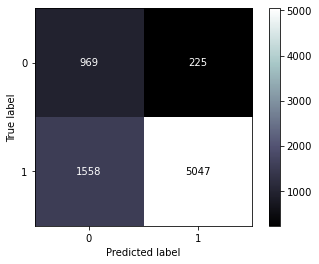

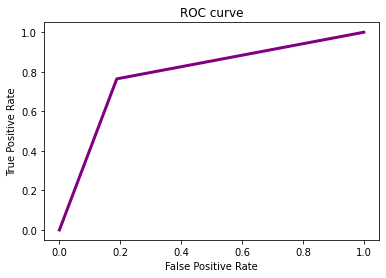

In [504]:
scores_visualization(y_test_sel, y_pred)

Cross-validacja wyników:

In [505]:
acc_scores = cross_val_score(xgb_model, X_selected, y, cv=5)
roc_auc_scores = cross_val_score(xgb_model, X_selected, y, cv=5, scoring='roc_auc')
recall_scores = cross_val_score(xgb_model, X_selected, y, cv=5, scoring='recall')
precision_scores = cross_val_score(xgb_model, X_selected, y, cv=5, scoring='precision')

In [506]:
acc_cv = acc_scores.mean()
roc_cv = roc_auc_scores.mean()
recall_cv = recall_scores.mean()
precision_cv = precision_scores.mean()

In [507]:
final_model_scores = pd.DataFrame([roc_cv, acc_cv, recall_cv, precision_cv],
                                  index=["roc auc score", "accuracy", "recall", "precision"],
                                  columns=["Cross-validated metrics"])
final_model_scores

Cross-validated metrics
roc auc score                 0.847252
accuracy                      0.768650
recall                        0.772176
precision                     0.944063

Wykorzystane zmienne:

In [508]:
best_features_labels 
# zasadność wyboru cech opisana była na etapie selekcji - wybrane cechy mają sens na podstawie wcześniejszych analiz w EDA
# w zmiennych dominuje wynik FICO, który jest dobrym wskaznikiem oceny spłacalności

Index(['4_last_FICO_rating', '1_last_FICO_rating', '2_FICO_diff',
       '2_last_FICO_rating', '-1_FICO_diff', 'total_pymnt_prncp_diff',
       'A_grade', '3_last_FICO_rating', 'installment',
       'N_debt_settlement_flag', '60_term', '36_term', '4_FICO_rating',
       '0_FICO_diff', 'low_revol_util_level', 'loan_amnt_ratio', '1_FICO_diff',
       '5_last_FICO_rating', 'F_grade', 'K-Means_Cluster_ID',
       'DEBT_CONSOLIDATION_purpose', 'high_revol_util_level',
       '0.0_inq_last_6mths'],
      dtype='object')

Wnioski:

Ostateczny model to XGBoost z wykorzystanuiem 23 najlepszych zmiennych z rankingu utworzonego z wykorzystaniem Mutual Score Info oraz rozwiązaniem problemu niezbilansowanych klas za pomocą dostrojenia wag w klasyfikatorze. Dostrojenie wag jest lepsze od poprzednich prób z wykorzystaniem oversamplingu i undersamplingu, ponieważ nie występuje dodawanie "sztucznych" danych. Za metrykę oceny jakości modelu przyjęto roc auc score, osiągnięto 84,7%, na najniższym poziomie znajduje się accuracy oraz recall - poziom 76-77%.

# Save & load final model

In [509]:
pickle.dump(xgb_model, open('xgb_model_final.pkl', 'wb'))

In [510]:
# xgb_model = pickle.load(open('xgb_model_final.pkl', 'rb'))

###########


https://shivamkc01.medium.com/handling-imbalanced-dataset-in-machine-learning-9ac075787e07
https://www.kaggle.com/code/ar2017/basics-of-feature-selection-with-python

https://www.kaggle.com/code/ar2017/basics-of-feature-selection-with-python
https://ranjani-rajamani.medium.com/high-on-accuracy-but-low-on-roc-score-a40f2053b6c4

In [511]:
run_time = (time.time() - start_time)/60
run_time #5.28 min

5.288083211580912